In [1]:
%pylab inline

from lib.KDTreeEncoding import *

import xgboost as xgb
from lib.XGBHelper import *
from lib.XGBoost_params import *
from lib.score_analysis import *

from lib.logger import logger

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy import load
from glob import glob
import pandas as pd
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


In [2]:
# setting up random seed, it has been set in all helper lib too
np.random.seed(123)

In [3]:
# set path to directories here
poverty_dir = '/datasets/cs255-sp22-a00-public/poverty/'
image_dir = poverty_dir + '/anon_images'
train_table = '../public_tables/train.csv'

In [4]:
# creating main dataframe and image files here
df=pd.read_csv(train_table,index_col=0)
df.index = df['filename']
files=list(glob(f'{image_dir}/*.npz'))

In [5]:
## Pickled the encoded dataset, so can skip this cell if no changes are being made here (pickle again if Yes)
## Getting features from the images in the main dataframe Enc_data using KD-trees
## Can think of changes here to extract features from the images in a different manner
## max_images = 610 works, but 615 will run out of memory and kernel dies
## try changing the randomness factor here file choosing images to use for encoding
## tree depth: (2^(tree_depth+1))+1 will decide how many columns we will be having in our encoded dataset
## so right now 1024+1 columns will be used to encode the image data as a feature vector
tree_depth = 8
train_size,tree=train_encoder(files,max_images=500,tree_depth=tree_depth)
Enc_data=encoded_dataset(image_dir,df,tree, depth=tree_depth, label_col='label')

used 500 images to train KDTree
KDTree training data shape= (25088000, 8)


In [6]:
# saving this encoded dataset and tree so that we don't have to encode it every time
# run this cell only if you have made changes to the encoding design
encoded_dataset=f'encoded_dataset.pk'
encoder_tree=f'encoder_tree.pk'
pkl.dump(Enc_data,open(encoded_dataset,'wb'))
pkl.dump(tree, open(encoder_tree,'wb'))

In [7]:
# run this cell to load the encoded dataset and tree 
encoded_dataset=f'encoded_dataset.pk'
encoder_tree = f'encoder_tree.pk'
Enc_data = pkl.load(open(encoded_dataset,'rb'))
tree = pkl.load(open(encoder_tree,'rb'))

In [8]:
# Creating object D to handle dataset functionalities
# like getting subsets, bootstrapping samples, etc
D = DataSplitter(Enc_data.data)

In [9]:
# creating a new metric for our XGBoost algorithm
from sklearn.metrics import f1_score, recall_score

def calc_f1(predt: np.ndarray, dtrain: xgb.DMatrix):
    preds = (predt > 0.5).astype(np.int64)
    res = f1_score(predt>0.5, dtrain.get_label())
    return 'f1', res



In [10]:
# Set all params for XGBoost here
# param dictionary is already present in the lib.XGBoost_Params file
# default parameters are set, can be customized and new params can also be added
param['max_depth'] = 3   # depth of tree
param['eta'] = 0.15      # shrinkage parameter
param['verbosity'] = 0  # 0= no logging 3=max logging
param['feature_selector'] = 'shuffle'
# added parameters from tanmay's part
param['verbose_eval'] = 1 
# param['early_stopping_rounds'] = 15
# param['eval_metric'] = ['auc']
# param['feature_selector'] = 'shuffle'
param['custom_metric'] = calc_f1
param['disable_default_eval_metric']=True


# param['objective'] = 'binary:logistic'
# param['nthread'] = 7 # Number of threads used
param['eval_metric'] = ['error','logloss','auc']
param

{'max_depth': 3,
 'eta': 0.15,
 'verbosity': 0,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': ['error', 'logloss', 'auc'],
 'feature_selector': 'shuffle',
 'verbose_eval': 1,
 'custom_metric': <function __main__.calc_f1(predt:numpy.ndarray, dtrain:xgboost.core.DMatrix)>,
 'disable_default_eval_metric': True}

In [ ]:
# deciding which rows in dataset to select [True, False, False, True,.....]
train_selector=np.random.rand(df.shape[0]) > 0.35
# subset selecting everything which is True as Train set
Train=D.get_subset(train_selector)
# subset selecting everything which is False as Test set
Test=D.get_subset(~train_selector)

# checking the size of the train and test dataset train should be more
print("Training subset has: ", Train.shape[0], " samples")
print("Testing subset has: ", Test.shape[0], " samples")

In [ ]:
param['num_round']=200
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=10)

styled_logs=[    
    {   'log':log200,
        'style':['r:','r-'],
        'label':'200 iterations',
        'label_color':'r'
    }
]
_mean,_std=plot_scores(styled_logs,title='All')

pickle_file=f'data/Checkpoint.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))



[0]	train-error:0.21790	train-logloss:0.64477	train-auc:0.75730	train-f1:0.00000	eval-error:0.24480	eval-logloss:0.64675	eval-auc:0.71344	eval-f1:0.00000
[1]	train-error:0.21243	train-logloss:0.60684	train-auc:0.78772	train-f1:0.00000	eval-error:0.23730	eval-logloss:0.61116	eval-auc:0.74714	eval-f1:0.00000
[2]	train-error:0.21072	train-logloss:0.57570	train-auc:0.81398	train-f1:0.00000	eval-error:0.23564	eval-logloss:0.58400	eval-auc:0.76360	eval-f1:0.00000
[3]	train-error:0.20697	train-logloss:0.55119	train-auc:0.82642	train-f1:0.17056	eval-error:0.23314	eval-logloss:0.56306	eval-auc:0.77409	eval-f1:0.07887
[4]	train-error:0.19501	train-logloss:0.53120	train-auc:0.83914	train-f1:0.24000	eval-error:0.23147	eval-logloss:0.54609	eval-auc:0.77423	eval-f1:0.10411
[5]	train-error:0.19057	train-logloss:0.51430	train-auc:0.84576	train-f1:0.33547	eval-error:0.22898	eval-logloss:0.53164	eval-auc:0.78582	eval-f1:0.19898
[6]	train-error:0.19433	train-logloss:0.49962	train-auc:0.85237	train-f1:0.3

[53]	train-error:0.09870	train-logloss:0.30678	train-auc:0.96024	train-f1:0.70530	eval-error:0.21316	eval-logloss:0.45279	eval-auc:0.82794	eval-f1:0.42324
[54]	train-error:0.09631	train-logloss:0.30389	train-auc:0.96161	train-f1:0.71258	eval-error:0.21149	eval-logloss:0.45339	eval-auc:0.82713	eval-f1:0.41841
[55]	train-error:0.09426	train-logloss:0.30273	train-auc:0.96196	train-f1:0.70936	eval-error:0.21399	eval-logloss:0.45297	eval-auc:0.82741	eval-f1:0.41336
[56]	train-error:0.09426	train-logloss:0.30082	train-auc:0.96312	train-f1:0.70845	eval-error:0.21399	eval-logloss:0.45361	eval-auc:0.82641	eval-f1:0.41996
[57]	train-error:0.09255	train-logloss:0.29766	train-auc:0.96434	train-f1:0.71569	eval-error:0.21565	eval-logloss:0.45300	eval-auc:0.82692	eval-f1:0.41996
[58]	train-error:0.09153	train-logloss:0.29601	train-auc:0.96488	train-f1:0.72815	eval-error:0.21565	eval-logloss:0.45327	eval-auc:0.82664	eval-f1:0.41996
[59]	train-error:0.09324	train-logloss:0.29403	train-auc:0.96584	train

[106]	train-error:0.04952	train-logloss:0.22057	train-auc:0.98948	train-f1:0.84921	eval-error:0.21649	eval-logloss:0.45794	eval-auc:0.82092	eval-f1:0.47151
[107]	train-error:0.04986	train-logloss:0.21987	train-auc:0.98965	train-f1:0.84994	eval-error:0.21732	eval-logloss:0.45765	eval-auc:0.82126	eval-f1:0.47151
[108]	train-error:0.05020	train-logloss:0.21928	train-auc:0.98978	train-f1:0.85318	eval-error:0.21732	eval-logloss:0.45807	eval-auc:0.82090	eval-f1:0.46548
[109]	train-error:0.04850	train-logloss:0.21825	train-auc:0.99008	train-f1:0.85535	eval-error:0.21732	eval-logloss:0.45890	eval-auc:0.82032	eval-f1:0.45941
[110]	train-error:0.04850	train-logloss:0.21658	train-auc:0.99039	train-f1:0.85028	eval-error:0.21565	eval-logloss:0.45877	eval-auc:0.82069	eval-f1:0.46758
[111]	train-error:0.04781	train-logloss:0.21522	train-auc:0.99065	train-f1:0.85192	eval-error:0.21649	eval-logloss:0.45854	eval-auc:0.82066	eval-f1:0.47151
[112]	train-error:0.04542	train-logloss:0.21284	train-auc:0.9911

[159]	train-error:0.02493	train-logloss:0.15935	train-auc:0.99764	train-f1:0.92427	eval-error:0.21898	eval-logloss:0.46882	eval-auc:0.81793	eval-f1:0.48752
[160]	train-error:0.02459	train-logloss:0.15816	train-auc:0.99773	train-f1:0.92555	eval-error:0.21898	eval-logloss:0.46937	eval-auc:0.81723	eval-f1:0.48462
[161]	train-error:0.02357	train-logloss:0.15701	train-auc:0.99780	train-f1:0.92243	eval-error:0.21732	eval-logloss:0.46966	eval-auc:0.81734	eval-f1:0.49042
[162]	train-error:0.02254	train-logloss:0.15586	train-auc:0.99792	train-f1:0.92243	eval-error:0.21565	eval-logloss:0.47005	eval-auc:0.81692	eval-f1:0.49042
[163]	train-error:0.02254	train-logloss:0.15468	train-auc:0.99802	train-f1:0.92564	eval-error:0.21482	eval-logloss:0.46989	eval-auc:0.81738	eval-f1:0.48948
[164]	train-error:0.02254	train-logloss:0.15341	train-auc:0.99797	train-f1:0.93136	eval-error:0.21399	eval-logloss:0.47029	eval-auc:0.81749	eval-f1:0.49049
[165]	train-error:0.02254	train-logloss:0.15292	train-auc:0.9979

[12]	train-error:0.17281	train-logloss:0.42966	train-auc:0.88215	train-f1:0.40381	eval-error:0.22481	eval-logloss:0.47790	eval-auc:0.81185	eval-f1:0.22444
[13]	train-error:0.16769	train-logloss:0.42312	train-auc:0.88502	train-f1:0.42185	eval-error:0.22814	eval-logloss:0.47490	eval-auc:0.81365	eval-f1:0.24197
[14]	train-error:0.16462	train-logloss:0.41608	train-auc:0.88947	train-f1:0.45161	eval-error:0.22565	eval-logloss:0.47366	eval-auc:0.81234	eval-f1:0.23762
[15]	train-error:0.16257	train-logloss:0.41180	train-auc:0.89021	train-f1:0.46013	eval-error:0.22898	eval-logloss:0.47277	eval-auc:0.81175	eval-f1:0.24630
[16]	train-error:0.15949	train-logloss:0.40726	train-auc:0.89353	train-f1:0.45772	eval-error:0.23147	eval-logloss:0.47129	eval-auc:0.81290	eval-f1:0.24752
[17]	train-error:0.15847	train-logloss:0.40222	train-auc:0.89817	train-f1:0.46196	eval-error:0.23314	eval-logloss:0.46908	eval-auc:0.81424	eval-f1:0.25917
[18]	train-error:0.15813	train-logloss:0.39887	train-auc:0.89935	train

[65]	train-error:0.08299	train-logloss:0.27639	train-auc:0.97070	train-f1:0.72116	eval-error:0.22981	eval-logloss:0.46075	eval-auc:0.81370	eval-f1:0.37719
[66]	train-error:0.08128	train-logloss:0.27431	train-auc:0.97120	train-f1:0.72311	eval-error:0.23147	eval-logloss:0.46119	eval-auc:0.81314	eval-f1:0.37004
[67]	train-error:0.08094	train-logloss:0.27292	train-auc:0.97156	train-f1:0.72214	eval-error:0.22814	eval-logloss:0.46112	eval-auc:0.81305	eval-f1:0.37555
[68]	train-error:0.07958	train-logloss:0.27160	train-auc:0.97196	train-f1:0.72408	eval-error:0.22981	eval-logloss:0.46159	eval-auc:0.81270	eval-f1:0.37719
[69]	train-error:0.08094	train-logloss:0.27023	train-auc:0.97237	train-f1:0.73126	eval-error:0.22648	eval-logloss:0.46168	eval-auc:0.81256	eval-f1:0.37004
[70]	train-error:0.07889	train-logloss:0.26785	train-auc:0.97321	train-f1:0.74174	eval-error:0.22814	eval-logloss:0.46282	eval-auc:0.81207	eval-f1:0.37004
[71]	train-error:0.07855	train-logloss:0.26647	train-auc:0.97394	train

[118]	train-error:0.04577	train-logloss:0.19843	train-auc:0.99232	train-f1:0.85183	eval-error:0.22814	eval-logloss:0.47072	eval-auc:0.81001	eval-f1:0.41650
[119]	train-error:0.04474	train-logloss:0.19684	train-auc:0.99271	train-f1:0.84945	eval-error:0.22898	eval-logloss:0.47077	eval-auc:0.81010	eval-f1:0.42300
[120]	train-error:0.04508	train-logloss:0.19548	train-auc:0.99295	train-f1:0.85320	eval-error:0.22731	eval-logloss:0.47097	eval-auc:0.80999	eval-f1:0.42387
[121]	train-error:0.04303	train-logloss:0.19389	train-auc:0.99309	train-f1:0.85420	eval-error:0.22898	eval-logloss:0.47093	eval-auc:0.81025	eval-f1:0.42236
[122]	train-error:0.04269	train-logloss:0.19293	train-auc:0.99318	train-f1:0.85988	eval-error:0.22898	eval-logloss:0.47088	eval-auc:0.81047	eval-f1:0.42474
[123]	train-error:0.04337	train-logloss:0.19144	train-auc:0.99336	train-f1:0.86202	eval-error:0.23064	eval-logloss:0.47133	eval-auc:0.81038	eval-f1:0.42387
[124]	train-error:0.04269	train-logloss:0.19066	train-auc:0.9934

[171]	train-error:0.02357	train-logloss:0.14794	train-auc:0.99785	train-f1:0.92148	eval-error:0.23064	eval-logloss:0.48368	eval-auc:0.80740	eval-f1:0.43340
[172]	train-error:0.02322	train-logloss:0.14737	train-auc:0.99791	train-f1:0.92218	eval-error:0.22898	eval-logloss:0.48370	eval-auc:0.80738	eval-f1:0.42942
[173]	train-error:0.02288	train-logloss:0.14684	train-auc:0.99792	train-f1:0.92218	eval-error:0.22981	eval-logloss:0.48417	eval-auc:0.80737	eval-f1:0.42942
[174]	train-error:0.02288	train-logloss:0.14598	train-auc:0.99796	train-f1:0.92288	eval-error:0.23064	eval-logloss:0.48470	eval-auc:0.80761	eval-f1:0.42715
[175]	train-error:0.02288	train-logloss:0.14540	train-auc:0.99802	train-f1:0.92497	eval-error:0.23064	eval-logloss:0.48521	eval-auc:0.80732	eval-f1:0.42715
[176]	train-error:0.02288	train-logloss:0.14453	train-auc:0.99808	train-f1:0.92705	eval-error:0.22981	eval-logloss:0.48581	eval-auc:0.80704	eval-f1:0.42629
[177]	train-error:0.02254	train-logloss:0.14406	train-auc:0.9980

[24]	train-error:0.14310	train-logloss:0.36009	train-auc:0.91900	train-f1:0.58491	eval-error:0.23564	eval-logloss:0.47179	eval-auc:0.81084	eval-f1:0.34091
[25]	train-error:0.13969	train-logloss:0.35699	train-auc:0.92173	train-f1:0.58733	eval-error:0.23814	eval-logloss:0.47118	eval-auc:0.81157	eval-f1:0.35135
[26]	train-error:0.13832	train-logloss:0.35364	train-auc:0.92396	train-f1:0.59164	eval-error:0.23647	eval-logloss:0.47151	eval-auc:0.81178	eval-f1:0.35135
[27]	train-error:0.13490	train-logloss:0.35049	train-auc:0.92643	train-f1:0.59335	eval-error:0.23564	eval-logloss:0.47168	eval-auc:0.81061	eval-f1:0.35135
[28]	train-error:0.13183	train-logloss:0.34639	train-auc:0.92888	train-f1:0.59215	eval-error:0.23064	eval-logloss:0.47090	eval-auc:0.81144	eval-f1:0.34014
[29]	train-error:0.13183	train-logloss:0.34437	train-auc:0.93065	train-f1:0.59455	eval-error:0.23147	eval-logloss:0.47077	eval-auc:0.81162	eval-f1:0.33636
[30]	train-error:0.13081	train-logloss:0.34170	train-auc:0.93196	train

[77]	train-error:0.06455	train-logloss:0.23449	train-auc:0.98260	train-f1:0.78396	eval-error:0.23397	eval-logloss:0.47196	eval-auc:0.80874	eval-f1:0.37909
[78]	train-error:0.06421	train-logloss:0.23351	train-auc:0.98277	train-f1:0.78487	eval-error:0.23231	eval-logloss:0.47169	eval-auc:0.80892	eval-f1:0.37826
[79]	train-error:0.06352	train-logloss:0.23212	train-auc:0.98330	train-f1:0.78756	eval-error:0.23397	eval-logloss:0.47162	eval-auc:0.80915	eval-f1:0.38261
[80]	train-error:0.06387	train-logloss:0.22979	train-auc:0.98383	train-f1:0.78936	eval-error:0.23231	eval-logloss:0.47227	eval-auc:0.80916	eval-f1:0.38877
[81]	train-error:0.06352	train-logloss:0.22859	train-auc:0.98430	train-f1:0.79204	eval-error:0.23314	eval-logloss:0.47207	eval-auc:0.80949	eval-f1:0.38877
[82]	train-error:0.06216	train-logloss:0.22606	train-auc:0.98497	train-f1:0.79468	eval-error:0.23314	eval-logloss:0.47222	eval-auc:0.80954	eval-f1:0.39655
[83]	train-error:0.06148	train-logloss:0.22476	train-auc:0.98525	train

[130]	train-error:0.03313	train-logloss:0.16714	train-auc:0.99535	train-f1:0.88126	eval-error:0.23231	eval-logloss:0.48691	eval-auc:0.80475	eval-f1:0.39916
[131]	train-error:0.03245	train-logloss:0.16559	train-auc:0.99559	train-f1:0.88798	eval-error:0.23564	eval-logloss:0.48695	eval-auc:0.80497	eval-f1:0.41004
[132]	train-error:0.03176	train-logloss:0.16459	train-auc:0.99571	train-f1:0.89101	eval-error:0.23564	eval-logloss:0.48719	eval-auc:0.80512	eval-f1:0.41250
[133]	train-error:0.03176	train-logloss:0.16416	train-auc:0.99581	train-f1:0.89162	eval-error:0.23564	eval-logloss:0.48721	eval-auc:0.80507	eval-f1:0.41336
[134]	train-error:0.03142	train-logloss:0.16328	train-auc:0.99591	train-f1:0.89237	eval-error:0.23564	eval-logloss:0.48742	eval-auc:0.80502	eval-f1:0.41494
[135]	train-error:0.03074	train-logloss:0.16263	train-auc:0.99598	train-f1:0.89312	eval-error:0.23564	eval-logloss:0.48779	eval-auc:0.80474	eval-f1:0.41580
[136]	train-error:0.03210	train-logloss:0.16149	train-auc:0.9960

[183]	train-error:0.01469	train-logloss:0.12119	train-auc:0.99893	train-f1:0.94942	eval-error:0.23397	eval-logloss:0.50657	eval-auc:0.80219	eval-f1:0.45110
[184]	train-error:0.01469	train-logloss:0.12062	train-auc:0.99899	train-f1:0.94873	eval-error:0.23397	eval-logloss:0.50668	eval-auc:0.80213	eval-f1:0.46123
[185]	train-error:0.01400	train-logloss:0.12019	train-auc:0.99902	train-f1:0.94942	eval-error:0.23397	eval-logloss:0.50679	eval-auc:0.80186	eval-f1:0.45817
[186]	train-error:0.01400	train-logloss:0.11976	train-auc:0.99904	train-f1:0.94873	eval-error:0.23231	eval-logloss:0.50723	eval-auc:0.80162	eval-f1:0.45418
[187]	train-error:0.01400	train-logloss:0.11901	train-auc:0.99904	train-f1:0.94873	eval-error:0.23147	eval-logloss:0.50779	eval-auc:0.80163	eval-f1:0.44800
[188]	train-error:0.01366	train-logloss:0.11795	train-auc:0.99907	train-f1:0.95146	eval-error:0.22981	eval-logloss:0.50860	eval-auc:0.80141	eval-f1:0.44800
[189]	train-error:0.01366	train-logloss:0.11757	train-auc:0.9990

[36]	train-error:0.11612	train-logloss:0.31954	train-auc:0.94662	train-f1:0.60678	eval-error:0.23314	eval-logloss:0.46148	eval-auc:0.81637	eval-f1:0.35268
[37]	train-error:0.11510	train-logloss:0.31696	train-auc:0.94782	train-f1:0.60914	eval-error:0.22898	eval-logloss:0.46023	eval-auc:0.81745	eval-f1:0.34234
[38]	train-error:0.11578	train-logloss:0.31413	train-auc:0.94879	train-f1:0.61849	eval-error:0.22981	eval-logloss:0.46019	eval-auc:0.81715	eval-f1:0.35111
[39]	train-error:0.11544	train-logloss:0.31216	train-auc:0.94932	train-f1:0.62259	eval-error:0.22648	eval-logloss:0.45911	eval-auc:0.81812	eval-f1:0.35398
[40]	train-error:0.11475	train-logloss:0.30922	train-auc:0.95155	train-f1:0.62323	eval-error:0.22814	eval-logloss:0.45940	eval-auc:0.81754	eval-f1:0.35320
[41]	train-error:0.11202	train-logloss:0.30720	train-auc:0.95282	train-f1:0.62781	eval-error:0.22898	eval-logloss:0.45989	eval-auc:0.81693	eval-f1:0.34667
[42]	train-error:0.11134	train-logloss:0.30500	train-auc:0.95377	train

[89]	train-error:0.06011	train-logloss:0.22253	train-auc:0.98576	train-f1:0.79794	eval-error:0.22398	eval-logloss:0.45607	eval-auc:0.82117	eval-f1:0.42536
[90]	train-error:0.05943	train-logloss:0.22177	train-auc:0.98605	train-f1:0.80059	eval-error:0.22398	eval-logloss:0.45655	eval-auc:0.82047	eval-f1:0.42536
[91]	train-error:0.05977	train-logloss:0.21938	train-auc:0.98628	train-f1:0.80612	eval-error:0.22398	eval-logloss:0.45599	eval-auc:0.82125	eval-f1:0.42945
[92]	train-error:0.05840	train-logloss:0.21724	train-auc:0.98659	train-f1:0.80497	eval-error:0.22481	eval-logloss:0.45634	eval-auc:0.82113	eval-f1:0.43813
[93]	train-error:0.05840	train-logloss:0.21575	train-auc:0.98674	train-f1:0.81191	eval-error:0.22148	eval-logloss:0.45683	eval-auc:0.82085	eval-f1:0.43584
[94]	train-error:0.05772	train-logloss:0.21391	train-auc:0.98738	train-f1:0.81680	eval-error:0.22398	eval-logloss:0.45727	eval-auc:0.82051	eval-f1:0.43725
[95]	train-error:0.05567	train-logloss:0.21216	train-auc:0.98772	train

[142]	train-error:0.02835	train-logloss:0.15801	train-auc:0.99677	train-f1:0.90209	eval-error:0.22065	eval-logloss:0.46156	eval-auc:0.82343	eval-f1:0.46365
[143]	train-error:0.02937	train-logloss:0.15761	train-auc:0.99678	train-f1:0.90209	eval-error:0.22065	eval-logloss:0.46177	eval-auc:0.82329	eval-f1:0.46667
[144]	train-error:0.02835	train-logloss:0.15671	train-auc:0.99693	train-f1:0.90209	eval-error:0.21815	eval-logloss:0.46156	eval-auc:0.82337	eval-f1:0.46063
[145]	train-error:0.02732	train-logloss:0.15549	train-auc:0.99701	train-f1:0.90209	eval-error:0.22065	eval-logloss:0.46138	eval-auc:0.82372	eval-f1:0.46245
[146]	train-error:0.02800	train-logloss:0.15462	train-auc:0.99711	train-f1:0.90283	eval-error:0.22148	eval-logloss:0.46159	eval-auc:0.82346	eval-f1:0.46245
[147]	train-error:0.02766	train-logloss:0.15399	train-auc:0.99717	train-f1:0.90431	eval-error:0.22148	eval-logloss:0.46152	eval-auc:0.82361	eval-f1:0.46245
[148]	train-error:0.02869	train-logloss:0.15248	train-auc:0.9973

[195]	train-error:0.01298	train-logloss:0.11540	train-auc:0.99947	train-f1:0.94125	eval-error:0.21815	eval-logloss:0.47613	eval-auc:0.82139	eval-f1:0.46899
[196]	train-error:0.01298	train-logloss:0.11460	train-auc:0.99947	train-f1:0.94401	eval-error:0.21815	eval-logloss:0.47592	eval-auc:0.82158	eval-f1:0.47399
[197]	train-error:0.01230	train-logloss:0.11404	train-auc:0.99948	train-f1:0.94675	eval-error:0.21898	eval-logloss:0.47628	eval-auc:0.82161	eval-f1:0.47985
[198]	train-error:0.01264	train-logloss:0.11324	train-auc:0.99951	train-f1:0.94675	eval-error:0.21732	eval-logloss:0.47583	eval-auc:0.82192	eval-f1:0.48077
[199]	train-error:0.01195	train-logloss:0.11259	train-auc:0.99953	train-f1:0.94880	eval-error:0.21649	eval-logloss:0.47619	eval-auc:0.82203	eval-f1:0.48462
[0]	train-error:0.22165	train-logloss:0.64104	train-auc:0.75647	train-f1:0.00000	eval-error:0.24480	eval-logloss:0.64582	eval-auc:0.71279	eval-f1:0.00000
[1]	train-error:0.19467	train-logloss:0.60103	train-auc:0.81671	tr

[48]	train-error:0.09699	train-logloss:0.29919	train-auc:0.96106	train-f1:0.65662	eval-error:0.22315	eval-logloss:0.45372	eval-auc:0.82335	eval-f1:0.39746
[49]	train-error:0.09802	train-logloss:0.29572	train-auc:0.96259	train-f1:0.67453	eval-error:0.22315	eval-logloss:0.45315	eval-auc:0.82309	eval-f1:0.40171
[50]	train-error:0.09631	train-logloss:0.29466	train-auc:0.96335	train-f1:0.67661	eval-error:0.22232	eval-logloss:0.45306	eval-auc:0.82338	eval-f1:0.40425
[51]	train-error:0.09460	train-logloss:0.29231	train-auc:0.96440	train-f1:0.68487	eval-error:0.22232	eval-logloss:0.45363	eval-auc:0.82273	eval-f1:0.39659
[52]	train-error:0.09460	train-logloss:0.28961	train-auc:0.96571	train-f1:0.68643	eval-error:0.22065	eval-logloss:0.45388	eval-auc:0.82234	eval-f1:0.39659
[53]	train-error:0.09290	train-logloss:0.28767	train-auc:0.96667	train-f1:0.68847	eval-error:0.21898	eval-logloss:0.45375	eval-auc:0.82239	eval-f1:0.39316
[54]	train-error:0.08982	train-logloss:0.28486	train-auc:0.96769	train

[101]	train-error:0.04406	train-logloss:0.20687	train-auc:0.99142	train-f1:0.84232	eval-error:0.22232	eval-logloss:0.44876	eval-auc:0.82906	eval-f1:0.43584
[102]	train-error:0.04406	train-logloss:0.20578	train-auc:0.99150	train-f1:0.84232	eval-error:0.22065	eval-logloss:0.44888	eval-auc:0.82913	eval-f1:0.43902
[103]	train-error:0.04372	train-logloss:0.20452	train-auc:0.99169	train-f1:0.84152	eval-error:0.22315	eval-logloss:0.44930	eval-auc:0.82908	eval-f1:0.43177
[104]	train-error:0.04372	train-logloss:0.20327	train-auc:0.99205	train-f1:0.84232	eval-error:0.22315	eval-logloss:0.44958	eval-auc:0.82859	eval-f1:0.43089
[105]	train-error:0.04474	train-logloss:0.20108	train-auc:0.99225	train-f1:0.84711	eval-error:0.22398	eval-logloss:0.44861	eval-auc:0.82945	eval-f1:0.44399
[106]	train-error:0.04406	train-logloss:0.19893	train-auc:0.99272	train-f1:0.85028	eval-error:0.22148	eval-logloss:0.44829	eval-auc:0.82997	eval-f1:0.44939
[107]	train-error:0.04372	train-logloss:0.19773	train-auc:0.9928

[154]	train-error:0.02049	train-logloss:0.14818	train-auc:0.99846	train-f1:0.91878	eval-error:0.21649	eval-logloss:0.45580	eval-auc:0.82916	eval-f1:0.44758
[155]	train-error:0.02152	train-logloss:0.14776	train-auc:0.99850	train-f1:0.91667	eval-error:0.21815	eval-logloss:0.45572	eval-auc:0.82934	eval-f1:0.44758
[156]	train-error:0.02049	train-logloss:0.14641	train-auc:0.99860	train-f1:0.92018	eval-error:0.21732	eval-logloss:0.45551	eval-auc:0.82969	eval-f1:0.44758
[157]	train-error:0.02015	train-logloss:0.14509	train-auc:0.99871	train-f1:0.92437	eval-error:0.21815	eval-logloss:0.45495	eval-auc:0.82999	eval-f1:0.44849
[158]	train-error:0.01981	train-logloss:0.14348	train-auc:0.99878	train-f1:0.92853	eval-error:0.21982	eval-logloss:0.45452	eval-auc:0.83015	eval-f1:0.45070
[159]	train-error:0.01947	train-logloss:0.14254	train-auc:0.99882	train-f1:0.92853	eval-error:0.21898	eval-logloss:0.45406	eval-auc:0.83078	eval-f1:0.45473
[160]	train-error:0.01913	train-logloss:0.14223	train-auc:0.9988

[7]	train-error:0.18374	train-logloss:0.48087	train-auc:0.86354	train-f1:0.30375	eval-error:0.23314	eval-logloss:0.51014	eval-auc:0.80554	eval-f1:0.17708
[8]	train-error:0.18374	train-logloss:0.47033	train-auc:0.86659	train-f1:0.33882	eval-error:0.23814	eval-logloss:0.50386	eval-auc:0.80620	eval-f1:0.20460
[9]	train-error:0.17520	train-logloss:0.45927	train-auc:0.87215	train-f1:0.35666	eval-error:0.23314	eval-logloss:0.49698	eval-auc:0.80984	eval-f1:0.22785
[10]	train-error:0.17520	train-logloss:0.45059	train-auc:0.87326	train-f1:0.39851	eval-error:0.23064	eval-logloss:0.49118	eval-auc:0.81081	eval-f1:0.24378
[11]	train-error:0.17657	train-logloss:0.44401	train-auc:0.87670	train-f1:0.40111	eval-error:0.22981	eval-logloss:0.48521	eval-auc:0.81536	eval-f1:0.24691
[12]	train-error:0.17520	train-logloss:0.43749	train-auc:0.88267	train-f1:0.40741	eval-error:0.23064	eval-logloss:0.48166	eval-auc:0.81393	eval-f1:0.26044
[13]	train-error:0.16872	train-logloss:0.43037	train-auc:0.88642	train-f1

[60]	train-error:0.08607	train-logloss:0.27644	train-auc:0.97361	train-f1:0.72741	eval-error:0.21732	eval-logloss:0.45656	eval-auc:0.82052	eval-f1:0.39829
[61]	train-error:0.08641	train-logloss:0.27488	train-auc:0.97407	train-f1:0.73023	eval-error:0.21732	eval-logloss:0.45669	eval-auc:0.82025	eval-f1:0.39744
[62]	train-error:0.08367	train-logloss:0.27258	train-auc:0.97490	train-f1:0.73677	eval-error:0.21649	eval-logloss:0.45683	eval-auc:0.82021	eval-f1:0.39744
[63]	train-error:0.08231	train-logloss:0.26990	train-auc:0.97605	train-f1:0.73451	eval-error:0.21732	eval-logloss:0.45705	eval-auc:0.82076	eval-f1:0.39570
[64]	train-error:0.07992	train-logloss:0.26797	train-auc:0.97678	train-f1:0.73731	eval-error:0.21399	eval-logloss:0.45747	eval-auc:0.82015	eval-f1:0.39744
[65]	train-error:0.07923	train-logloss:0.26610	train-auc:0.97767	train-f1:0.74286	eval-error:0.21399	eval-logloss:0.45718	eval-auc:0.82061	eval-f1:0.39829
[66]	train-error:0.07821	train-logloss:0.26301	train-auc:0.97884	train

[113]	train-error:0.04235	train-logloss:0.19370	train-auc:0.99298	train-f1:0.86228	eval-error:0.21815	eval-logloss:0.46185	eval-auc:0.81846	eval-f1:0.46964
[114]	train-error:0.04303	train-logloss:0.19269	train-auc:0.99313	train-f1:0.86680	eval-error:0.21815	eval-logloss:0.46160	eval-auc:0.81866	eval-f1:0.47368
[115]	train-error:0.04337	train-logloss:0.19211	train-auc:0.99315	train-f1:0.86605	eval-error:0.21898	eval-logloss:0.46199	eval-auc:0.81842	eval-f1:0.47273
[116]	train-error:0.04201	train-logloss:0.19117	train-auc:0.99331	train-f1:0.86530	eval-error:0.21815	eval-logloss:0.46217	eval-auc:0.81827	eval-f1:0.46653
[117]	train-error:0.04064	train-logloss:0.18975	train-auc:0.99342	train-f1:0.86530	eval-error:0.21815	eval-logloss:0.46211	eval-auc:0.81830	eval-f1:0.46774
[118]	train-error:0.04030	train-logloss:0.18859	train-auc:0.99354	train-f1:0.86605	eval-error:0.21898	eval-logloss:0.46376	eval-auc:0.81710	eval-f1:0.46869
[119]	train-error:0.04030	train-logloss:0.18767	train-auc:0.9936

[166]	train-error:0.02186	train-logloss:0.14412	train-auc:0.99781	train-f1:0.92588	eval-error:0.21565	eval-logloss:0.47255	eval-auc:0.81808	eval-f1:0.46586
[167]	train-error:0.02220	train-logloss:0.14375	train-auc:0.99783	train-f1:0.92848	eval-error:0.21565	eval-logloss:0.47277	eval-auc:0.81813	eval-f1:0.46586
[168]	train-error:0.02152	train-logloss:0.14312	train-auc:0.99788	train-f1:0.93058	eval-error:0.21565	eval-logloss:0.47334	eval-auc:0.81792	eval-f1:0.46586
[169]	train-error:0.02220	train-logloss:0.14183	train-auc:0.99791	train-f1:0.93125	eval-error:0.21482	eval-logloss:0.47434	eval-auc:0.81736	eval-f1:0.46707
[170]	train-error:0.02288	train-logloss:0.14137	train-auc:0.99797	train-f1:0.93258	eval-error:0.21565	eval-logloss:0.47461	eval-auc:0.81721	eval-f1:0.46614
[171]	train-error:0.02152	train-logloss:0.14002	train-auc:0.99806	train-f1:0.93250	eval-error:0.21482	eval-logloss:0.47547	eval-auc:0.81677	eval-f1:0.46707
[172]	train-error:0.02152	train-logloss:0.13928	train-auc:0.9981

[19]	train-error:0.15710	train-logloss:0.38770	train-auc:0.91075	train-f1:0.45004	eval-error:0.21815	eval-logloss:0.46765	eval-auc:0.80985	eval-f1:0.30118
[20]	train-error:0.15676	train-logloss:0.38430	train-auc:0.91308	train-f1:0.45283	eval-error:0.21815	eval-logloss:0.46661	eval-auc:0.80974	eval-f1:0.30118
[21]	train-error:0.15301	train-logloss:0.38014	train-auc:0.91539	train-f1:0.46250	eval-error:0.21982	eval-logloss:0.46494	eval-auc:0.81113	eval-f1:0.30374
[22]	train-error:0.15061	train-logloss:0.37550	train-auc:0.91924	train-f1:0.46209	eval-error:0.21732	eval-logloss:0.46398	eval-auc:0.81165	eval-f1:0.31628
[23]	train-error:0.14891	train-logloss:0.37217	train-auc:0.92006	train-f1:0.49117	eval-error:0.21898	eval-logloss:0.46301	eval-auc:0.81241	eval-f1:0.31090
[24]	train-error:0.14925	train-logloss:0.36862	train-auc:0.92263	train-f1:0.48889	eval-error:0.21482	eval-logloss:0.46320	eval-auc:0.81176	eval-f1:0.30485
[25]	train-error:0.14720	train-logloss:0.36604	train-auc:0.92500	train

[72]	train-error:0.07206	train-logloss:0.24982	train-auc:0.98113	train-f1:0.76979	eval-error:0.21399	eval-logloss:0.45376	eval-auc:0.82175	eval-f1:0.43424
[73]	train-error:0.07070	train-logloss:0.24801	train-auc:0.98199	train-f1:0.77180	eval-error:0.21399	eval-logloss:0.45408	eval-auc:0.82163	eval-f1:0.43187
[74]	train-error:0.07001	train-logloss:0.24655	train-auc:0.98251	train-f1:0.76822	eval-error:0.21565	eval-logloss:0.45472	eval-auc:0.82076	eval-f1:0.44075
[75]	train-error:0.06865	train-logloss:0.24518	train-auc:0.98283	train-f1:0.77536	eval-error:0.21482	eval-logloss:0.45483	eval-auc:0.82080	eval-f1:0.44398
[76]	train-error:0.06796	train-logloss:0.24391	train-auc:0.98354	train-f1:0.77802	eval-error:0.21482	eval-logloss:0.45436	eval-auc:0.82141	eval-f1:0.44306
[77]	train-error:0.06728	train-logloss:0.24152	train-auc:0.98393	train-f1:0.78330	eval-error:0.21232	eval-logloss:0.45359	eval-auc:0.82205	eval-f1:0.43154
[78]	train-error:0.06796	train-logloss:0.23942	train-auc:0.98458	train

[125]	train-error:0.02903	train-logloss:0.17438	train-auc:0.99617	train-f1:0.89311	eval-error:0.20899	eval-logloss:0.45426	eval-auc:0.82696	eval-f1:0.45749
[126]	train-error:0.02903	train-logloss:0.17371	train-auc:0.99626	train-f1:0.89311	eval-error:0.20816	eval-logloss:0.45428	eval-auc:0.82712	eval-f1:0.45749
[127]	train-error:0.02971	train-logloss:0.17284	train-auc:0.99638	train-f1:0.88801	eval-error:0.20650	eval-logloss:0.45472	eval-auc:0.82658	eval-f1:0.46061
[128]	train-error:0.02903	train-logloss:0.17168	train-auc:0.99638	train-f1:0.89166	eval-error:0.20566	eval-logloss:0.45454	eval-auc:0.82696	eval-f1:0.45749
[129]	train-error:0.02835	train-logloss:0.17041	train-auc:0.99650	train-f1:0.89297	eval-error:0.20400	eval-logloss:0.45397	eval-auc:0.82738	eval-f1:0.45749
[130]	train-error:0.02766	train-logloss:0.16980	train-auc:0.99655	train-f1:0.89515	eval-error:0.20483	eval-logloss:0.45431	eval-auc:0.82709	eval-f1:0.45749
[131]	train-error:0.02835	train-logloss:0.16865	train-auc:0.9966

[178]	train-error:0.01332	train-logloss:0.12450	train-auc:0.99943	train-f1:0.94737	eval-error:0.20483	eval-logloss:0.46198	eval-auc:0.82871	eval-f1:0.47860
[179]	train-error:0.01298	train-logloss:0.12343	train-auc:0.99945	train-f1:0.94605	eval-error:0.20483	eval-logloss:0.46207	eval-auc:0.82859	eval-f1:0.47860
[180]	train-error:0.01264	train-logloss:0.12260	train-auc:0.99949	train-f1:0.94671	eval-error:0.20566	eval-logloss:0.46301	eval-auc:0.82805	eval-f1:0.47953
[181]	train-error:0.01264	train-logloss:0.12169	train-auc:0.99949	train-f1:0.95262	eval-error:0.20316	eval-logloss:0.46316	eval-auc:0.82833	eval-f1:0.48155
[182]	train-error:0.01264	train-logloss:0.12077	train-auc:0.99951	train-f1:0.95196	eval-error:0.20316	eval-logloss:0.46363	eval-auc:0.82834	eval-f1:0.47860
[183]	train-error:0.01230	train-logloss:0.11988	train-auc:0.99951	train-f1:0.95196	eval-error:0.20233	eval-logloss:0.46398	eval-auc:0.82820	eval-f1:0.48155
[184]	train-error:0.01161	train-logloss:0.11911	train-auc:0.9995

[31]	train-error:0.12363	train-logloss:0.32654	train-auc:0.94440	train-f1:0.57770	eval-error:0.22565	eval-logloss:0.46116	eval-auc:0.81764	eval-f1:0.33103
[32]	train-error:0.12261	train-logloss:0.32333	train-auc:0.94598	train-f1:0.58793	eval-error:0.22481	eval-logloss:0.45953	eval-auc:0.81963	eval-f1:0.34546
[33]	train-error:0.12090	train-logloss:0.31985	train-auc:0.94881	train-f1:0.59774	eval-error:0.22481	eval-logloss:0.46010	eval-auc:0.81865	eval-f1:0.33713
[34]	train-error:0.12193	train-logloss:0.31541	train-auc:0.95083	train-f1:0.60449	eval-error:0.22731	eval-logloss:0.45894	eval-auc:0.81985	eval-f1:0.32569
[35]	train-error:0.12022	train-logloss:0.31339	train-auc:0.95194	train-f1:0.61168	eval-error:0.22731	eval-logloss:0.45825	eval-auc:0.82070	eval-f1:0.33333
[36]	train-error:0.11783	train-logloss:0.30927	train-auc:0.95437	train-f1:0.61840	eval-error:0.22315	eval-logloss:0.45827	eval-auc:0.82015	eval-f1:0.33636
[37]	train-error:0.11646	train-logloss:0.30653	train-auc:0.95567	train

[84]	train-error:0.06045	train-logloss:0.21428	train-auc:0.98758	train-f1:0.79880	eval-error:0.22065	eval-logloss:0.45863	eval-auc:0.82122	eval-f1:0.41509
[85]	train-error:0.05908	train-logloss:0.21347	train-auc:0.98776	train-f1:0.79880	eval-error:0.21982	eval-logloss:0.45845	eval-auc:0.82149	eval-f1:0.41423
[86]	train-error:0.06011	train-logloss:0.21200	train-auc:0.98819	train-f1:0.80209	eval-error:0.22065	eval-logloss:0.45783	eval-auc:0.82207	eval-f1:0.41841
[87]	train-error:0.05772	train-logloss:0.21084	train-auc:0.98840	train-f1:0.80358	eval-error:0.21982	eval-logloss:0.45815	eval-auc:0.82191	eval-f1:0.41929
[88]	train-error:0.05704	train-logloss:0.20911	train-auc:0.98871	train-f1:0.81129	eval-error:0.22232	eval-logloss:0.45768	eval-auc:0.82216	eval-f1:0.41841
[89]	train-error:0.05533	train-logloss:0.20703	train-auc:0.98918	train-f1:0.81190	eval-error:0.21815	eval-logloss:0.45775	eval-auc:0.82188	eval-f1:0.41841
[90]	train-error:0.05430	train-logloss:0.20621	train-auc:0.98940	train

[137]	train-error:0.02698	train-logloss:0.15575	train-auc:0.99689	train-f1:0.90859	eval-error:0.22481	eval-logloss:0.45981	eval-auc:0.82550	eval-f1:0.43243
[138]	train-error:0.02664	train-logloss:0.15519	train-auc:0.99692	train-f1:0.90634	eval-error:0.22648	eval-logloss:0.46005	eval-auc:0.82527	eval-f1:0.43243
[139]	train-error:0.02664	train-logloss:0.15385	train-auc:0.99697	train-f1:0.91084	eval-error:0.22481	eval-logloss:0.46090	eval-auc:0.82485	eval-f1:0.43299
[140]	train-error:0.02596	train-logloss:0.15266	train-auc:0.99706	train-f1:0.91456	eval-error:0.22148	eval-logloss:0.46053	eval-auc:0.82531	eval-f1:0.43210
[141]	train-error:0.02459	train-logloss:0.15199	train-auc:0.99711	train-f1:0.91382	eval-error:0.22065	eval-logloss:0.46073	eval-auc:0.82509	eval-f1:0.42975
[142]	train-error:0.02425	train-logloss:0.15159	train-auc:0.99714	train-f1:0.91382	eval-error:0.22065	eval-logloss:0.46086	eval-auc:0.82523	eval-f1:0.42887
[143]	train-error:0.02425	train-logloss:0.15085	train-auc:0.9972

[190]	train-error:0.01230	train-logloss:0.11350	train-auc:0.99941	train-f1:0.95389	eval-error:0.22065	eval-logloss:0.47431	eval-auc:0.82353	eval-f1:0.42536
[191]	train-error:0.01230	train-logloss:0.11301	train-auc:0.99942	train-f1:0.95389	eval-error:0.22065	eval-logloss:0.47441	eval-auc:0.82356	eval-f1:0.42857
[192]	train-error:0.01195	train-logloss:0.11212	train-auc:0.99944	train-f1:0.95526	eval-error:0.21649	eval-logloss:0.47394	eval-auc:0.82403	eval-f1:0.42213
[193]	train-error:0.01230	train-logloss:0.11169	train-auc:0.99946	train-f1:0.95526	eval-error:0.21649	eval-logloss:0.47394	eval-auc:0.82434	eval-f1:0.42536
[194]	train-error:0.01195	train-logloss:0.11096	train-auc:0.99948	train-f1:0.95595	eval-error:0.21482	eval-logloss:0.47389	eval-auc:0.82445	eval-f1:0.42623
[195]	train-error:0.01161	train-logloss:0.11013	train-auc:0.99951	train-f1:0.95595	eval-error:0.21565	eval-logloss:0.47445	eval-auc:0.82393	eval-f1:0.43089
[196]	train-error:0.01127	train-logloss:0.10978	train-auc:0.9995

[43]	train-error:0.11988	train-logloss:0.32592	train-auc:0.95175	train-f1:0.63609	eval-error:0.21565	eval-logloss:0.45714	eval-auc:0.82388	eval-f1:0.42373
[44]	train-error:0.11885	train-logloss:0.32377	train-auc:0.95317	train-f1:0.63448	eval-error:0.21399	eval-logloss:0.45709	eval-auc:0.82331	eval-f1:0.41614
[45]	train-error:0.11783	train-logloss:0.32089	train-auc:0.95442	train-f1:0.65049	eval-error:0.21399	eval-logloss:0.45740	eval-auc:0.82265	eval-f1:0.41614
[46]	train-error:0.11612	train-logloss:0.31896	train-auc:0.95555	train-f1:0.64844	eval-error:0.21399	eval-logloss:0.45704	eval-auc:0.82312	eval-f1:0.42038
[47]	train-error:0.11544	train-logloss:0.31567	train-auc:0.95738	train-f1:0.64947	eval-error:0.21482	eval-logloss:0.45716	eval-auc:0.82247	eval-f1:0.42128
[48]	train-error:0.11236	train-logloss:0.31385	train-auc:0.95849	train-f1:0.65102	eval-error:0.21399	eval-logloss:0.45671	eval-auc:0.82286	eval-f1:0.42373
[49]	train-error:0.10997	train-logloss:0.31232	train-auc:0.95851	train

[96]	train-error:0.05260	train-logloss:0.22692	train-auc:0.98777	train-f1:0.81897	eval-error:0.20566	eval-logloss:0.45745	eval-auc:0.82012	eval-f1:0.46869
[97]	train-error:0.05225	train-logloss:0.22631	train-auc:0.98800	train-f1:0.82055	eval-error:0.20483	eval-logloss:0.45745	eval-auc:0.82012	eval-f1:0.46869
[98]	train-error:0.05089	train-logloss:0.22492	train-auc:0.98832	train-f1:0.82369	eval-error:0.20650	eval-logloss:0.45716	eval-auc:0.82055	eval-f1:0.46154
[99]	train-error:0.05123	train-logloss:0.22321	train-auc:0.98862	train-f1:0.82813	eval-error:0.20650	eval-logloss:0.45769	eval-auc:0.82014	eval-f1:0.46061
[100]	train-error:0.04850	train-logloss:0.22091	train-auc:0.98910	train-f1:0.83201	eval-error:0.20983	eval-logloss:0.45841	eval-auc:0.81947	eval-f1:0.46680
[101]	train-error:0.04918	train-logloss:0.21997	train-auc:0.98924	train-f1:0.83586	eval-error:0.20816	eval-logloss:0.45802	eval-auc:0.81978	eval-f1:0.46586
[102]	train-error:0.04918	train-logloss:0.21934	train-auc:0.98937	tr

[149]	train-error:0.02698	train-logloss:0.16480	train-auc:0.99727	train-f1:0.90977	eval-error:0.21232	eval-logloss:0.46562	eval-auc:0.81731	eval-f1:0.47638
[150]	train-error:0.02664	train-logloss:0.16418	train-auc:0.99730	train-f1:0.90977	eval-error:0.21232	eval-logloss:0.46569	eval-auc:0.81723	eval-f1:0.47544
[151]	train-error:0.02732	train-logloss:0.16362	train-auc:0.99731	train-f1:0.91248	eval-error:0.21232	eval-logloss:0.46549	eval-auc:0.81743	eval-f1:0.47843
[152]	train-error:0.02527	train-logloss:0.16301	train-auc:0.99741	train-f1:0.91248	eval-error:0.21232	eval-logloss:0.46580	eval-auc:0.81720	eval-f1:0.47843
[153]	train-error:0.02630	train-logloss:0.16189	train-auc:0.99749	train-f1:0.91180	eval-error:0.21149	eval-logloss:0.46568	eval-auc:0.81734	eval-f1:0.47937
[154]	train-error:0.02561	train-logloss:0.16084	train-auc:0.99760	train-f1:0.91248	eval-error:0.21066	eval-logloss:0.46579	eval-auc:0.81755	eval-f1:0.47638
[155]	train-error:0.02561	train-logloss:0.16018	train-auc:0.9976

[2]	train-error:0.19023	train-logloss:0.56852	train-auc:0.82630	train-f1:0.00000	eval-error:0.23897	eval-logloss:0.58176	eval-auc:0.78500	eval-f1:0.00000
[3]	train-error:0.20048	train-logloss:0.54312	train-auc:0.83796	train-f1:0.03571	eval-error:0.24396	eval-logloss:0.56355	eval-auc:0.77787	eval-f1:0.00000
[4]	train-error:0.19399	train-logloss:0.52173	train-auc:0.84544	train-f1:0.17219	eval-error:0.23647	eval-logloss:0.54563	eval-auc:0.78696	eval-f1:0.09014
[5]	train-error:0.18955	train-logloss:0.50473	train-auc:0.84764	train-f1:0.25053	eval-error:0.23730	eval-logloss:0.53221	eval-auc:0.79198	eval-f1:0.14016
[6]	train-error:0.18238	train-logloss:0.48827	train-auc:0.85290	train-f1:0.31653	eval-error:0.23647	eval-logloss:0.52114	eval-auc:0.79548	eval-f1:0.15584
[7]	train-error:0.18033	train-logloss:0.47506	train-auc:0.86346	train-f1:0.32226	eval-error:0.23064	eval-logloss:0.51354	eval-auc:0.80060	eval-f1:0.18414
[8]	train-error:0.17794	train-logloss:0.46303	train-auc:0.86721	train-f1:0.3

[55]	train-error:0.09051	train-logloss:0.27826	train-auc:0.96993	train-f1:0.71810	eval-error:0.22398	eval-logloss:0.46738	eval-auc:0.80984	eval-f1:0.38793
[56]	train-error:0.08846	train-logloss:0.27588	train-auc:0.97097	train-f1:0.71810	eval-error:0.22232	eval-logloss:0.46826	eval-auc:0.80910	eval-f1:0.39400
[57]	train-error:0.08641	train-logloss:0.27464	train-auc:0.97148	train-f1:0.72492	eval-error:0.22398	eval-logloss:0.46812	eval-auc:0.80924	eval-f1:0.39400
[58]	train-error:0.08402	train-logloss:0.27254	train-auc:0.97220	train-f1:0.72256	eval-error:0.22481	eval-logloss:0.46827	eval-auc:0.80862	eval-f1:0.40171
[59]	train-error:0.08265	train-logloss:0.27086	train-auc:0.97268	train-f1:0.72644	eval-error:0.22565	eval-logloss:0.46749	eval-auc:0.80925	eval-f1:0.40512
[60]	train-error:0.08265	train-logloss:0.26946	train-auc:0.97316	train-f1:0.72838	eval-error:0.22565	eval-logloss:0.46753	eval-auc:0.80905	eval-f1:0.40425
[61]	train-error:0.08060	train-logloss:0.26762	train-auc:0.97395	train

[108]	train-error:0.03825	train-logloss:0.19237	train-auc:0.99214	train-f1:0.86067	eval-error:0.22481	eval-logloss:0.47341	eval-auc:0.81240	eval-f1:0.45473
[109]	train-error:0.03859	train-logloss:0.19136	train-auc:0.99248	train-f1:0.86457	eval-error:0.22898	eval-logloss:0.47323	eval-auc:0.81257	eval-f1:0.46185
[110]	train-error:0.03825	train-logloss:0.19051	train-auc:0.99254	train-f1:0.86535	eval-error:0.22981	eval-logloss:0.47327	eval-auc:0.81287	eval-f1:0.45875
[111]	train-error:0.03825	train-logloss:0.18963	train-auc:0.99270	train-f1:0.86457	eval-error:0.22981	eval-logloss:0.47443	eval-auc:0.81219	eval-f1:0.45253
[112]	train-error:0.03723	train-logloss:0.18810	train-auc:0.99302	train-f1:0.86612	eval-error:0.22648	eval-logloss:0.47448	eval-auc:0.81192	eval-f1:0.45875
[113]	train-error:0.03723	train-logloss:0.18722	train-auc:0.99315	train-f1:0.87152	eval-error:0.22648	eval-logloss:0.47421	eval-auc:0.81229	eval-f1:0.45783
[114]	train-error:0.03723	train-logloss:0.18651	train-auc:0.9932

[161]	train-error:0.02186	train-logloss:0.14164	train-auc:0.99803	train-f1:0.93135	eval-error:0.21732	eval-logloss:0.49035	eval-auc:0.80937	eval-f1:0.48062
[162]	train-error:0.02152	train-logloss:0.14105	train-auc:0.99805	train-f1:0.93204	eval-error:0.21732	eval-logloss:0.49087	eval-auc:0.80910	eval-f1:0.47767
[163]	train-error:0.02152	train-logloss:0.14061	train-auc:0.99807	train-f1:0.93221	eval-error:0.21815	eval-logloss:0.49127	eval-auc:0.80904	eval-f1:0.47767
[164]	train-error:0.02152	train-logloss:0.13998	train-auc:0.99808	train-f1:0.93290	eval-error:0.21732	eval-logloss:0.49123	eval-auc:0.80940	eval-f1:0.47082
[165]	train-error:0.02083	train-logloss:0.13940	train-auc:0.99813	train-f1:0.93290	eval-error:0.21898	eval-logloss:0.49212	eval-auc:0.80873	eval-f1:0.47174
[166]	train-error:0.02015	train-logloss:0.13874	train-auc:0.99814	train-f1:0.93290	eval-error:0.21982	eval-logloss:0.49275	eval-auc:0.80848	eval-f1:0.47379
[167]	train-error:0.02015	train-logloss:0.13838	train-auc:0.9981

[14]	train-error:0.16359	train-logloss:0.40886	train-auc:0.89629	train-f1:0.38386	eval-error:0.22481	eval-logloss:0.46925	eval-auc:0.81825	eval-f1:0.26368
[15]	train-error:0.16018	train-logloss:0.40389	train-auc:0.89843	train-f1:0.40116	eval-error:0.22065	eval-logloss:0.46767	eval-auc:0.81859	eval-f1:0.26536
[16]	train-error:0.15915	train-logloss:0.39769	train-auc:0.90100	train-f1:0.41379	eval-error:0.22315	eval-logloss:0.46495	eval-auc:0.81950	eval-f1:0.26961
[17]	train-error:0.15847	train-logloss:0.39097	train-auc:0.90648	train-f1:0.44444	eval-error:0.22232	eval-logloss:0.46240	eval-auc:0.82069	eval-f1:0.28087
[18]	train-error:0.15266	train-logloss:0.38401	train-auc:0.91263	train-f1:0.46024	eval-error:0.22232	eval-logloss:0.46035	eval-auc:0.82217	eval-f1:0.26173
[19]	train-error:0.15130	train-logloss:0.37988	train-auc:0.91489	train-f1:0.46555	eval-error:0.22565	eval-logloss:0.45927	eval-auc:0.82243	eval-f1:0.26108
[20]	train-error:0.14617	train-logloss:0.37382	train-auc:0.91797	train

[67]	train-error:0.07036	train-logloss:0.24713	train-auc:0.97982	train-f1:0.77130	eval-error:0.22398	eval-logloss:0.44589	eval-auc:0.82901	eval-f1:0.43038
[68]	train-error:0.06796	train-logloss:0.24510	train-auc:0.98063	train-f1:0.76819	eval-error:0.21898	eval-logloss:0.44677	eval-auc:0.82809	eval-f1:0.42706
[69]	train-error:0.06899	train-logloss:0.24346	train-auc:0.98141	train-f1:0.77554	eval-error:0.21982	eval-logloss:0.44692	eval-auc:0.82787	eval-f1:0.43789
[70]	train-error:0.06694	train-logloss:0.24076	train-auc:0.98220	train-f1:0.77736	eval-error:0.22481	eval-logloss:0.44790	eval-auc:0.82699	eval-f1:0.44025
[71]	train-error:0.06626	train-logloss:0.23833	train-auc:0.98276	train-f1:0.78370	eval-error:0.22315	eval-logloss:0.44809	eval-auc:0.82681	eval-f1:0.44025
[72]	train-error:0.06626	train-logloss:0.23606	train-auc:0.98280	train-f1:0.78734	eval-error:0.22065	eval-logloss:0.44847	eval-auc:0.82691	eval-f1:0.44259
[73]	train-error:0.06523	train-logloss:0.23419	train-auc:0.98342	train

[120]	train-error:0.02937	train-logloss:0.16906	train-auc:0.99485	train-f1:0.88000	eval-error:0.22565	eval-logloss:0.45951	eval-auc:0.82497	eval-f1:0.43320
[121]	train-error:0.02937	train-logloss:0.16843	train-auc:0.99493	train-f1:0.88000	eval-error:0.22565	eval-logloss:0.45913	eval-auc:0.82518	eval-f1:0.43636
[122]	train-error:0.02937	train-logloss:0.16748	train-auc:0.99506	train-f1:0.88308	eval-error:0.22398	eval-logloss:0.46000	eval-auc:0.82487	eval-f1:0.43002
[123]	train-error:0.02903	train-logloss:0.16698	train-auc:0.99507	train-f1:0.88308	eval-error:0.22398	eval-logloss:0.46039	eval-auc:0.82453	eval-f1:0.43320
[124]	train-error:0.02937	train-logloss:0.16569	train-auc:0.99521	train-f1:0.88767	eval-error:0.22315	eval-logloss:0.46126	eval-auc:0.82406	eval-f1:0.43725
[125]	train-error:0.02869	train-logloss:0.16517	train-auc:0.99530	train-f1:0.88843	eval-error:0.22315	eval-logloss:0.46146	eval-auc:0.82405	eval-f1:0.43408
[126]	train-error:0.02800	train-logloss:0.16370	train-auc:0.9955

[173]	train-error:0.01434	train-logloss:0.12352	train-auc:0.99846	train-f1:0.93918	eval-error:0.22481	eval-logloss:0.47736	eval-auc:0.82089	eval-f1:0.43687
[174]	train-error:0.01366	train-logloss:0.12291	train-auc:0.99853	train-f1:0.94401	eval-error:0.22481	eval-logloss:0.47716	eval-auc:0.82073	eval-f1:0.44621
[175]	train-error:0.01298	train-logloss:0.12200	train-auc:0.99860	train-f1:0.94737	eval-error:0.22481	eval-logloss:0.47693	eval-auc:0.82090	eval-f1:0.44400
[176]	train-error:0.01332	train-logloss:0.12115	train-auc:0.99863	train-f1:0.94607	eval-error:0.22148	eval-logloss:0.47733	eval-auc:0.82084	eval-f1:0.45635
[177]	train-error:0.01298	train-logloss:0.12079	train-auc:0.99864	train-f1:0.94607	eval-error:0.21982	eval-logloss:0.47752	eval-auc:0.82080	eval-f1:0.45941
[178]	train-error:0.01298	train-logloss:0.12003	train-auc:0.99867	train-f1:0.94607	eval-error:0.22065	eval-logloss:0.47769	eval-auc:0.82070	eval-f1:0.45020
[179]	train-error:0.01264	train-logloss:0.11911	train-auc:0.9986

[26]	train-error:0.14310	train-logloss:0.36833	train-auc:0.92712	train-f1:0.51771	eval-error:0.21399	eval-logloss:0.45338	eval-auc:0.82377	eval-f1:0.33853
[27]	train-error:0.14071	train-logloss:0.36558	train-auc:0.92878	train-f1:0.52561	eval-error:0.21149	eval-logloss:0.45269	eval-auc:0.82492	eval-f1:0.34744
[28]	train-error:0.13559	train-logloss:0.36267	train-auc:0.93025	train-f1:0.54470	eval-error:0.21482	eval-logloss:0.45179	eval-auc:0.82541	eval-f1:0.35242
[29]	train-error:0.14071	train-logloss:0.35978	train-auc:0.93215	train-f1:0.55875	eval-error:0.21732	eval-logloss:0.45220	eval-auc:0.82507	eval-f1:0.35965
[30]	train-error:0.13934	train-logloss:0.35712	train-auc:0.93375	train-f1:0.55070	eval-error:0.21982	eval-logloss:0.45280	eval-auc:0.82446	eval-f1:0.35477
[31]	train-error:0.13900	train-logloss:0.35277	train-auc:0.93676	train-f1:0.56066	eval-error:0.21649	eval-logloss:0.45151	eval-auc:0.82603	eval-f1:0.35189
[32]	train-error:0.13627	train-logloss:0.34914	train-auc:0.93915	train

[79]	train-error:0.06694	train-logloss:0.24423	train-auc:0.98327	train-f1:0.79301	eval-error:0.22315	eval-logloss:0.45253	eval-auc:0.82474	eval-f1:0.42362
[80]	train-error:0.06626	train-logloss:0.24286	train-auc:0.98356	train-f1:0.79385	eval-error:0.22232	eval-logloss:0.45285	eval-auc:0.82434	eval-f1:0.42596
[81]	train-error:0.06421	train-logloss:0.24178	train-auc:0.98377	train-f1:0.79190	eval-error:0.21898	eval-logloss:0.45281	eval-auc:0.82425	eval-f1:0.42596
[82]	train-error:0.06421	train-logloss:0.24066	train-auc:0.98411	train-f1:0.79498	eval-error:0.21815	eval-logloss:0.45276	eval-auc:0.82442	eval-f1:0.43320
[83]	train-error:0.06352	train-logloss:0.23941	train-auc:0.98437	train-f1:0.79245	eval-error:0.21815	eval-logloss:0.45283	eval-auc:0.82431	eval-f1:0.43584
[84]	train-error:0.06284	train-logloss:0.23827	train-auc:0.98470	train-f1:0.79414	eval-error:0.21982	eval-logloss:0.45349	eval-auc:0.82391	eval-f1:0.43584
[85]	train-error:0.06079	train-logloss:0.23668	train-auc:0.98517	train

[132]	train-error:0.03142	train-logloss:0.17384	train-auc:0.99592	train-f1:0.90607	eval-error:0.21815	eval-logloss:0.46070	eval-auc:0.82407	eval-f1:0.46808
[133]	train-error:0.03108	train-logloss:0.17240	train-auc:0.99615	train-f1:0.90816	eval-error:0.21732	eval-logloss:0.46052	eval-auc:0.82424	eval-f1:0.46303
[134]	train-error:0.03074	train-logloss:0.17124	train-auc:0.99623	train-f1:0.91025	eval-error:0.21649	eval-logloss:0.45971	eval-auc:0.82537	eval-f1:0.46602
[135]	train-error:0.03074	train-logloss:0.17051	train-auc:0.99630	train-f1:0.91036	eval-error:0.21898	eval-logloss:0.45965	eval-auc:0.82563	eval-f1:0.46602
[136]	train-error:0.03040	train-logloss:0.16967	train-auc:0.99637	train-f1:0.91105	eval-error:0.21982	eval-logloss:0.45977	eval-auc:0.82552	eval-f1:0.46990
[137]	train-error:0.03040	train-logloss:0.16826	train-auc:0.99644	train-f1:0.91105	eval-error:0.21982	eval-logloss:0.46073	eval-auc:0.82486	eval-f1:0.46693
[138]	train-error:0.02971	train-logloss:0.16744	train-auc:0.9966

[185]	train-error:0.01708	train-logloss:0.12759	train-auc:0.99918	train-f1:0.94438	eval-error:0.21898	eval-logloss:0.47454	eval-auc:0.82280	eval-f1:0.47582
[186]	train-error:0.01673	train-logloss:0.12658	train-auc:0.99923	train-f1:0.94568	eval-error:0.21732	eval-logloss:0.47440	eval-auc:0.82308	eval-f1:0.47082
[187]	train-error:0.01605	train-logloss:0.12567	train-auc:0.99927	train-f1:0.94763	eval-error:0.21815	eval-logloss:0.47422	eval-auc:0.82343	eval-f1:0.47082
[188]	train-error:0.01605	train-logloss:0.12515	train-auc:0.99928	train-f1:0.94763	eval-error:0.21815	eval-logloss:0.47377	eval-auc:0.82350	eval-f1:0.46784
[189]	train-error:0.01571	train-logloss:0.12444	train-auc:0.99929	train-f1:0.94698	eval-error:0.22148	eval-logloss:0.47406	eval-auc:0.82351	eval-f1:0.46693
[190]	train-error:0.01605	train-logloss:0.12387	train-auc:0.99931	train-f1:0.94957	eval-error:0.21898	eval-logloss:0.47452	eval-auc:0.82354	eval-f1:0.46693
[191]	train-error:0.01571	train-logloss:0.12290	train-auc:0.9993

[38]	train-error:0.11339	train-logloss:0.31515	train-auc:0.94654	train-f1:0.59474	eval-error:0.22731	eval-logloss:0.46497	eval-auc:0.81269	eval-f1:0.33333
[39]	train-error:0.10997	train-logloss:0.31236	train-auc:0.94835	train-f1:0.60108	eval-error:0.22731	eval-logloss:0.46506	eval-auc:0.81273	eval-f1:0.33333
[40]	train-error:0.10861	train-logloss:0.31025	train-auc:0.94941	train-f1:0.61181	eval-error:0.22481	eval-logloss:0.46450	eval-auc:0.81314	eval-f1:0.33182
[41]	train-error:0.10861	train-logloss:0.30849	train-auc:0.95038	train-f1:0.61854	eval-error:0.22814	eval-logloss:0.46481	eval-auc:0.81282	eval-f1:0.33937
[42]	train-error:0.10553	train-logloss:0.30701	train-auc:0.95124	train-f1:0.62100	eval-error:0.22814	eval-logloss:0.46539	eval-auc:0.81253	eval-f1:0.33937
[43]	train-error:0.10348	train-logloss:0.30423	train-auc:0.95292	train-f1:0.62644	eval-error:0.22814	eval-logloss:0.46476	eval-auc:0.81315	eval-f1:0.32420
[44]	train-error:0.10075	train-logloss:0.30110	train-auc:0.95469	train

[91]	train-error:0.05499	train-logloss:0.21529	train-auc:0.98800	train-f1:0.79124	eval-error:0.21649	eval-logloss:0.46459	eval-auc:0.81787	eval-f1:0.38559
[92]	train-error:0.05499	train-logloss:0.21445	train-auc:0.98827	train-f1:0.79501	eval-error:0.21732	eval-logloss:0.46452	eval-auc:0.81800	eval-f1:0.38901
[93]	train-error:0.05396	train-logloss:0.21334	train-auc:0.98852	train-f1:0.80062	eval-error:0.21898	eval-logloss:0.46520	eval-auc:0.81744	eval-f1:0.38983
[94]	train-error:0.05362	train-logloss:0.21213	train-auc:0.98889	train-f1:0.80310	eval-error:0.22065	eval-logloss:0.46561	eval-auc:0.81741	eval-f1:0.38983
[95]	train-error:0.05464	train-logloss:0.21115	train-auc:0.98913	train-f1:0.79751	eval-error:0.22065	eval-logloss:0.46567	eval-auc:0.81728	eval-f1:0.38641
[96]	train-error:0.05430	train-logloss:0.21035	train-auc:0.98916	train-f1:0.80310	eval-error:0.22398	eval-logloss:0.46601	eval-auc:0.81688	eval-f1:0.38641
[97]	train-error:0.05328	train-logloss:0.20898	train-auc:0.98946	train

[144]	train-error:0.02903	train-logloss:0.15969	train-auc:0.99734	train-f1:0.87363	eval-error:0.22398	eval-logloss:0.47102	eval-auc:0.81878	eval-f1:0.40333
[145]	train-error:0.02698	train-logloss:0.15818	train-auc:0.99742	train-f1:0.87691	eval-error:0.22315	eval-logloss:0.47025	eval-auc:0.81929	eval-f1:0.41079
[146]	train-error:0.02698	train-logloss:0.15698	train-auc:0.99750	train-f1:0.88180	eval-error:0.22232	eval-logloss:0.46993	eval-auc:0.81952	eval-f1:0.40664
[147]	train-error:0.02698	train-logloss:0.15640	train-auc:0.99751	train-f1:0.88180	eval-error:0.22148	eval-logloss:0.47004	eval-auc:0.81964	eval-f1:0.40748
[148]	train-error:0.02698	train-logloss:0.15521	train-auc:0.99765	train-f1:0.88325	eval-error:0.22315	eval-logloss:0.46946	eval-auc:0.82025	eval-f1:0.40412
[149]	train-error:0.02630	train-logloss:0.15421	train-auc:0.99778	train-f1:0.88389	eval-error:0.22315	eval-logloss:0.46951	eval-auc:0.82032	eval-f1:0.40412
[150]	train-error:0.02630	train-logloss:0.15320	train-auc:0.9978

[197]	train-error:0.01230	train-logloss:0.11714	train-auc:0.99963	train-f1:0.93555	eval-error:0.22148	eval-logloss:0.47766	eval-auc:0.82169	eval-f1:0.41785
[198]	train-error:0.01161	train-logloss:0.11680	train-auc:0.99964	train-f1:0.93555	eval-error:0.22232	eval-logloss:0.47758	eval-auc:0.82191	eval-f1:0.41785
[199]	train-error:0.01127	train-logloss:0.11656	train-auc:0.99964	train-f1:0.93481	eval-error:0.22148	eval-logloss:0.47806	eval-auc:0.82142	eval-f1:0.42105
[0]	train-error:0.22097	train-logloss:0.64430	train-auc:0.74496	train-f1:0.00000	eval-error:0.25645	eval-logloss:0.64688	eval-auc:0.71399	eval-f1:0.00000
[1]	train-error:0.22746	train-logloss:0.60573	train-auc:0.80111	train-f1:0.00000	eval-error:0.24729	eval-logloss:0.61125	eval-auc:0.75909	eval-f1:0.00000
[2]	train-error:0.20287	train-logloss:0.57492	train-auc:0.81220	train-f1:0.00946	eval-error:0.24313	eval-logloss:0.58260	eval-auc:0.76793	eval-f1:0.00595
[3]	train-error:0.19877	train-logloss:0.54985	train-auc:0.82715	train-

[50]	train-error:0.10622	train-logloss:0.30569	train-auc:0.95809	train-f1:0.67857	eval-error:0.22814	eval-logloss:0.46066	eval-auc:0.81538	eval-f1:0.37826
[51]	train-error:0.10622	train-logloss:0.30371	train-auc:0.95903	train-f1:0.68062	eval-error:0.22898	eval-logloss:0.46051	eval-auc:0.81583	eval-f1:0.37991
[52]	train-error:0.10587	train-logloss:0.30234	train-auc:0.95964	train-f1:0.68368	eval-error:0.22898	eval-logloss:0.46057	eval-auc:0.81564	eval-f1:0.37909
[53]	train-error:0.10246	train-logloss:0.30018	train-auc:0.96114	train-f1:0.68368	eval-error:0.22981	eval-logloss:0.46035	eval-auc:0.81570	eval-f1:0.37909
[54]	train-error:0.10007	train-logloss:0.29843	train-auc:0.96167	train-f1:0.69083	eval-error:0.22731	eval-logloss:0.46016	eval-auc:0.81588	eval-f1:0.37637
[55]	train-error:0.09768	train-logloss:0.29549	train-auc:0.96278	train-f1:0.69585	eval-error:0.22648	eval-logloss:0.45992	eval-auc:0.81651	eval-f1:0.38445
[56]	train-error:0.09631	train-logloss:0.29326	train-auc:0.96390	train

[103]	train-error:0.05294	train-logloss:0.21678	train-auc:0.98924	train-f1:0.82907	eval-error:0.22731	eval-logloss:0.46661	eval-auc:0.81252	eval-f1:0.42387
[104]	train-error:0.04952	train-logloss:0.21506	train-auc:0.98962	train-f1:0.83791	eval-error:0.22731	eval-logloss:0.46688	eval-auc:0.81285	eval-f1:0.42387
[105]	train-error:0.04918	train-logloss:0.21422	train-auc:0.98994	train-f1:0.83471	eval-error:0.22814	eval-logloss:0.46703	eval-auc:0.81268	eval-f1:0.42711
[106]	train-error:0.04884	train-logloss:0.21330	train-auc:0.98989	train-f1:0.83711	eval-error:0.22814	eval-logloss:0.46768	eval-auc:0.81214	eval-f1:0.42711
[107]	train-error:0.04884	train-logloss:0.21222	train-auc:0.99003	train-f1:0.83871	eval-error:0.23064	eval-logloss:0.46771	eval-auc:0.81212	eval-f1:0.43354
[108]	train-error:0.04884	train-logloss:0.21115	train-auc:0.99012	train-f1:0.83769	eval-error:0.23147	eval-logloss:0.46800	eval-auc:0.81205	eval-f1:0.43354
[109]	train-error:0.04884	train-logloss:0.20999	train-auc:0.9903

[156]	train-error:0.02493	train-logloss:0.16004	train-auc:0.99762	train-f1:0.89935	eval-error:0.22398	eval-logloss:0.47624	eval-auc:0.81030	eval-f1:0.42945
[157]	train-error:0.02459	train-logloss:0.15898	train-auc:0.99771	train-f1:0.90007	eval-error:0.22481	eval-logloss:0.47598	eval-auc:0.81098	eval-f1:0.42945
[158]	train-error:0.02322	train-logloss:0.15735	train-auc:0.99778	train-f1:0.90507	eval-error:0.22315	eval-logloss:0.47719	eval-auc:0.81045	eval-f1:0.42387
[159]	train-error:0.02425	train-logloss:0.15582	train-auc:0.99796	train-f1:0.90791	eval-error:0.22398	eval-logloss:0.47667	eval-auc:0.81080	eval-f1:0.43121
[160]	train-error:0.02391	train-logloss:0.15457	train-auc:0.99808	train-f1:0.91355	eval-error:0.22398	eval-logloss:0.47704	eval-auc:0.81031	eval-f1:0.43033
[161]	train-error:0.02357	train-logloss:0.15375	train-auc:0.99815	train-f1:0.91425	eval-error:0.22315	eval-logloss:0.47691	eval-auc:0.81057	eval-f1:0.43443
[162]	train-error:0.02322	train-logloss:0.15290	train-auc:0.9981

[9]	train-error:0.17486	train-logloss:0.44152	train-auc:0.87709	train-f1:0.43774	eval-error:0.23064	eval-logloss:0.49040	eval-auc:0.80114	eval-f1:0.29384
[10]	train-error:0.17281	train-logloss:0.43194	train-auc:0.88018	train-f1:0.46197	eval-error:0.22565	eval-logloss:0.48463	eval-auc:0.80362	eval-f1:0.29787
[11]	train-error:0.16735	train-logloss:0.42231	train-auc:0.88626	train-f1:0.46197	eval-error:0.22315	eval-logloss:0.48027	eval-auc:0.80705	eval-f1:0.31382
[12]	train-error:0.16872	train-logloss:0.41514	train-auc:0.89131	train-f1:0.46339	eval-error:0.22398	eval-logloss:0.47903	eval-auc:0.80469	eval-f1:0.30913
[13]	train-error:0.16906	train-logloss:0.40792	train-auc:0.89734	train-f1:0.47610	eval-error:0.22481	eval-logloss:0.47922	eval-auc:0.79981	eval-f1:0.30445
[14]	train-error:0.16462	train-logloss:0.40044	train-auc:0.90065	train-f1:0.48496	eval-error:0.22481	eval-logloss:0.47536	eval-auc:0.80328	eval-f1:0.31018
[15]	train-error:0.15881	train-logloss:0.39359	train-auc:0.90442	train-

[62]	train-error:0.08026	train-logloss:0.25373	train-auc:0.97553	train-f1:0.75000	eval-error:0.22814	eval-logloss:0.47144	eval-auc:0.80512	eval-f1:0.38494
[63]	train-error:0.07719	train-logloss:0.25128	train-auc:0.97662	train-f1:0.75375	eval-error:0.23064	eval-logloss:0.47182	eval-auc:0.80502	eval-f1:0.38750
[64]	train-error:0.07923	train-logloss:0.24967	train-auc:0.97661	train-f1:0.75655	eval-error:0.22898	eval-logloss:0.47230	eval-auc:0.80487	eval-f1:0.39583
[65]	train-error:0.07889	train-logloss:0.24808	train-auc:0.97710	train-f1:0.75375	eval-error:0.23147	eval-logloss:0.47367	eval-auc:0.80375	eval-f1:0.39583
[66]	train-error:0.08026	train-logloss:0.24670	train-auc:0.97764	train-f1:0.75562	eval-error:0.23147	eval-logloss:0.47371	eval-auc:0.80307	eval-f1:0.40000
[67]	train-error:0.08128	train-logloss:0.24491	train-auc:0.97823	train-f1:0.76027	eval-error:0.23314	eval-logloss:0.47364	eval-auc:0.80313	eval-f1:0.40000
[68]	train-error:0.07787	train-logloss:0.24314	train-auc:0.97875	train

[115]	train-error:0.03962	train-logloss:0.18056	train-auc:0.99383	train-f1:0.86373	eval-error:0.22648	eval-logloss:0.47730	eval-auc:0.80829	eval-f1:0.43002
[116]	train-error:0.04064	train-logloss:0.17875	train-auc:0.99405	train-f1:0.86926	eval-error:0.22814	eval-logloss:0.47661	eval-auc:0.80962	eval-f1:0.43636
[117]	train-error:0.03962	train-logloss:0.17784	train-auc:0.99417	train-f1:0.87318	eval-error:0.22481	eval-logloss:0.47652	eval-auc:0.81000	eval-f1:0.43548
[118]	train-error:0.03859	train-logloss:0.17682	train-auc:0.99438	train-f1:0.87630	eval-error:0.22565	eval-logloss:0.47681	eval-auc:0.80957	eval-f1:0.42828
[119]	train-error:0.03791	train-logloss:0.17595	train-auc:0.99450	train-f1:0.88171	eval-error:0.22648	eval-logloss:0.47651	eval-auc:0.81001	eval-f1:0.42828
[120]	train-error:0.03825	train-logloss:0.17475	train-auc:0.99465	train-f1:0.87613	eval-error:0.22898	eval-logloss:0.47744	eval-auc:0.80941	eval-f1:0.43232
[121]	train-error:0.03757	train-logloss:0.17383	train-auc:0.9948

[168]	train-error:0.01639	train-logloss:0.13403	train-auc:0.99852	train-f1:0.92083	eval-error:0.21982	eval-logloss:0.49036	eval-auc:0.80716	eval-f1:0.46365
[169]	train-error:0.01673	train-logloss:0.13316	train-auc:0.99857	train-f1:0.92083	eval-error:0.22065	eval-logloss:0.49032	eval-auc:0.80733	eval-f1:0.46484
[170]	train-error:0.01639	train-logloss:0.13218	train-auc:0.99865	train-f1:0.92226	eval-error:0.22065	eval-logloss:0.49116	eval-auc:0.80687	eval-f1:0.46484
[171]	train-error:0.01605	train-logloss:0.13169	train-auc:0.99867	train-f1:0.92297	eval-error:0.22148	eval-logloss:0.49127	eval-auc:0.80686	eval-f1:0.46484
[172]	train-error:0.01639	train-logloss:0.13070	train-auc:0.99875	train-f1:0.92512	eval-error:0.21982	eval-logloss:0.49083	eval-auc:0.80712	eval-f1:0.46693
[173]	train-error:0.01605	train-logloss:0.13017	train-auc:0.99877	train-f1:0.92512	eval-error:0.21982	eval-logloss:0.49082	eval-auc:0.80710	eval-f1:0.46693
[174]	train-error:0.01605	train-logloss:0.12965	train-auc:0.9988

[21]	train-error:0.15061	train-logloss:0.37970	train-auc:0.91626	train-f1:0.50925	eval-error:0.22565	eval-logloss:0.46356	eval-auc:0.81870	eval-f1:0.28504
[22]	train-error:0.15164	train-logloss:0.37646	train-auc:0.91791	train-f1:0.51534	eval-error:0.22398	eval-logloss:0.46060	eval-auc:0.82212	eval-f1:0.29245
[23]	train-error:0.15027	train-logloss:0.37388	train-auc:0.91988	train-f1:0.51273	eval-error:0.22232	eval-logloss:0.45955	eval-auc:0.82273	eval-f1:0.29176
[24]	train-error:0.14515	train-logloss:0.37038	train-auc:0.92175	train-f1:0.51619	eval-error:0.22148	eval-logloss:0.46003	eval-auc:0.82175	eval-f1:0.29108
[25]	train-error:0.14413	train-logloss:0.36758	train-auc:0.92212	train-f1:0.53760	eval-error:0.21898	eval-logloss:0.45810	eval-auc:0.82331	eval-f1:0.30093
[26]	train-error:0.14413	train-logloss:0.36510	train-auc:0.92328	train-f1:0.54467	eval-error:0.21732	eval-logloss:0.45809	eval-auc:0.82225	eval-f1:0.30233
[27]	train-error:0.14413	train-logloss:0.36241	train-auc:0.92494	train

[74]	train-error:0.07548	train-logloss:0.25379	train-auc:0.97874	train-f1:0.74944	eval-error:0.21732	eval-logloss:0.45231	eval-auc:0.82520	eval-f1:0.39741
[75]	train-error:0.07309	train-logloss:0.25191	train-auc:0.97922	train-f1:0.75037	eval-error:0.21732	eval-logloss:0.45326	eval-auc:0.82439	eval-f1:0.39394
[76]	train-error:0.06967	train-logloss:0.24975	train-auc:0.97989	train-f1:0.75315	eval-error:0.21732	eval-logloss:0.45354	eval-auc:0.82408	eval-f1:0.41453
[77]	train-error:0.06831	train-logloss:0.24816	train-auc:0.98066	train-f1:0.75315	eval-error:0.21732	eval-logloss:0.45352	eval-auc:0.82433	eval-f1:0.40773
[78]	train-error:0.06796	train-logloss:0.24644	train-auc:0.98117	train-f1:0.75775	eval-error:0.21815	eval-logloss:0.45292	eval-auc:0.82510	eval-f1:0.40773
[79]	train-error:0.06660	train-logloss:0.24529	train-auc:0.98157	train-f1:0.76233	eval-error:0.21898	eval-logloss:0.45320	eval-auc:0.82480	eval-f1:0.40512
[80]	train-error:0.06489	train-logloss:0.24244	train-auc:0.98245	train

[127]	train-error:0.03586	train-logloss:0.18531	train-auc:0.99394	train-f1:0.85986	eval-error:0.22315	eval-logloss:0.46823	eval-auc:0.81672	eval-f1:0.43943
[128]	train-error:0.03586	train-logloss:0.18392	train-auc:0.99414	train-f1:0.86527	eval-error:0.22148	eval-logloss:0.46792	eval-auc:0.81715	eval-f1:0.44262
[129]	train-error:0.03552	train-logloss:0.18316	train-auc:0.99421	train-f1:0.86450	eval-error:0.22232	eval-logloss:0.46709	eval-auc:0.81776	eval-f1:0.43763
[130]	train-error:0.03620	train-logloss:0.18194	train-auc:0.99441	train-f1:0.86910	eval-error:0.22315	eval-logloss:0.46767	eval-auc:0.81726	eval-f1:0.44490
[131]	train-error:0.03518	train-logloss:0.18117	train-auc:0.99462	train-f1:0.87138	eval-error:0.22398	eval-logloss:0.46829	eval-auc:0.81678	eval-f1:0.44399
[132]	train-error:0.03484	train-logloss:0.18025	train-auc:0.99475	train-f1:0.87138	eval-error:0.22481	eval-logloss:0.46802	eval-auc:0.81719	eval-f1:0.43763
[133]	train-error:0.03518	train-logloss:0.17894	train-auc:0.9948

[180]	train-error:0.01673	train-logloss:0.13754	train-auc:0.99846	train-f1:0.93291	eval-error:0.22398	eval-logloss:0.47753	eval-auc:0.81656	eval-f1:0.46365
[181]	train-error:0.01639	train-logloss:0.13698	train-auc:0.99847	train-f1:0.93291	eval-error:0.22481	eval-logloss:0.47776	eval-auc:0.81644	eval-f1:0.46667
[182]	train-error:0.01639	train-logloss:0.13632	train-auc:0.99846	train-f1:0.93359	eval-error:0.22315	eval-logloss:0.47756	eval-auc:0.81673	eval-f1:0.47059
[183]	train-error:0.01605	train-logloss:0.13536	train-auc:0.99850	train-f1:0.93427	eval-error:0.22481	eval-logloss:0.47871	eval-auc:0.81648	eval-f1:0.47151
[184]	train-error:0.01639	train-logloss:0.13479	train-auc:0.99859	train-f1:0.93359	eval-error:0.22315	eval-logloss:0.47900	eval-auc:0.81621	eval-f1:0.47151
[185]	train-error:0.01639	train-logloss:0.13428	train-auc:0.99862	train-f1:0.93427	eval-error:0.22232	eval-logloss:0.47941	eval-auc:0.81630	eval-f1:0.47059
[186]	train-error:0.01571	train-logloss:0.13323	train-auc:0.9986

[33]	train-error:0.13115	train-logloss:0.34139	train-auc:0.93685	train-f1:0.56824	eval-error:0.20899	eval-logloss:0.46313	eval-auc:0.81349	eval-f1:0.34546
[34]	train-error:0.12944	train-logloss:0.33842	train-auc:0.93913	train-f1:0.56701	eval-error:0.20483	eval-logloss:0.46218	eval-auc:0.81483	eval-f1:0.34546
[35]	train-error:0.12739	train-logloss:0.33565	train-auc:0.94061	train-f1:0.57241	eval-error:0.20650	eval-logloss:0.46253	eval-auc:0.81497	eval-f1:0.34091
[36]	train-error:0.12944	train-logloss:0.33255	train-auc:0.94247	train-f1:0.58076	eval-error:0.20816	eval-logloss:0.46198	eval-auc:0.81560	eval-f1:0.34763
[37]	train-error:0.12534	train-logloss:0.32822	train-auc:0.94573	train-f1:0.60457	eval-error:0.20650	eval-logloss:0.45998	eval-auc:0.81797	eval-f1:0.35135
[38]	train-error:0.12602	train-logloss:0.32475	train-auc:0.94812	train-f1:0.60457	eval-error:0.20816	eval-logloss:0.45927	eval-auc:0.81884	eval-f1:0.36036
[39]	train-error:0.12056	train-logloss:0.32204	train-auc:0.94916	train

[86]	train-error:0.06148	train-logloss:0.23397	train-auc:0.98374	train-f1:0.76457	eval-error:0.21399	eval-logloss:0.45925	eval-auc:0.81347	eval-f1:0.45798
[87]	train-error:0.06113	train-logloss:0.23285	train-auc:0.98407	train-f1:0.76830	eval-error:0.21232	eval-logloss:0.46046	eval-auc:0.81199	eval-f1:0.46122
[88]	train-error:0.05908	train-logloss:0.23178	train-auc:0.98444	train-f1:0.77016	eval-error:0.21066	eval-logloss:0.46016	eval-auc:0.81219	eval-f1:0.45702
[89]	train-error:0.05840	train-logloss:0.23073	train-auc:0.98450	train-f1:0.77936	eval-error:0.21066	eval-logloss:0.46086	eval-auc:0.81159	eval-f1:0.46025
[90]	train-error:0.05738	train-logloss:0.22942	train-auc:0.98491	train-f1:0.78118	eval-error:0.21066	eval-logloss:0.46110	eval-auc:0.81138	eval-f1:0.46250
[91]	train-error:0.05669	train-logloss:0.22832	train-auc:0.98521	train-f1:0.78118	eval-error:0.21066	eval-logloss:0.46167	eval-auc:0.81088	eval-f1:0.46570
[92]	train-error:0.05806	train-logloss:0.22722	train-auc:0.98539	train

[139]	train-error:0.03176	train-logloss:0.17573	train-auc:0.99505	train-f1:0.87552	eval-error:0.21066	eval-logloss:0.46551	eval-auc:0.81239	eval-f1:0.48374
[140]	train-error:0.03108	train-logloss:0.17483	train-auc:0.99519	train-f1:0.87939	eval-error:0.21066	eval-logloss:0.46555	eval-auc:0.81295	eval-f1:0.48374
[141]	train-error:0.03074	train-logloss:0.17316	train-auc:0.99541	train-f1:0.88324	eval-error:0.20816	eval-logloss:0.46510	eval-auc:0.81349	eval-f1:0.48889
[142]	train-error:0.03005	train-logloss:0.17232	train-auc:0.99545	train-f1:0.88324	eval-error:0.20816	eval-logloss:0.46475	eval-auc:0.81375	eval-f1:0.48790
[143]	train-error:0.02766	train-logloss:0.17108	train-auc:0.99562	train-f1:0.88554	eval-error:0.20899	eval-logloss:0.46555	eval-auc:0.81346	eval-f1:0.48485
[144]	train-error:0.02766	train-logloss:0.16974	train-auc:0.99581	train-f1:0.88919	eval-error:0.21149	eval-logloss:0.46503	eval-auc:0.81379	eval-f1:0.48988
[145]	train-error:0.02732	train-logloss:0.16907	train-auc:0.9959

[192]	train-error:0.01434	train-logloss:0.12782	train-auc:0.99923	train-f1:0.93894	eval-error:0.20400	eval-logloss:0.47659	eval-auc:0.81059	eval-f1:0.49799
[193]	train-error:0.01400	train-logloss:0.12703	train-auc:0.99926	train-f1:0.94102	eval-error:0.20316	eval-logloss:0.47663	eval-auc:0.81137	eval-f1:0.49899
[194]	train-error:0.01332	train-logloss:0.12656	train-auc:0.99926	train-f1:0.94241	eval-error:0.20316	eval-logloss:0.47715	eval-auc:0.81104	eval-f1:0.49899
[195]	train-error:0.01332	train-logloss:0.12602	train-auc:0.99928	train-f1:0.94379	eval-error:0.20483	eval-logloss:0.47780	eval-auc:0.81045	eval-f1:0.49697
[196]	train-error:0.01298	train-logloss:0.12539	train-auc:0.99929	train-f1:0.94448	eval-error:0.20483	eval-logloss:0.47746	eval-auc:0.81092	eval-f1:0.50000
[197]	train-error:0.01195	train-logloss:0.12447	train-auc:0.99931	train-f1:0.94455	eval-error:0.20483	eval-logloss:0.47738	eval-auc:0.81098	eval-f1:0.50304
[198]	train-error:0.01298	train-logloss:0.12397	train-auc:0.9993

[45]	train-error:0.10827	train-logloss:0.28706	train-auc:0.96159	train-f1:0.69559	eval-error:0.23064	eval-logloss:0.47869	eval-auc:0.79784	eval-f1:0.44177
[46]	train-error:0.10383	train-logloss:0.28378	train-auc:0.96288	train-f1:0.70348	eval-error:0.22898	eval-logloss:0.47729	eval-auc:0.79932	eval-f1:0.43952
[47]	train-error:0.10314	train-logloss:0.28080	train-auc:0.96450	train-f1:0.70544	eval-error:0.22648	eval-logloss:0.47688	eval-auc:0.79972	eval-f1:0.43548
[48]	train-error:0.10075	train-logloss:0.27855	train-auc:0.96583	train-f1:0.70934	eval-error:0.22814	eval-logloss:0.47757	eval-auc:0.79889	eval-f1:0.43636
[49]	train-error:0.10109	train-logloss:0.27614	train-auc:0.96683	train-f1:0.71514	eval-error:0.23064	eval-logloss:0.47746	eval-auc:0.79891	eval-f1:0.43002
[50]	train-error:0.10041	train-logloss:0.27458	train-auc:0.96728	train-f1:0.71707	eval-error:0.22981	eval-logloss:0.47756	eval-auc:0.79912	eval-f1:0.42828
[51]	train-error:0.09939	train-logloss:0.27202	train-auc:0.96863	train

[98]	train-error:0.04884	train-logloss:0.19543	train-auc:0.99034	train-f1:0.84741	eval-error:0.22565	eval-logloss:0.48228	eval-auc:0.80223	eval-f1:0.45614
[99]	train-error:0.04884	train-logloss:0.19388	train-auc:0.99052	train-f1:0.85112	eval-error:0.22481	eval-logloss:0.48277	eval-auc:0.80216	eval-f1:0.46214
[100]	train-error:0.04611	train-logloss:0.19164	train-auc:0.99120	train-f1:0.85424	eval-error:0.22648	eval-logloss:0.48278	eval-auc:0.80216	eval-f1:0.45703
[101]	train-error:0.04611	train-logloss:0.19032	train-auc:0.99143	train-f1:0.85579	eval-error:0.22565	eval-logloss:0.48276	eval-auc:0.80230	eval-f1:0.45614
[102]	train-error:0.04645	train-logloss:0.18950	train-auc:0.99156	train-f1:0.85579	eval-error:0.22481	eval-logloss:0.48285	eval-auc:0.80238	eval-f1:0.45736
[103]	train-error:0.04611	train-logloss:0.18845	train-auc:0.99177	train-f1:0.85501	eval-error:0.22648	eval-logloss:0.48259	eval-auc:0.80295	eval-f1:0.46124
[104]	train-error:0.04542	train-logloss:0.18730	train-auc:0.99200	

[151]	train-error:0.02220	train-logloss:0.14022	train-auc:0.99782	train-f1:0.92288	eval-error:0.21732	eval-logloss:0.48683	eval-auc:0.80918	eval-f1:0.47328
[152]	train-error:0.02152	train-logloss:0.13960	train-auc:0.99782	train-f1:0.92357	eval-error:0.21732	eval-logloss:0.48686	eval-auc:0.80947	eval-f1:0.47438
[153]	train-error:0.01981	train-logloss:0.13891	train-auc:0.99789	train-f1:0.92495	eval-error:0.21982	eval-logloss:0.48721	eval-auc:0.80910	eval-f1:0.47328
[154]	train-error:0.02152	train-logloss:0.13759	train-auc:0.99793	train-f1:0.92555	eval-error:0.21815	eval-logloss:0.48639	eval-auc:0.81009	eval-f1:0.47036
[155]	train-error:0.02152	train-logloss:0.13700	train-auc:0.99794	train-f1:0.92692	eval-error:0.21815	eval-logloss:0.48675	eval-auc:0.80993	eval-f1:0.46833
[156]	train-error:0.02117	train-logloss:0.13619	train-auc:0.99798	train-f1:0.92761	eval-error:0.21732	eval-logloss:0.48649	eval-auc:0.81032	eval-f1:0.46833
[157]	train-error:0.02015	train-logloss:0.13568	train-auc:0.9980

[4]	train-error:0.18648	train-logloss:0.51836	train-auc:0.85187	train-f1:0.20697	eval-error:0.23730	eval-logloss:0.54151	eval-auc:0.79703	eval-f1:0.09577
[5]	train-error:0.18613	train-logloss:0.49991	train-auc:0.85964	train-f1:0.30754	eval-error:0.22315	eval-logloss:0.52829	eval-auc:0.79775	eval-f1:0.14477
[6]	train-error:0.17555	train-logloss:0.48335	train-auc:0.86453	train-f1:0.35203	eval-error:0.23147	eval-logloss:0.51669	eval-auc:0.80284	eval-f1:0.17368
[7]	train-error:0.17316	train-logloss:0.47088	train-auc:0.86662	train-f1:0.37488	eval-error:0.23064	eval-logloss:0.50728	eval-auc:0.80400	eval-f1:0.17278
[8]	train-error:0.17077	train-logloss:0.45940	train-auc:0.87151	train-f1:0.38177	eval-error:0.22398	eval-logloss:0.50037	eval-auc:0.80333	eval-f1:0.19023
[9]	train-error:0.17042	train-logloss:0.44939	train-auc:0.87377	train-f1:0.40599	eval-error:0.22148	eval-logloss:0.49328	eval-auc:0.80505	eval-f1:0.21266
[10]	train-error:0.16769	train-logloss:0.44016	train-auc:0.87568	train-f1:0.

[57]	train-error:0.09221	train-logloss:0.27704	train-auc:0.96903	train-f1:0.71814	eval-error:0.21565	eval-logloss:0.45280	eval-auc:0.82119	eval-f1:0.40084
[58]	train-error:0.09153	train-logloss:0.27573	train-auc:0.96939	train-f1:0.71814	eval-error:0.21482	eval-logloss:0.45223	eval-auc:0.82171	eval-f1:0.40421
[59]	train-error:0.08914	train-logloss:0.27405	train-auc:0.97007	train-f1:0.71814	eval-error:0.21565	eval-logloss:0.45276	eval-auc:0.82118	eval-f1:0.40421
[60]	train-error:0.08675	train-logloss:0.27142	train-auc:0.97106	train-f1:0.72388	eval-error:0.21399	eval-logloss:0.45308	eval-auc:0.82044	eval-f1:0.41263
[61]	train-error:0.08641	train-logloss:0.26864	train-auc:0.97166	train-f1:0.73239	eval-error:0.21232	eval-logloss:0.45346	eval-auc:0.82040	eval-f1:0.41929
[62]	train-error:0.08470	train-logloss:0.26575	train-auc:0.97313	train-f1:0.73521	eval-error:0.21149	eval-logloss:0.45378	eval-auc:0.81997	eval-f1:0.41929
[63]	train-error:0.08128	train-logloss:0.26368	train-auc:0.97403	train

[110]	train-error:0.04167	train-logloss:0.19185	train-auc:0.99231	train-f1:0.85541	eval-error:0.21066	eval-logloss:0.45549	eval-auc:0.82209	eval-f1:0.44980
[111]	train-error:0.04098	train-logloss:0.19127	train-auc:0.99241	train-f1:0.85541	eval-error:0.20983	eval-logloss:0.45551	eval-auc:0.82206	eval-f1:0.44980
[112]	train-error:0.04201	train-logloss:0.19030	train-auc:0.99238	train-f1:0.85848	eval-error:0.20899	eval-logloss:0.45621	eval-auc:0.82134	eval-f1:0.45200
[113]	train-error:0.04064	train-logloss:0.18930	train-auc:0.99253	train-f1:0.86533	eval-error:0.21066	eval-logloss:0.45692	eval-auc:0.82102	eval-f1:0.45509
[114]	train-error:0.03962	train-logloss:0.18800	train-auc:0.99273	train-f1:0.86684	eval-error:0.20899	eval-logloss:0.45620	eval-auc:0.82165	eval-f1:0.45908
[115]	train-error:0.03893	train-logloss:0.18735	train-auc:0.99280	train-f1:0.86742	eval-error:0.20899	eval-logloss:0.45698	eval-auc:0.82108	eval-f1:0.45817
[116]	train-error:0.03859	train-logloss:0.18554	train-auc:0.9929

[163]	train-error:0.01947	train-logloss:0.13710	train-auc:0.99812	train-f1:0.93459	eval-error:0.20899	eval-logloss:0.46417	eval-auc:0.82209	eval-f1:0.50000
[164]	train-error:0.01844	train-logloss:0.13575	train-auc:0.99824	train-f1:0.93384	eval-error:0.20650	eval-logloss:0.46479	eval-auc:0.82183	eval-f1:0.49612
[165]	train-error:0.01844	train-logloss:0.13519	train-auc:0.99827	train-f1:0.93451	eval-error:0.20733	eval-logloss:0.46473	eval-auc:0.82190	eval-f1:0.49612
[166]	train-error:0.01878	train-logloss:0.13427	train-auc:0.99832	train-f1:0.93518	eval-error:0.20816	eval-logloss:0.46567	eval-auc:0.82178	eval-f1:0.49219
[167]	train-error:0.01810	train-logloss:0.13334	train-auc:0.99833	train-f1:0.93518	eval-error:0.20650	eval-logloss:0.46553	eval-auc:0.82210	eval-f1:0.49805
[168]	train-error:0.01708	train-logloss:0.13235	train-auc:0.99836	train-f1:0.93518	eval-error:0.20483	eval-logloss:0.46555	eval-auc:0.82195	eval-f1:0.49219
[169]	train-error:0.01742	train-logloss:0.13139	train-auc:0.9984

[16]	train-error:0.15642	train-logloss:0.38890	train-auc:0.91068	train-f1:0.54367	eval-error:0.21815	eval-logloss:0.46661	eval-auc:0.81442	eval-f1:0.36087
[17]	train-error:0.15266	train-logloss:0.38457	train-auc:0.91250	train-f1:0.55077	eval-error:0.21815	eval-logloss:0.46576	eval-auc:0.81439	eval-f1:0.36442
[18]	train-error:0.14754	train-logloss:0.37973	train-auc:0.91487	train-f1:0.56336	eval-error:0.21649	eval-logloss:0.46467	eval-auc:0.81459	eval-f1:0.36009
[19]	train-error:0.14105	train-logloss:0.37409	train-auc:0.91839	train-f1:0.56868	eval-error:0.21898	eval-logloss:0.46597	eval-auc:0.81255	eval-f1:0.37037
[20]	train-error:0.13695	train-logloss:0.36923	train-auc:0.92056	train-f1:0.57941	eval-error:0.22315	eval-logloss:0.46658	eval-auc:0.81192	eval-f1:0.37662
[21]	train-error:0.13661	train-logloss:0.36631	train-auc:0.92263	train-f1:0.58054	eval-error:0.22565	eval-logloss:0.46646	eval-auc:0.81183	eval-f1:0.37310
[22]	train-error:0.13422	train-logloss:0.36177	train-auc:0.92471	train

[69]	train-error:0.06250	train-logloss:0.23911	train-auc:0.98053	train-f1:0.80027	eval-error:0.22814	eval-logloss:0.46388	eval-auc:0.81532	eval-f1:0.46575
[70]	train-error:0.06250	train-logloss:0.23647	train-auc:0.98139	train-f1:0.80493	eval-error:0.22731	eval-logloss:0.46292	eval-auc:0.81635	eval-f1:0.46275
[71]	train-error:0.06216	train-logloss:0.23530	train-auc:0.98165	train-f1:0.80956	eval-error:0.22565	eval-logloss:0.46222	eval-auc:0.81672	eval-f1:0.46575
[72]	train-error:0.06011	train-logloss:0.23289	train-auc:0.98208	train-f1:0.81522	eval-error:0.22648	eval-logloss:0.46203	eval-auc:0.81702	eval-f1:0.46875
[73]	train-error:0.05943	train-logloss:0.23151	train-auc:0.98246	train-f1:0.81547	eval-error:0.22565	eval-logloss:0.46223	eval-auc:0.81724	eval-f1:0.46575
[74]	train-error:0.05874	train-logloss:0.23045	train-auc:0.98264	train-f1:0.81683	eval-error:0.22648	eval-logloss:0.46150	eval-auc:0.81794	eval-f1:0.46575
[75]	train-error:0.05704	train-logloss:0.22811	train-auc:0.98339	train

[122]	train-error:0.03210	train-logloss:0.16295	train-auc:0.99474	train-f1:0.92135	eval-error:0.21898	eval-logloss:0.47415	eval-auc:0.81793	eval-f1:0.47238
[123]	train-error:0.03040	train-logloss:0.16170	train-auc:0.99484	train-f1:0.92394	eval-error:0.21982	eval-logloss:0.47509	eval-auc:0.81736	eval-f1:0.47238
[124]	train-error:0.03040	train-logloss:0.16098	train-auc:0.99492	train-f1:0.92595	eval-error:0.21982	eval-logloss:0.47559	eval-auc:0.81707	eval-f1:0.47238
[125]	train-error:0.02971	train-logloss:0.16057	train-auc:0.99506	train-f1:0.92461	eval-error:0.22148	eval-logloss:0.47569	eval-auc:0.81715	eval-f1:0.47238
[126]	train-error:0.02971	train-logloss:0.15916	train-auc:0.99509	train-f1:0.92470	eval-error:0.22232	eval-logloss:0.47696	eval-auc:0.81675	eval-f1:0.47710
[127]	train-error:0.02903	train-logloss:0.15851	train-auc:0.99517	train-f1:0.92404	eval-error:0.22232	eval-logloss:0.47684	eval-auc:0.81695	eval-f1:0.47328
[128]	train-error:0.02835	train-logloss:0.15753	train-auc:0.9952

[175]	train-error:0.01639	train-logloss:0.11728	train-auc:0.99854	train-f1:0.95636	eval-error:0.22065	eval-logloss:0.48987	eval-auc:0.81813	eval-f1:0.47368
[176]	train-error:0.01639	train-logloss:0.11678	train-auc:0.99859	train-f1:0.95763	eval-error:0.22065	eval-logloss:0.48975	eval-auc:0.81828	eval-f1:0.47368
[177]	train-error:0.01639	train-logloss:0.11637	train-auc:0.99863	train-f1:0.95763	eval-error:0.22065	eval-logloss:0.49058	eval-auc:0.81770	eval-f1:0.47655
[178]	train-error:0.01537	train-logloss:0.11533	train-auc:0.99871	train-f1:0.95578	eval-error:0.22148	eval-logloss:0.49105	eval-auc:0.81743	eval-f1:0.47655
[179]	train-error:0.01571	train-logloss:0.11452	train-auc:0.99874	train-f1:0.95515	eval-error:0.22148	eval-logloss:0.49254	eval-auc:0.81688	eval-f1:0.47655
[180]	train-error:0.01503	train-logloss:0.11385	train-auc:0.99877	train-f1:0.95578	eval-error:0.22148	eval-logloss:0.49276	eval-auc:0.81694	eval-f1:0.47565
[181]	train-error:0.01503	train-logloss:0.11359	train-auc:0.9987

[28]	train-error:0.14652	train-logloss:0.36260	train-auc:0.92642	train-f1:0.52381	eval-error:0.21565	eval-logloss:0.45789	eval-auc:0.81939	eval-f1:0.32110
[29]	train-error:0.14652	train-logloss:0.35816	train-auc:0.92881	train-f1:0.52837	eval-error:0.21066	eval-logloss:0.45733	eval-auc:0.82000	eval-f1:0.33860
[30]	train-error:0.14413	train-logloss:0.35461	train-auc:0.93124	train-f1:0.53963	eval-error:0.21232	eval-logloss:0.45708	eval-auc:0.82019	eval-f1:0.32727
[31]	train-error:0.14310	train-logloss:0.35098	train-auc:0.93403	train-f1:0.55017	eval-error:0.21565	eval-logloss:0.45642	eval-auc:0.82078	eval-f1:0.33560
[32]	train-error:0.13934	train-logloss:0.34790	train-auc:0.93614	train-f1:0.55305	eval-error:0.21565	eval-logloss:0.45716	eval-auc:0.82066	eval-f1:0.33860
[33]	train-error:0.13798	train-logloss:0.34428	train-auc:0.93850	train-f1:0.56027	eval-error:0.21482	eval-logloss:0.45781	eval-auc:0.81960	eval-f1:0.34607
[34]	train-error:0.13388	train-logloss:0.34064	train-auc:0.94051	train

[81]	train-error:0.05908	train-logloss:0.23883	train-auc:0.98178	train-f1:0.80251	eval-error:0.21316	eval-logloss:0.45002	eval-auc:0.82735	eval-f1:0.42105
[82]	train-error:0.05704	train-logloss:0.23712	train-auc:0.98229	train-f1:0.80668	eval-error:0.21316	eval-logloss:0.44952	eval-auc:0.82744	eval-f1:0.42437
[83]	train-error:0.05635	train-logloss:0.23623	train-auc:0.98259	train-f1:0.80999	eval-error:0.21399	eval-logloss:0.44928	eval-auc:0.82774	eval-f1:0.42437
[84]	train-error:0.05635	train-logloss:0.23376	train-auc:0.98316	train-f1:0.81762	eval-error:0.21732	eval-logloss:0.44905	eval-auc:0.82825	eval-f1:0.42917
[85]	train-error:0.05362	train-logloss:0.23195	train-auc:0.98361	train-f1:0.81818	eval-error:0.21898	eval-logloss:0.45013	eval-auc:0.82754	eval-f1:0.42739
[86]	train-error:0.05328	train-logloss:0.23080	train-auc:0.98398	train-f1:0.81924	eval-error:0.21815	eval-logloss:0.44991	eval-auc:0.82776	eval-f1:0.43064
[87]	train-error:0.05328	train-logloss:0.22971	train-auc:0.98427	train

[134]	train-error:0.02869	train-logloss:0.16932	train-auc:0.99521	train-f1:0.90571	eval-error:0.21732	eval-logloss:0.45661	eval-auc:0.82688	eval-f1:0.46154
[135]	train-error:0.02869	train-logloss:0.16806	train-auc:0.99535	train-f1:0.90501	eval-error:0.21732	eval-logloss:0.45705	eval-auc:0.82658	eval-f1:0.46154
[136]	train-error:0.02835	train-logloss:0.16684	train-auc:0.99549	train-f1:0.90851	eval-error:0.21982	eval-logloss:0.45699	eval-auc:0.82679	eval-f1:0.46154
[137]	train-error:0.02732	train-logloss:0.16596	train-auc:0.99562	train-f1:0.91060	eval-error:0.22065	eval-logloss:0.45766	eval-auc:0.82628	eval-f1:0.46063
[138]	train-error:0.02732	train-logloss:0.16511	train-auc:0.99580	train-f1:0.91268	eval-error:0.22065	eval-logloss:0.45759	eval-auc:0.82645	eval-f1:0.46063
[139]	train-error:0.02732	train-logloss:0.16441	train-auc:0.99594	train-f1:0.91129	eval-error:0.21982	eval-logloss:0.45762	eval-auc:0.82642	eval-f1:0.46154
[140]	train-error:0.02630	train-logloss:0.16281	train-auc:0.9961

[187]	train-error:0.01298	train-logloss:0.12576	train-auc:0.99867	train-f1:0.94358	eval-error:0.21482	eval-logloss:0.46657	eval-auc:0.82671	eval-f1:0.48276
[188]	train-error:0.01332	train-logloss:0.12487	train-auc:0.99870	train-f1:0.94620	eval-error:0.21565	eval-logloss:0.46650	eval-auc:0.82688	eval-f1:0.48276
[189]	train-error:0.01332	train-logloss:0.12408	train-auc:0.99872	train-f1:0.94815	eval-error:0.21732	eval-logloss:0.46732	eval-auc:0.82678	eval-f1:0.48473
[190]	train-error:0.01230	train-logloss:0.12304	train-auc:0.99879	train-f1:0.94685	eval-error:0.21565	eval-logloss:0.46740	eval-auc:0.82688	eval-f1:0.48276
[191]	train-error:0.01230	train-logloss:0.12230	train-auc:0.99887	train-f1:0.95003	eval-error:0.21482	eval-logloss:0.46794	eval-auc:0.82662	eval-f1:0.48276
[192]	train-error:0.01195	train-logloss:0.12185	train-auc:0.99887	train-f1:0.95009	eval-error:0.21482	eval-logloss:0.46868	eval-auc:0.82630	eval-f1:0.48184
[193]	train-error:0.01195	train-logloss:0.12133	train-auc:0.9988

[40]	train-error:0.10451	train-logloss:0.29547	train-auc:0.95875	train-f1:0.66878	eval-error:0.21898	eval-logloss:0.46620	eval-auc:0.80926	eval-f1:0.39407
[41]	train-error:0.10314	train-logloss:0.29402	train-auc:0.95957	train-f1:0.67192	eval-error:0.21982	eval-logloss:0.46707	eval-auc:0.80824	eval-f1:0.39066
[42]	train-error:0.10041	train-logloss:0.29071	train-auc:0.96093	train-f1:0.67714	eval-error:0.22065	eval-logloss:0.46688	eval-auc:0.80804	eval-f1:0.39831
[43]	train-error:0.09904	train-logloss:0.28846	train-auc:0.96195	train-f1:0.68545	eval-error:0.22148	eval-logloss:0.46657	eval-auc:0.80834	eval-f1:0.40842
[44]	train-error:0.09836	train-logloss:0.28727	train-auc:0.96239	train-f1:0.68442	eval-error:0.22232	eval-logloss:0.46652	eval-auc:0.80802	eval-f1:0.41176
[45]	train-error:0.09768	train-logloss:0.28449	train-auc:0.96398	train-f1:0.69165	eval-error:0.22148	eval-logloss:0.46619	eval-auc:0.80871	eval-f1:0.41004
[46]	train-error:0.09597	train-logloss:0.28243	train-auc:0.96472	train

[93]	train-error:0.05157	train-logloss:0.20045	train-auc:0.99010	train-f1:0.83718	eval-error:0.22481	eval-logloss:0.47944	eval-auc:0.80231	eval-f1:0.43992
[94]	train-error:0.05123	train-logloss:0.19954	train-auc:0.99026	train-f1:0.83740	eval-error:0.22565	eval-logloss:0.47937	eval-auc:0.80254	eval-f1:0.43992
[95]	train-error:0.04918	train-logloss:0.19803	train-auc:0.99051	train-f1:0.84225	eval-error:0.22648	eval-logloss:0.47846	eval-auc:0.80357	eval-f1:0.43992
[96]	train-error:0.04884	train-logloss:0.19706	train-auc:0.99069	train-f1:0.84444	eval-error:0.22898	eval-logloss:0.47825	eval-auc:0.80365	eval-f1:0.43584
[97]	train-error:0.04816	train-logloss:0.19597	train-auc:0.99084	train-f1:0.84844	eval-error:0.22731	eval-logloss:0.47878	eval-auc:0.80316	eval-f1:0.43584
[98]	train-error:0.04713	train-logloss:0.19462	train-auc:0.99118	train-f1:0.84903	eval-error:0.22648	eval-logloss:0.47855	eval-auc:0.80398	eval-f1:0.43584
[99]	train-error:0.04440	train-logloss:0.19306	train-auc:0.99146	train

[146]	train-error:0.02049	train-logloss:0.14365	train-auc:0.99772	train-f1:0.91519	eval-error:0.22148	eval-logloss:0.48730	eval-auc:0.80866	eval-f1:0.43089
[147]	train-error:0.02083	train-logloss:0.14241	train-auc:0.99779	train-f1:0.91519	eval-error:0.22065	eval-logloss:0.48716	eval-auc:0.80876	eval-f1:0.43725
[148]	train-error:0.01981	train-logloss:0.14143	train-auc:0.99785	train-f1:0.91590	eval-error:0.21982	eval-logloss:0.48681	eval-auc:0.80914	eval-f1:0.43636
[149]	train-error:0.01947	train-logloss:0.14056	train-auc:0.99789	train-f1:0.91732	eval-error:0.22232	eval-logloss:0.48629	eval-auc:0.80986	eval-f1:0.43725
[150]	train-error:0.01947	train-logloss:0.14003	train-auc:0.99792	train-f1:0.91874	eval-error:0.22232	eval-logloss:0.48667	eval-auc:0.80977	eval-f1:0.43408
[151]	train-error:0.01947	train-logloss:0.13946	train-auc:0.99792	train-f1:0.92157	eval-error:0.22065	eval-logloss:0.48660	eval-auc:0.80993	eval-f1:0.43408
[152]	train-error:0.01947	train-logloss:0.13874	train-auc:0.9979

[199]	train-error:0.00854	train-logloss:0.10298	train-auc:0.99955	train-f1:0.97118	eval-error:0.21815	eval-logloss:0.50298	eval-auc:0.80915	eval-f1:0.44753
[0]	train-error:0.21072	train-logloss:0.64220	train-auc:0.77768	train-f1:0.00000	eval-error:0.24813	eval-logloss:0.64647	eval-auc:0.73514	eval-f1:0.00000
[1]	train-error:0.20048	train-logloss:0.60342	train-auc:0.79818	train-f1:0.00000	eval-error:0.24646	eval-logloss:0.61302	eval-auc:0.74187	eval-f1:0.00000
[2]	train-error:0.19604	train-logloss:0.57211	train-auc:0.82314	train-f1:0.00000	eval-error:0.24230	eval-logloss:0.58595	eval-auc:0.76625	eval-f1:0.00000
[3]	train-error:0.18921	train-logloss:0.54772	train-auc:0.83264	train-f1:0.03352	eval-error:0.24646	eval-logloss:0.56502	eval-auc:0.77592	eval-f1:0.01775
[4]	train-error:0.18784	train-logloss:0.52678	train-auc:0.84018	train-f1:0.22507	eval-error:0.23647	eval-logloss:0.54677	eval-auc:0.78399	eval-f1:0.17848
[5]	train-error:0.18238	train-logloss:0.51013	train-auc:0.84609	train-f1:0

[52]	train-error:0.10553	train-logloss:0.30738	train-auc:0.96108	train-f1:0.70597	eval-error:0.22814	eval-logloss:0.45260	eval-auc:0.82152	eval-f1:0.39915
[53]	train-error:0.10587	train-logloss:0.30539	train-auc:0.96153	train-f1:0.71019	eval-error:0.23064	eval-logloss:0.45261	eval-auc:0.82158	eval-f1:0.38806
[54]	train-error:0.10280	train-logloss:0.30233	train-auc:0.96303	train-f1:0.72147	eval-error:0.22481	eval-logloss:0.45162	eval-auc:0.82267	eval-f1:0.40084
[55]	train-error:0.10143	train-logloss:0.30006	train-auc:0.96366	train-f1:0.72394	eval-error:0.22481	eval-logloss:0.45098	eval-auc:0.82349	eval-f1:0.40084
[56]	train-error:0.09768	train-logloss:0.29848	train-auc:0.96447	train-f1:0.72394	eval-error:0.22398	eval-logloss:0.45169	eval-auc:0.82300	eval-f1:0.40421
[57]	train-error:0.09597	train-logloss:0.29553	train-auc:0.96616	train-f1:0.72650	eval-error:0.22481	eval-logloss:0.45186	eval-auc:0.82275	eval-f1:0.40254
[58]	train-error:0.09529	train-logloss:0.29412	train-auc:0.96688	train

[105]	train-error:0.04986	train-logloss:0.21057	train-auc:0.99073	train-f1:0.85457	eval-error:0.21898	eval-logloss:0.45556	eval-auc:0.81998	eval-f1:0.44444
[106]	train-error:0.04952	train-logloss:0.20906	train-auc:0.99114	train-f1:0.85604	eval-error:0.21898	eval-logloss:0.45529	eval-auc:0.82046	eval-f1:0.44533
[107]	train-error:0.04918	train-logloss:0.20821	train-auc:0.99130	train-f1:0.85161	eval-error:0.21898	eval-logloss:0.45457	eval-auc:0.82131	eval-f1:0.44841
[108]	train-error:0.04884	train-logloss:0.20721	train-auc:0.99148	train-f1:0.85309	eval-error:0.21982	eval-logloss:0.45496	eval-auc:0.82105	eval-f1:0.44841
[109]	train-error:0.04850	train-logloss:0.20635	train-auc:0.99161	train-f1:0.85383	eval-error:0.21982	eval-logloss:0.45548	eval-auc:0.82042	eval-f1:0.44135
[110]	train-error:0.04816	train-logloss:0.20570	train-auc:0.99162	train-f1:0.85457	eval-error:0.22232	eval-logloss:0.45541	eval-auc:0.82060	eval-f1:0.44533
[111]	train-error:0.04781	train-logloss:0.20400	train-auc:0.9918

[158]	train-error:0.02083	train-logloss:0.15495	train-auc:0.99780	train-f1:0.92401	eval-error:0.21898	eval-logloss:0.46523	eval-auc:0.81851	eval-f1:0.47692
[159]	train-error:0.02049	train-logloss:0.15357	train-auc:0.99785	train-f1:0.92532	eval-error:0.21815	eval-logloss:0.46566	eval-auc:0.81866	eval-f1:0.46808
[160]	train-error:0.02049	train-logloss:0.15259	train-auc:0.99790	train-f1:0.92727	eval-error:0.22148	eval-logloss:0.46557	eval-auc:0.81899	eval-f1:0.47490
[161]	train-error:0.01981	train-logloss:0.15116	train-auc:0.99798	train-f1:0.92987	eval-error:0.22148	eval-logloss:0.46634	eval-auc:0.81901	eval-f1:0.47784
[162]	train-error:0.01981	train-logloss:0.15037	train-auc:0.99806	train-f1:0.93051	eval-error:0.22148	eval-logloss:0.46672	eval-auc:0.81872	eval-f1:0.47985
[163]	train-error:0.01981	train-logloss:0.14978	train-auc:0.99813	train-f1:0.93108	eval-error:0.22148	eval-logloss:0.46776	eval-auc:0.81804	eval-f1:0.47985
[164]	train-error:0.01913	train-logloss:0.14917	train-auc:0.9981

[11]	train-error:0.17077	train-logloss:0.43212	train-auc:0.88218	train-f1:0.44710	eval-error:0.23480	eval-logloss:0.48634	eval-auc:0.80479	eval-f1:0.28302
[12]	train-error:0.16564	train-logloss:0.42373	train-auc:0.88459	train-f1:0.47740	eval-error:0.23231	eval-logloss:0.48236	eval-auc:0.80846	eval-f1:0.29040
[13]	train-error:0.16359	train-logloss:0.41810	train-auc:0.88610	train-f1:0.48474	eval-error:0.23480	eval-logloss:0.47973	eval-auc:0.80918	eval-f1:0.28904
[14]	train-error:0.16154	train-logloss:0.41290	train-auc:0.89036	train-f1:0.47464	eval-error:0.23314	eval-logloss:0.47693	eval-auc:0.81099	eval-f1:0.28639
[15]	train-error:0.16257	train-logloss:0.40687	train-auc:0.89493	train-f1:0.48972	eval-error:0.23314	eval-logloss:0.47488	eval-auc:0.81071	eval-f1:0.29234
[16]	train-error:0.15949	train-logloss:0.39996	train-auc:0.89963	train-f1:0.50044	eval-error:0.23314	eval-logloss:0.47326	eval-auc:0.81058	eval-f1:0.30734
[17]	train-error:0.15540	train-logloss:0.39407	train-auc:0.90350	train

[64]	train-error:0.08675	train-logloss:0.26151	train-auc:0.97545	train-f1:0.71810	eval-error:0.21815	eval-logloss:0.45394	eval-auc:0.82314	eval-f1:0.42623
[65]	train-error:0.08607	train-logloss:0.25985	train-auc:0.97577	train-f1:0.72644	eval-error:0.21815	eval-logloss:0.45443	eval-auc:0.82288	eval-f1:0.42387
[66]	train-error:0.08436	train-logloss:0.25786	train-auc:0.97637	train-f1:0.72934	eval-error:0.21898	eval-logloss:0.45397	eval-auc:0.82350	eval-f1:0.42623
[67]	train-error:0.08402	train-logloss:0.25641	train-auc:0.97679	train-f1:0.72934	eval-error:0.21982	eval-logloss:0.45332	eval-auc:0.82381	eval-f1:0.42623
[68]	train-error:0.08436	train-logloss:0.25502	train-auc:0.97726	train-f1:0.72741	eval-error:0.21982	eval-logloss:0.45430	eval-auc:0.82341	eval-f1:0.42623
[69]	train-error:0.08436	train-logloss:0.25351	train-auc:0.97760	train-f1:0.73509	eval-error:0.22148	eval-logloss:0.45484	eval-auc:0.82304	eval-f1:0.42300
[70]	train-error:0.08299	train-logloss:0.25169	train-auc:0.97835	train

[117]	train-error:0.03928	train-logloss:0.18691	train-auc:0.99319	train-f1:0.85241	eval-error:0.22398	eval-logloss:0.47042	eval-auc:0.81470	eval-f1:0.45010
[118]	train-error:0.03893	train-logloss:0.18618	train-auc:0.99334	train-f1:0.85241	eval-error:0.22481	eval-logloss:0.47069	eval-auc:0.81458	eval-f1:0.44834
[119]	train-error:0.03859	train-logloss:0.18542	train-auc:0.99348	train-f1:0.85241	eval-error:0.22232	eval-logloss:0.47056	eval-auc:0.81450	eval-f1:0.44747
[120]	train-error:0.03723	train-logloss:0.18477	train-auc:0.99360	train-f1:0.85083	eval-error:0.22315	eval-logloss:0.47101	eval-auc:0.81414	eval-f1:0.44747
[121]	train-error:0.03552	train-logloss:0.18268	train-auc:0.99372	train-f1:0.85557	eval-error:0.22065	eval-logloss:0.47162	eval-auc:0.81414	eval-f1:0.44706
[122]	train-error:0.03279	train-logloss:0.18088	train-auc:0.99403	train-f1:0.86183	eval-error:0.21898	eval-logloss:0.47170	eval-auc:0.81434	eval-f1:0.45276
[123]	train-error:0.03142	train-logloss:0.18027	train-auc:0.9941

[170]	train-error:0.01673	train-logloss:0.13884	train-auc:0.99791	train-f1:0.94253	eval-error:0.21649	eval-logloss:0.48450	eval-auc:0.81314	eval-f1:0.48485
[171]	train-error:0.01673	train-logloss:0.13774	train-auc:0.99799	train-f1:0.94253	eval-error:0.21565	eval-logloss:0.48527	eval-auc:0.81295	eval-f1:0.48289
[172]	train-error:0.01639	train-logloss:0.13685	train-auc:0.99804	train-f1:0.94320	eval-error:0.21399	eval-logloss:0.48504	eval-auc:0.81308	eval-f1:0.48669
[173]	train-error:0.01639	train-logloss:0.13552	train-auc:0.99815	train-f1:0.94589	eval-error:0.21649	eval-logloss:0.48453	eval-auc:0.81353	eval-f1:0.48000
[174]	train-error:0.01673	train-logloss:0.13484	train-auc:0.99815	train-f1:0.94522	eval-error:0.21732	eval-logloss:0.48497	eval-auc:0.81335	eval-f1:0.48106
[175]	train-error:0.01708	train-logloss:0.13386	train-auc:0.99820	train-f1:0.94724	eval-error:0.21649	eval-logloss:0.48466	eval-auc:0.81359	eval-f1:0.48393
[176]	train-error:0.01742	train-logloss:0.13294	train-auc:0.9983

[23]	train-error:0.15403	train-logloss:0.37963	train-auc:0.91568	train-f1:0.48697	eval-error:0.23231	eval-logloss:0.46440	eval-auc:0.81840	eval-f1:0.26699
[24]	train-error:0.14993	train-logloss:0.37519	train-auc:0.91744	train-f1:0.51056	eval-error:0.22814	eval-logloss:0.46293	eval-auc:0.82013	eval-f1:0.27952
[25]	train-error:0.14754	train-logloss:0.37218	train-auc:0.91929	train-f1:0.51975	eval-error:0.22648	eval-logloss:0.46265	eval-auc:0.81950	eval-f1:0.27404
[26]	train-error:0.14583	train-logloss:0.36784	train-auc:0.92203	train-f1:0.52705	eval-error:0.22648	eval-logloss:0.46195	eval-auc:0.82015	eval-f1:0.28297
[27]	train-error:0.14652	train-logloss:0.36307	train-auc:0.92558	train-f1:0.54152	eval-error:0.22731	eval-logloss:0.46130	eval-auc:0.82094	eval-f1:0.28910
[28]	train-error:0.14276	train-logloss:0.35889	train-auc:0.92920	train-f1:0.54278	eval-error:0.22481	eval-logloss:0.46204	eval-auc:0.81964	eval-f1:0.28436
[29]	train-error:0.14139	train-logloss:0.35671	train-auc:0.92978	train

[76]	train-error:0.07138	train-logloss:0.24563	train-auc:0.98205	train-f1:0.76732	eval-error:0.22148	eval-logloss:0.45447	eval-auc:0.82246	eval-f1:0.38780
[77]	train-error:0.07138	train-logloss:0.24438	train-auc:0.98246	train-f1:0.77551	eval-error:0.22065	eval-logloss:0.45462	eval-auc:0.82247	eval-f1:0.38261
[78]	train-error:0.07070	train-logloss:0.24338	train-auc:0.98276	train-f1:0.77283	eval-error:0.22315	eval-logloss:0.45456	eval-auc:0.82250	eval-f1:0.38261
[79]	train-error:0.06967	train-logloss:0.24176	train-auc:0.98320	train-f1:0.77753	eval-error:0.22148	eval-logloss:0.45395	eval-auc:0.82287	eval-f1:0.38528
[80]	train-error:0.06865	train-logloss:0.24038	train-auc:0.98338	train-f1:0.77843	eval-error:0.21898	eval-logloss:0.45340	eval-auc:0.82359	eval-f1:0.39394
[81]	train-error:0.06796	train-logloss:0.23822	train-auc:0.98397	train-f1:0.78286	eval-error:0.21732	eval-logloss:0.45350	eval-auc:0.82362	eval-f1:0.39046
[82]	train-error:0.06762	train-logloss:0.23695	train-auc:0.98433	train

[129]	train-error:0.03005	train-logloss:0.17609	train-auc:0.99570	train-f1:0.87483	eval-error:0.22481	eval-logloss:0.45782	eval-auc:0.82248	eval-f1:0.42797
[130]	train-error:0.03040	train-logloss:0.17509	train-auc:0.99572	train-f1:0.87860	eval-error:0.22065	eval-logloss:0.45805	eval-auc:0.82229	eval-f1:0.42283
[131]	train-error:0.02971	train-logloss:0.17452	train-auc:0.99573	train-f1:0.88086	eval-error:0.22065	eval-logloss:0.45837	eval-auc:0.82218	eval-f1:0.42463
[132]	train-error:0.02903	train-logloss:0.17366	train-auc:0.99585	train-f1:0.88235	eval-error:0.21982	eval-logloss:0.45833	eval-auc:0.82218	eval-f1:0.42463
[133]	train-error:0.02903	train-logloss:0.17302	train-auc:0.99589	train-f1:0.88310	eval-error:0.22148	eval-logloss:0.45837	eval-auc:0.82239	eval-f1:0.43368
[134]	train-error:0.02800	train-logloss:0.17198	train-auc:0.99603	train-f1:0.88310	eval-error:0.21982	eval-logloss:0.45906	eval-auc:0.82196	eval-f1:0.43606
[135]	train-error:0.02800	train-logloss:0.17109	train-auc:0.9961

[182]	train-error:0.01332	train-logloss:0.13296	train-auc:0.99891	train-f1:0.94170	eval-error:0.22148	eval-logloss:0.46633	eval-auc:0.82115	eval-f1:0.45842
[183]	train-error:0.01332	train-logloss:0.13261	train-auc:0.99893	train-f1:0.94237	eval-error:0.22065	eval-logloss:0.46604	eval-auc:0.82148	eval-f1:0.46154
[184]	train-error:0.01332	train-logloss:0.13214	train-auc:0.99893	train-f1:0.94304	eval-error:0.21982	eval-logloss:0.46553	eval-auc:0.82217	eval-f1:0.46559
[185]	train-error:0.01434	train-logloss:0.13123	train-auc:0.99901	train-f1:0.94304	eval-error:0.21649	eval-logloss:0.46549	eval-auc:0.82232	eval-f1:0.46774
[186]	train-error:0.01366	train-logloss:0.13010	train-auc:0.99909	train-f1:0.94504	eval-error:0.21898	eval-logloss:0.46543	eval-auc:0.82224	eval-f1:0.46531
[187]	train-error:0.01400	train-logloss:0.12953	train-auc:0.99913	train-f1:0.94697	eval-error:0.22065	eval-logloss:0.46544	eval-auc:0.82230	eval-f1:0.46748
[188]	train-error:0.01434	train-logloss:0.12888	train-auc:0.9991

[35]	train-error:0.13149	train-logloss:0.34549	train-auc:0.94296	train-f1:0.58501	eval-error:0.23314	eval-logloss:0.46300	eval-auc:0.81584	eval-f1:0.37445
[36]	train-error:0.12842	train-logloss:0.34289	train-auc:0.94563	train-f1:0.59003	eval-error:0.23397	eval-logloss:0.46231	eval-auc:0.81596	eval-f1:0.37363
[37]	train-error:0.12705	train-logloss:0.34024	train-auc:0.94730	train-f1:0.59568	eval-error:0.23231	eval-logloss:0.46288	eval-auc:0.81531	eval-f1:0.36484
[38]	train-error:0.12227	train-logloss:0.33686	train-auc:0.94847	train-f1:0.59568	eval-error:0.23231	eval-logloss:0.46247	eval-auc:0.81561	eval-f1:0.36842
[39]	train-error:0.12329	train-logloss:0.33412	train-auc:0.94990	train-f1:0.60476	eval-error:0.22898	eval-logloss:0.46284	eval-auc:0.81533	eval-f1:0.37199
[40]	train-error:0.12398	train-logloss:0.33232	train-auc:0.95111	train-f1:0.60697	eval-error:0.23397	eval-logloss:0.46342	eval-auc:0.81412	eval-f1:0.37826
[41]	train-error:0.12090	train-logloss:0.33073	train-auc:0.95175	train

[88]	train-error:0.06831	train-logloss:0.23726	train-auc:0.98569	train-f1:0.78467	eval-error:0.21815	eval-logloss:0.46068	eval-auc:0.81247	eval-f1:0.44355
[89]	train-error:0.06831	train-logloss:0.23643	train-auc:0.98592	train-f1:0.78918	eval-error:0.21982	eval-logloss:0.46039	eval-auc:0.81290	eval-f1:0.45600
[90]	train-error:0.06796	train-logloss:0.23540	train-auc:0.98618	train-f1:0.79198	eval-error:0.21982	eval-logloss:0.46024	eval-auc:0.81296	eval-f1:0.45691
[91]	train-error:0.06592	train-logloss:0.23398	train-auc:0.98669	train-f1:0.79365	eval-error:0.21815	eval-logloss:0.46015	eval-auc:0.81300	eval-f1:0.45691
[92]	train-error:0.06387	train-logloss:0.23271	train-auc:0.98704	train-f1:0.79253	eval-error:0.21982	eval-logloss:0.45967	eval-auc:0.81351	eval-f1:0.45070
[93]	train-error:0.06352	train-logloss:0.23190	train-auc:0.98723	train-f1:0.79337	eval-error:0.21982	eval-logloss:0.45950	eval-auc:0.81361	eval-f1:0.45691
[94]	train-error:0.06318	train-logloss:0.23099	train-auc:0.98735	train

[141]	train-error:0.02971	train-logloss:0.17380	train-auc:0.99606	train-f1:0.89567	eval-error:0.21482	eval-logloss:0.45365	eval-auc:0.82178	eval-f1:0.47809
[142]	train-error:0.03040	train-logloss:0.17311	train-auc:0.99610	train-f1:0.90057	eval-error:0.21482	eval-logloss:0.45405	eval-auc:0.82132	eval-f1:0.47809
[143]	train-error:0.03040	train-logloss:0.17217	train-auc:0.99625	train-f1:0.90057	eval-error:0.21482	eval-logloss:0.45365	eval-auc:0.82186	eval-f1:0.47809
[144]	train-error:0.03040	train-logloss:0.17178	train-auc:0.99627	train-f1:0.90000	eval-error:0.21482	eval-logloss:0.45417	eval-auc:0.82144	eval-f1:0.47809
[145]	train-error:0.03040	train-logloss:0.17110	train-auc:0.99632	train-f1:0.90070	eval-error:0.21732	eval-logloss:0.45543	eval-auc:0.82049	eval-f1:0.47809
[146]	train-error:0.02937	train-logloss:0.16986	train-auc:0.99639	train-f1:0.90070	eval-error:0.21565	eval-logloss:0.45655	eval-auc:0.81964	eval-f1:0.48016
[147]	train-error:0.02937	train-logloss:0.16828	train-auc:0.9965

[194]	train-error:0.01400	train-logloss:0.12372	train-auc:0.99919	train-f1:0.95215	eval-error:0.20983	eval-logloss:0.46475	eval-auc:0.82096	eval-f1:0.48566
[195]	train-error:0.01400	train-logloss:0.12258	train-auc:0.99923	train-f1:0.95215	eval-error:0.20899	eval-logloss:0.46463	eval-auc:0.82084	eval-f1:0.48855
[196]	train-error:0.01366	train-logloss:0.12185	train-auc:0.99926	train-f1:0.95342	eval-error:0.20983	eval-logloss:0.46408	eval-auc:0.82154	eval-f1:0.48855
[197]	train-error:0.01298	train-logloss:0.12105	train-auc:0.99928	train-f1:0.95405	eval-error:0.21066	eval-logloss:0.46395	eval-auc:0.82179	eval-f1:0.49715
[198]	train-error:0.01195	train-logloss:0.12031	train-auc:0.99930	train-f1:0.95405	eval-error:0.20983	eval-logloss:0.46385	eval-auc:0.82211	eval-f1:0.49430
[199]	train-error:0.01230	train-logloss:0.11948	train-auc:0.99933	train-f1:0.95468	eval-error:0.20899	eval-logloss:0.46330	eval-auc:0.82242	eval-f1:0.49331
[0]	train-error:0.20150	train-logloss:0.63763	train-auc:0.79012	

[47]	train-error:0.09836	train-logloss:0.28364	train-auc:0.96611	train-f1:0.71197	eval-error:0.22232	eval-logloss:0.45915	eval-auc:0.81563	eval-f1:0.38806
[48]	train-error:0.09665	train-logloss:0.28188	train-auc:0.96654	train-f1:0.71197	eval-error:0.22232	eval-logloss:0.45849	eval-auc:0.81621	eval-f1:0.38461
[49]	train-error:0.09290	train-logloss:0.27981	train-auc:0.96743	train-f1:0.71197	eval-error:0.22148	eval-logloss:0.45730	eval-auc:0.81743	eval-f1:0.39056
[50]	train-error:0.08948	train-logloss:0.27689	train-auc:0.96866	train-f1:0.72055	eval-error:0.22315	eval-logloss:0.45716	eval-auc:0.81773	eval-f1:0.38793
[51]	train-error:0.08607	train-logloss:0.27443	train-auc:0.96984	train-f1:0.72532	eval-error:0.22481	eval-logloss:0.45824	eval-auc:0.81712	eval-f1:0.39570
[52]	train-error:0.08607	train-logloss:0.27298	train-auc:0.97052	train-f1:0.72337	eval-error:0.22398	eval-logloss:0.45855	eval-auc:0.81666	eval-f1:0.40938
[53]	train-error:0.08060	train-logloss:0.27154	train-auc:0.97107	train

[100]	train-error:0.04235	train-logloss:0.19599	train-auc:0.99125	train-f1:0.85139	eval-error:0.20983	eval-logloss:0.46537	eval-auc:0.81571	eval-f1:0.41633
[101]	train-error:0.04269	train-logloss:0.19494	train-auc:0.99135	train-f1:0.84958	eval-error:0.21149	eval-logloss:0.46626	eval-auc:0.81488	eval-f1:0.42623
[102]	train-error:0.04167	train-logloss:0.19350	train-auc:0.99156	train-f1:0.84958	eval-error:0.21482	eval-logloss:0.46689	eval-auc:0.81470	eval-f1:0.41803
[103]	train-error:0.04098	train-logloss:0.19255	train-auc:0.99174	train-f1:0.85357	eval-error:0.21399	eval-logloss:0.46740	eval-auc:0.81434	eval-f1:0.42127
[104]	train-error:0.04064	train-logloss:0.19206	train-auc:0.99178	train-f1:0.85437	eval-error:0.21399	eval-logloss:0.46740	eval-auc:0.81457	eval-f1:0.42362
[105]	train-error:0.04030	train-logloss:0.19125	train-auc:0.99190	train-f1:0.85437	eval-error:0.21399	eval-logloss:0.46712	eval-auc:0.81486	eval-f1:0.42041
[106]	train-error:0.04064	train-logloss:0.19028	train-auc:0.9920

[153]	train-error:0.02254	train-logloss:0.14303	train-auc:0.99784	train-f1:0.92358	eval-error:0.21399	eval-logloss:0.47558	eval-auc:0.81635	eval-f1:0.45759
[154]	train-error:0.02254	train-logloss:0.14241	train-auc:0.99791	train-f1:0.92358	eval-error:0.21482	eval-logloss:0.47609	eval-auc:0.81621	eval-f1:0.45759
[155]	train-error:0.02254	train-logloss:0.14179	train-auc:0.99794	train-f1:0.92429	eval-error:0.21565	eval-logloss:0.47658	eval-auc:0.81605	eval-f1:0.45972
[156]	train-error:0.02186	train-logloss:0.14038	train-auc:0.99795	train-f1:0.92216	eval-error:0.21815	eval-logloss:0.47740	eval-auc:0.81610	eval-f1:0.45454
[157]	train-error:0.02186	train-logloss:0.13974	train-auc:0.99801	train-f1:0.92287	eval-error:0.21649	eval-logloss:0.47746	eval-auc:0.81620	eval-f1:0.45759
[158]	train-error:0.02117	train-logloss:0.13875	train-auc:0.99806	train-f1:0.92429	eval-error:0.21649	eval-logloss:0.47749	eval-auc:0.81628	eval-f1:0.45759
[159]	train-error:0.02117	train-logloss:0.13822	train-auc:0.9980

[6]	train-error:0.17725	train-logloss:0.48884	train-auc:0.86360	train-f1:0.21964	eval-error:0.23980	eval-logloss:0.52398	eval-auc:0.78995	eval-f1:0.09917
[7]	train-error:0.17111	train-logloss:0.47553	train-auc:0.86554	train-f1:0.28775	eval-error:0.22898	eval-logloss:0.51538	eval-auc:0.79128	eval-f1:0.10929
[8]	train-error:0.16496	train-logloss:0.46383	train-auc:0.87202	train-f1:0.34859	eval-error:0.22898	eval-logloss:0.50725	eval-auc:0.79832	eval-f1:0.17571
[9]	train-error:0.16598	train-logloss:0.45358	train-auc:0.87447	train-f1:0.38600	eval-error:0.22981	eval-logloss:0.50011	eval-auc:0.80185	eval-f1:0.20760
[10]	train-error:0.16359	train-logloss:0.44301	train-auc:0.87853	train-f1:0.41612	eval-error:0.23314	eval-logloss:0.49335	eval-auc:0.80682	eval-f1:0.22335
[11]	train-error:0.16223	train-logloss:0.43471	train-auc:0.88280	train-f1:0.44220	eval-error:0.22898	eval-logloss:0.48975	eval-auc:0.80754	eval-f1:0.24814
[12]	train-error:0.16223	train-logloss:0.42694	train-auc:0.88576	train-f1:

[59]	train-error:0.09187	train-logloss:0.28292	train-auc:0.96969	train-f1:0.70167	eval-error:0.22648	eval-logloss:0.46536	eval-auc:0.80797	eval-f1:0.38242
[60]	train-error:0.08777	train-logloss:0.28033	train-auc:0.97118	train-f1:0.70561	eval-error:0.22814	eval-logloss:0.46556	eval-auc:0.80755	eval-f1:0.37802
[61]	train-error:0.08504	train-logloss:0.27730	train-auc:0.97247	train-f1:0.70660	eval-error:0.22981	eval-logloss:0.46470	eval-auc:0.80858	eval-f1:0.38865
[62]	train-error:0.08333	train-logloss:0.27577	train-auc:0.97306	train-f1:0.71148	eval-error:0.22814	eval-logloss:0.46377	eval-auc:0.80951	eval-f1:0.38780
[63]	train-error:0.08094	train-logloss:0.27292	train-auc:0.97399	train-f1:0.72060	eval-error:0.22731	eval-logloss:0.46333	eval-auc:0.81076	eval-f1:0.37969
[64]	train-error:0.07958	train-logloss:0.27082	train-auc:0.97462	train-f1:0.72591	eval-error:0.22565	eval-logloss:0.46264	eval-auc:0.81155	eval-f1:0.38326
[65]	train-error:0.07855	train-logloss:0.26968	train-auc:0.97518	train

[112]	train-error:0.03996	train-logloss:0.19860	train-auc:0.99265	train-f1:0.84757	eval-error:0.22481	eval-logloss:0.46378	eval-auc:0.81269	eval-f1:0.39744
[113]	train-error:0.03859	train-logloss:0.19713	train-auc:0.99283	train-f1:0.85540	eval-error:0.22398	eval-logloss:0.46401	eval-auc:0.81234	eval-f1:0.39744
[114]	train-error:0.03928	train-logloss:0.19634	train-auc:0.99298	train-f1:0.85850	eval-error:0.22648	eval-logloss:0.46411	eval-auc:0.81218	eval-f1:0.40512
[115]	train-error:0.03825	train-logloss:0.19554	train-auc:0.99318	train-f1:0.86004	eval-error:0.22648	eval-logloss:0.46515	eval-auc:0.81141	eval-f1:0.40425
[116]	train-error:0.03825	train-logloss:0.19454	train-auc:0.99337	train-f1:0.86081	eval-error:0.22648	eval-logloss:0.46520	eval-auc:0.81152	eval-f1:0.41102
[117]	train-error:0.03825	train-logloss:0.19379	train-auc:0.99352	train-f1:0.86311	eval-error:0.22648	eval-logloss:0.46551	eval-auc:0.81121	eval-f1:0.40678
[118]	train-error:0.03825	train-logloss:0.19265	train-auc:0.9937

[165]	train-error:0.01878	train-logloss:0.14211	train-auc:0.99831	train-f1:0.93071	eval-error:0.21898	eval-logloss:0.47518	eval-auc:0.80754	eval-f1:0.46154
[166]	train-error:0.01844	train-logloss:0.14124	train-auc:0.99837	train-f1:0.92925	eval-error:0.21649	eval-logloss:0.47567	eval-auc:0.80697	eval-f1:0.45621
[167]	train-error:0.01844	train-logloss:0.14082	train-auc:0.99836	train-f1:0.92857	eval-error:0.21732	eval-logloss:0.47633	eval-auc:0.80673	eval-f1:0.45621
[168]	train-error:0.01844	train-logloss:0.14025	train-auc:0.99839	train-f1:0.92857	eval-error:0.21898	eval-logloss:0.47674	eval-auc:0.80657	eval-f1:0.45621
[169]	train-error:0.01913	train-logloss:0.13968	train-auc:0.99843	train-f1:0.92994	eval-error:0.21815	eval-logloss:0.47670	eval-auc:0.80660	eval-f1:0.45306
[170]	train-error:0.01844	train-logloss:0.13913	train-auc:0.99847	train-f1:0.93333	eval-error:0.21982	eval-logloss:0.47713	eval-auc:0.80655	eval-f1:0.45621
[171]	train-error:0.01776	train-logloss:0.13802	train-auc:0.9985

[18]	train-error:0.13969	train-logloss:0.37594	train-auc:0.91056	train-f1:0.55818	eval-error:0.21982	eval-logloss:0.46268	eval-auc:0.82221	eval-f1:0.28438
[19]	train-error:0.13866	train-logloss:0.37258	train-auc:0.91240	train-f1:0.55845	eval-error:0.21898	eval-logloss:0.46005	eval-auc:0.82503	eval-f1:0.30093
[20]	train-error:0.13866	train-logloss:0.36879	train-auc:0.91528	train-f1:0.55602	eval-error:0.21982	eval-logloss:0.45923	eval-auc:0.82514	eval-f1:0.29698
[21]	train-error:0.13730	train-logloss:0.36476	train-auc:0.91766	train-f1:0.55946	eval-error:0.22065	eval-logloss:0.45861	eval-auc:0.82472	eval-f1:0.29630
[22]	train-error:0.13593	train-logloss:0.36059	train-auc:0.92058	train-f1:0.57380	eval-error:0.22065	eval-logloss:0.45723	eval-auc:0.82606	eval-f1:0.30805
[23]	train-error:0.13354	train-logloss:0.35797	train-auc:0.92155	train-f1:0.57686	eval-error:0.22232	eval-logloss:0.45633	eval-auc:0.82704	eval-f1:0.30876
[24]	train-error:0.13525	train-logloss:0.35281	train-auc:0.92635	train

[71]	train-error:0.07240	train-logloss:0.24256	train-auc:0.97767	train-f1:0.77818	eval-error:0.20816	eval-logloss:0.44571	eval-auc:0.83409	eval-f1:0.38972
[72]	train-error:0.07206	train-logloss:0.24072	train-auc:0.97834	train-f1:0.77875	eval-error:0.20733	eval-logloss:0.44613	eval-auc:0.83315	eval-f1:0.39744
[73]	train-error:0.07138	train-logloss:0.23968	train-auc:0.97859	train-f1:0.78375	eval-error:0.20733	eval-logloss:0.44621	eval-auc:0.83310	eval-f1:0.39400
[74]	train-error:0.06728	train-logloss:0.23685	train-auc:0.97947	train-f1:0.78286	eval-error:0.20316	eval-logloss:0.44666	eval-auc:0.83289	eval-f1:0.38445
[75]	train-error:0.06796	train-logloss:0.23592	train-auc:0.97983	train-f1:0.78375	eval-error:0.20316	eval-logloss:0.44689	eval-auc:0.83272	eval-f1:0.38793
[76]	train-error:0.06557	train-logloss:0.23357	train-auc:0.98039	train-f1:0.79046	eval-error:0.20233	eval-logloss:0.44733	eval-auc:0.83185	eval-f1:0.40257
[77]	train-error:0.06352	train-logloss:0.23090	train-auc:0.98114	train

[124]	train-error:0.03449	train-logloss:0.17297	train-auc:0.99402	train-f1:0.88038	eval-error:0.20483	eval-logloss:0.45212	eval-auc:0.83378	eval-f1:0.41438
[125]	train-error:0.03347	train-logloss:0.17147	train-auc:0.99419	train-f1:0.88562	eval-error:0.20483	eval-logloss:0.45249	eval-auc:0.83353	eval-f1:0.41438
[126]	train-error:0.03279	train-logloss:0.17091	train-auc:0.99423	train-f1:0.88785	eval-error:0.20816	eval-logloss:0.45262	eval-auc:0.83341	eval-f1:0.40928
[127]	train-error:0.03245	train-logloss:0.17026	train-auc:0.99435	train-f1:0.88636	eval-error:0.20983	eval-logloss:0.45295	eval-auc:0.83315	eval-f1:0.40928
[128]	train-error:0.03176	train-logloss:0.16883	train-auc:0.99472	train-f1:0.88859	eval-error:0.21066	eval-logloss:0.45315	eval-auc:0.83323	eval-f1:0.40764
[129]	train-error:0.03176	train-logloss:0.16803	train-auc:0.99481	train-f1:0.88993	eval-error:0.20983	eval-logloss:0.45296	eval-auc:0.83374	eval-f1:0.40340
[130]	train-error:0.03176	train-logloss:0.16736	train-auc:0.9948

[177]	train-error:0.01571	train-logloss:0.12585	train-auc:0.99886	train-f1:0.94118	eval-error:0.20566	eval-logloss:0.46237	eval-auc:0.83261	eval-f1:0.44578
[178]	train-error:0.01537	train-logloss:0.12527	train-auc:0.99889	train-f1:0.94388	eval-error:0.20400	eval-logloss:0.46304	eval-auc:0.83221	eval-f1:0.44800
[179]	train-error:0.01537	train-logloss:0.12468	train-auc:0.99891	train-f1:0.94320	eval-error:0.20400	eval-logloss:0.46274	eval-auc:0.83236	eval-f1:0.45328
[180]	train-error:0.01537	train-logloss:0.12401	train-auc:0.99894	train-f1:0.94320	eval-error:0.20483	eval-logloss:0.46249	eval-auc:0.83249	eval-f1:0.45328
[181]	train-error:0.01469	train-logloss:0.12322	train-auc:0.99895	train-f1:0.94656	eval-error:0.20483	eval-logloss:0.46317	eval-auc:0.83248	eval-f1:0.45328
[182]	train-error:0.01434	train-logloss:0.12213	train-auc:0.99899	train-f1:0.94583	eval-error:0.20316	eval-logloss:0.46302	eval-auc:0.83273	eval-f1:0.45238
[183]	train-error:0.01434	train-logloss:0.12136	train-auc:0.9990

[30]	train-error:0.12500	train-logloss:0.33154	train-auc:0.94164	train-f1:0.58854	eval-error:0.21565	eval-logloss:0.46330	eval-auc:0.81468	eval-f1:0.32802
[31]	train-error:0.12329	train-logloss:0.32800	train-auc:0.94336	train-f1:0.59694	eval-error:0.21898	eval-logloss:0.46269	eval-auc:0.81485	eval-f1:0.32802
[32]	train-error:0.12227	train-logloss:0.32536	train-auc:0.94351	train-f1:0.60288	eval-error:0.21732	eval-logloss:0.46063	eval-auc:0.81713	eval-f1:0.32877
[33]	train-error:0.12158	train-logloss:0.32246	train-auc:0.94547	train-f1:0.60994	eval-error:0.22065	eval-logloss:0.46212	eval-auc:0.81570	eval-f1:0.32877
[34]	train-error:0.12124	train-logloss:0.31885	train-auc:0.94788	train-f1:0.61513	eval-error:0.22065	eval-logloss:0.46193	eval-auc:0.81612	eval-f1:0.34312
[35]	train-error:0.11954	train-logloss:0.31536	train-auc:0.94995	train-f1:0.62375	eval-error:0.21982	eval-logloss:0.46121	eval-auc:0.81660	eval-f1:0.34978
[36]	train-error:0.11954	train-logloss:0.31355	train-auc:0.95041	train

[83]	train-error:0.05908	train-logloss:0.21460	train-auc:0.98722	train-f1:0.80845	eval-error:0.21149	eval-logloss:0.45805	eval-auc:0.82029	eval-f1:0.43621
[84]	train-error:0.05704	train-logloss:0.21332	train-auc:0.98764	train-f1:0.81081	eval-error:0.21232	eval-logloss:0.45858	eval-auc:0.81988	eval-f1:0.44172
[85]	train-error:0.05704	train-logloss:0.21133	train-auc:0.98810	train-f1:0.81686	eval-error:0.21649	eval-logloss:0.45824	eval-auc:0.82037	eval-f1:0.44172
[86]	train-error:0.05601	train-logloss:0.20979	train-auc:0.98844	train-f1:0.82540	eval-error:0.21565	eval-logloss:0.45817	eval-auc:0.82076	eval-f1:0.43621
[87]	train-error:0.05533	train-logloss:0.20880	train-auc:0.98874	train-f1:0.82624	eval-error:0.21482	eval-logloss:0.45790	eval-auc:0.82103	eval-f1:0.43943
[88]	train-error:0.05499	train-logloss:0.20751	train-auc:0.98894	train-f1:0.83524	eval-error:0.21565	eval-logloss:0.45842	eval-auc:0.82057	eval-f1:0.43532
[89]	train-error:0.05294	train-logloss:0.20562	train-auc:0.98928	train

[136]	train-error:0.02732	train-logloss:0.15487	train-auc:0.99657	train-f1:0.90257	eval-error:0.21232	eval-logloss:0.47069	eval-auc:0.81708	eval-f1:0.46092
[137]	train-error:0.02766	train-logloss:0.15349	train-auc:0.99670	train-f1:0.90701	eval-error:0.21316	eval-logloss:0.47085	eval-auc:0.81727	eval-f1:0.46400
[138]	train-error:0.02732	train-logloss:0.15225	train-auc:0.99675	train-f1:0.90995	eval-error:0.21316	eval-logloss:0.47072	eval-auc:0.81771	eval-f1:0.47012
[139]	train-error:0.02698	train-logloss:0.15153	train-auc:0.99689	train-f1:0.91360	eval-error:0.21316	eval-logloss:0.47110	eval-auc:0.81743	eval-f1:0.47012
[140]	train-error:0.02698	train-logloss:0.15066	train-auc:0.99694	train-f1:0.91287	eval-error:0.21232	eval-logloss:0.47047	eval-auc:0.81803	eval-f1:0.47714
[141]	train-error:0.02630	train-logloss:0.14968	train-auc:0.99704	train-f1:0.91287	eval-error:0.21232	eval-logloss:0.47100	eval-auc:0.81786	eval-f1:0.47431
[142]	train-error:0.02527	train-logloss:0.14893	train-auc:0.9970

[189]	train-error:0.01195	train-logloss:0.11471	train-auc:0.99921	train-f1:0.94942	eval-error:0.21066	eval-logloss:0.48004	eval-auc:0.81997	eval-f1:0.48638
[190]	train-error:0.01230	train-logloss:0.11402	train-auc:0.99922	train-f1:0.94737	eval-error:0.21149	eval-logloss:0.48086	eval-auc:0.81956	eval-f1:0.48733
[191]	train-error:0.01195	train-logloss:0.11301	train-auc:0.99928	train-f1:0.95281	eval-error:0.21232	eval-logloss:0.48087	eval-auc:0.81956	eval-f1:0.48343
[192]	train-error:0.01093	train-logloss:0.11253	train-auc:0.99930	train-f1:0.95213	eval-error:0.21149	eval-logloss:0.48130	eval-auc:0.81972	eval-f1:0.48733
[193]	train-error:0.01093	train-logloss:0.11186	train-auc:0.99931	train-f1:0.95213	eval-error:0.21232	eval-logloss:0.48101	eval-auc:0.82016	eval-f1:0.48733
[194]	train-error:0.01025	train-logloss:0.11122	train-auc:0.99932	train-f1:0.95287	eval-error:0.21316	eval-logloss:0.48102	eval-auc:0.82026	eval-f1:0.48828
[195]	train-error:0.01025	train-logloss:0.11079	train-auc:0.9993

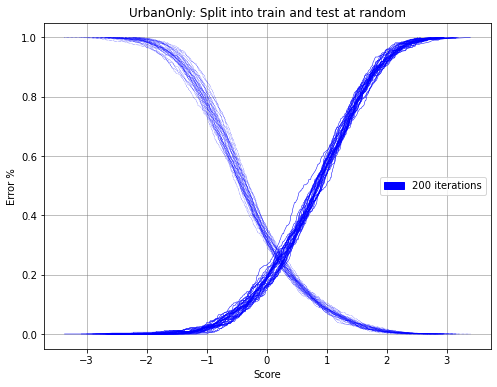

In [11]:
# Only for Urban Areas now
urban=True
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.3
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=200
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log200,
        'style':['b:','b-'],
        'label':'200 iterations',
        'label_color':'b'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Checkpoint_{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))



[0]	train-error:0.33399	train-logloss:0.67258	train-auc:0.69743	train-f1:0.00000	eval-error:0.37872	eval-logloss:0.67734	eval-auc:0.65594	eval-f1:0.00000
[1]	train-error:0.29288	train-logloss:0.65666	train-auc:0.74722	train-f1:0.00000	eval-error:0.33318	eval-logloss:0.66577	eval-auc:0.69400	eval-f1:0.00000
[2]	train-error:0.29288	train-logloss:0.64133	train-auc:0.76539	train-f1:0.00285	eval-error:0.34340	eval-logloss:0.65422	eval-auc:0.71035	eval-f1:0.00346
[3]	train-error:0.28167	train-logloss:0.62799	train-auc:0.78180	train-f1:0.04800	eval-error:0.33039	eval-logloss:0.64396	eval-auc:0.72476	eval-f1:0.03895
[4]	train-error:0.27124	train-logloss:0.61728	train-auc:0.79228	train-f1:0.26509	eval-error:0.33039	eval-logloss:0.63716	eval-auc:0.72796	eval-f1:0.24631
[5]	train-error:0.26770	train-logloss:0.60733	train-auc:0.80292	train-f1:0.52223	eval-error:0.31877	eval-logloss:0.63034	eval-auc:0.73780	eval-f1:0.48218
[6]	train-error:0.25472	train-logloss:0.59871	train-auc:0.81460	train-f1:0.4

[53]	train-error:0.15991	train-logloss:0.42676	train-auc:0.92412	train-f1:0.82937	eval-error:0.28578	eval-logloss:0.56698	eval-auc:0.77651	eval-f1:0.68853
[54]	train-error:0.15755	train-logloss:0.42447	train-auc:0.92584	train-f1:0.82833	eval-error:0.28625	eval-logloss:0.56668	eval-auc:0.77694	eval-f1:0.68660
[55]	train-error:0.15559	train-logloss:0.42251	train-auc:0.92701	train-f1:0.82845	eval-error:0.28857	eval-logloss:0.56629	eval-auc:0.77727	eval-f1:0.68278
[56]	train-error:0.15480	train-logloss:0.42078	train-auc:0.92815	train-f1:0.82885	eval-error:0.28810	eval-logloss:0.56591	eval-auc:0.77759	eval-f1:0.68120
[57]	train-error:0.15146	train-logloss:0.41896	train-auc:0.92914	train-f1:0.83104	eval-error:0.28764	eval-logloss:0.56570	eval-auc:0.77740	eval-f1:0.67924
[58]	train-error:0.14910	train-logloss:0.41645	train-auc:0.93065	train-f1:0.83425	eval-error:0.28857	eval-logloss:0.56531	eval-auc:0.77794	eval-f1:0.67961
[59]	train-error:0.14693	train-logloss:0.41473	train-auc:0.93164	train

[106]	train-error:0.09599	train-logloss:0.33545	train-auc:0.96564	train-f1:0.88504	eval-error:0.28578	eval-logloss:0.55488	eval-auc:0.78742	eval-f1:0.70599
[107]	train-error:0.09441	train-logloss:0.33428	train-auc:0.96603	train-f1:0.88631	eval-error:0.28485	eval-logloss:0.55540	eval-auc:0.78690	eval-f1:0.70505
[108]	train-error:0.09422	train-logloss:0.33333	train-auc:0.96638	train-f1:0.88601	eval-error:0.28485	eval-logloss:0.55517	eval-auc:0.78718	eval-f1:0.70599
[109]	train-error:0.09343	train-logloss:0.33208	train-auc:0.96692	train-f1:0.88606	eval-error:0.28439	eval-logloss:0.55517	eval-auc:0.78725	eval-f1:0.70810
[110]	train-error:0.09146	train-logloss:0.33016	train-auc:0.96762	train-f1:0.88796	eval-error:0.28485	eval-logloss:0.55527	eval-auc:0.78725	eval-f1:0.70477
[111]	train-error:0.09186	train-logloss:0.32876	train-auc:0.96795	train-f1:0.88834	eval-error:0.28439	eval-logloss:0.55591	eval-auc:0.78670	eval-f1:0.70505
[112]	train-error:0.09146	train-logloss:0.32740	train-auc:0.9684

[159]	train-error:0.06825	train-logloss:0.28287	train-auc:0.98117	train-f1:0.91377	eval-error:0.28206	eval-logloss:0.55315	eval-auc:0.79085	eval-f1:0.71869
[160]	train-error:0.06747	train-logloss:0.28163	train-auc:0.98140	train-f1:0.91540	eval-error:0.28253	eval-logloss:0.55336	eval-auc:0.79075	eval-f1:0.71542
[161]	train-error:0.06766	train-logloss:0.28087	train-auc:0.98154	train-f1:0.91560	eval-error:0.28392	eval-logloss:0.55390	eval-auc:0.79042	eval-f1:0.71542
[162]	train-error:0.06668	train-logloss:0.27979	train-auc:0.98186	train-f1:0.91560	eval-error:0.28253	eval-logloss:0.55410	eval-auc:0.79009	eval-f1:0.71569
[163]	train-error:0.06530	train-logloss:0.27831	train-auc:0.98207	train-f1:0.91548	eval-error:0.28532	eval-logloss:0.55361	eval-auc:0.79058	eval-f1:0.71663
[164]	train-error:0.06412	train-logloss:0.27707	train-auc:0.98259	train-f1:0.91596	eval-error:0.28578	eval-logloss:0.55362	eval-auc:0.79070	eval-f1:0.71869
[165]	train-error:0.06373	train-logloss:0.27595	train-auc:0.9830

[12]	train-error:0.24390	train-logloss:0.56045	train-auc:0.83666	train-f1:0.65931	eval-error:0.31041	eval-logloss:0.60109	eval-auc:0.75969	eval-f1:0.59009
[13]	train-error:0.23722	train-logloss:0.55439	train-auc:0.84285	train-f1:0.66994	eval-error:0.30716	eval-logloss:0.59852	eval-auc:0.76290	eval-f1:0.59795
[14]	train-error:0.23564	train-logloss:0.54908	train-auc:0.84422	train-f1:0.68230	eval-error:0.30251	eval-logloss:0.59579	eval-auc:0.76330	eval-f1:0.60842
[15]	train-error:0.23426	train-logloss:0.54574	train-auc:0.84697	train-f1:0.68185	eval-error:0.29972	eval-logloss:0.59442	eval-auc:0.76485	eval-f1:0.61367
[16]	train-error:0.22994	train-logloss:0.54077	train-auc:0.85041	train-f1:0.69067	eval-error:0.30065	eval-logloss:0.59284	eval-auc:0.76491	eval-f1:0.62792
[17]	train-error:0.22856	train-logloss:0.53585	train-auc:0.85502	train-f1:0.69970	eval-error:0.30112	eval-logloss:0.59182	eval-auc:0.76398	eval-f1:0.62257
[18]	train-error:0.22541	train-logloss:0.53217	train-auc:0.85810	train

[65]	train-error:0.14850	train-logloss:0.41703	train-auc:0.93447	train-f1:0.83373	eval-error:0.29043	eval-logloss:0.56158	eval-auc:0.78313	eval-f1:0.69152
[66]	train-error:0.14674	train-logloss:0.41490	train-auc:0.93524	train-f1:0.83390	eval-error:0.28950	eval-logloss:0.55996	eval-auc:0.78444	eval-f1:0.69309
[67]	train-error:0.14536	train-logloss:0.41334	train-auc:0.93627	train-f1:0.83367	eval-error:0.28996	eval-logloss:0.55937	eval-auc:0.78480	eval-f1:0.69342
[68]	train-error:0.14457	train-logloss:0.41178	train-auc:0.93701	train-f1:0.83533	eval-error:0.28996	eval-logloss:0.55951	eval-auc:0.78474	eval-f1:0.69527
[69]	train-error:0.14339	train-logloss:0.40960	train-auc:0.93785	train-f1:0.83708	eval-error:0.28810	eval-logloss:0.55931	eval-auc:0.78475	eval-f1:0.69498
[70]	train-error:0.14260	train-logloss:0.40824	train-auc:0.93874	train-f1:0.84094	eval-error:0.28764	eval-logloss:0.55893	eval-auc:0.78496	eval-f1:0.69494
[71]	train-error:0.13906	train-logloss:0.40637	train-auc:0.93959	train

[118]	train-error:0.09481	train-logloss:0.33761	train-auc:0.96894	train-f1:0.88403	eval-error:0.28020	eval-logloss:0.55163	eval-auc:0.79028	eval-f1:0.70091
[119]	train-error:0.09520	train-logloss:0.33679	train-auc:0.96911	train-f1:0.88464	eval-error:0.28067	eval-logloss:0.55131	eval-auc:0.79089	eval-f1:0.70192
[120]	train-error:0.09422	train-logloss:0.33513	train-auc:0.96969	train-f1:0.88567	eval-error:0.28253	eval-logloss:0.55174	eval-auc:0.79051	eval-f1:0.70164
[121]	train-error:0.09441	train-logloss:0.33431	train-auc:0.96991	train-f1:0.88585	eval-error:0.28206	eval-logloss:0.55133	eval-auc:0.79089	eval-f1:0.70226
[122]	train-error:0.09068	train-logloss:0.33219	train-auc:0.97067	train-f1:0.88846	eval-error:0.28113	eval-logloss:0.55047	eval-auc:0.79179	eval-f1:0.70594
[123]	train-error:0.09048	train-logloss:0.33132	train-auc:0.97091	train-f1:0.88936	eval-error:0.28113	eval-logloss:0.55087	eval-auc:0.79157	eval-f1:0.70622
[124]	train-error:0.08930	train-logloss:0.33039	train-auc:0.9712

[171]	train-error:0.06373	train-logloss:0.28191	train-auc:0.98400	train-f1:0.92249	eval-error:0.27742	eval-logloss:0.55141	eval-auc:0.79159	eval-f1:0.69462
[172]	train-error:0.06334	train-logloss:0.28120	train-auc:0.98411	train-f1:0.92249	eval-error:0.27742	eval-logloss:0.55129	eval-auc:0.79170	eval-f1:0.69710
[173]	train-error:0.06216	train-logloss:0.27999	train-auc:0.98437	train-f1:0.92290	eval-error:0.27835	eval-logloss:0.55140	eval-auc:0.79178	eval-f1:0.69747
[174]	train-error:0.06334	train-logloss:0.27862	train-auc:0.98458	train-f1:0.92328	eval-error:0.27742	eval-logloss:0.55210	eval-auc:0.79123	eval-f1:0.69685
[175]	train-error:0.06196	train-logloss:0.27735	train-auc:0.98488	train-f1:0.92311	eval-error:0.27695	eval-logloss:0.55246	eval-auc:0.79076	eval-f1:0.69528
[176]	train-error:0.06176	train-logloss:0.27681	train-auc:0.98498	train-f1:0.92372	eval-error:0.27695	eval-logloss:0.55205	eval-auc:0.79110	eval-f1:0.69619
[177]	train-error:0.06137	train-logloss:0.27518	train-auc:0.9852

[24]	train-error:0.22817	train-logloss:0.51530	train-auc:0.86730	train-f1:0.73353	eval-error:0.28718	eval-logloss:0.57937	eval-auc:0.77331	eval-f1:0.63347
[25]	train-error:0.22089	train-logloss:0.51079	train-auc:0.87120	train-f1:0.73995	eval-error:0.29136	eval-logloss:0.57859	eval-auc:0.77373	eval-f1:0.63934
[26]	train-error:0.21971	train-logloss:0.50746	train-auc:0.87300	train-f1:0.74541	eval-error:0.29043	eval-logloss:0.57708	eval-auc:0.77422	eval-f1:0.63980
[27]	train-error:0.21676	train-logloss:0.50491	train-auc:0.87528	train-f1:0.74715	eval-error:0.28857	eval-logloss:0.57579	eval-auc:0.77540	eval-f1:0.64228
[28]	train-error:0.21853	train-logloss:0.50262	train-auc:0.87673	train-f1:0.75042	eval-error:0.29089	eval-logloss:0.57512	eval-auc:0.77563	eval-f1:0.64575
[29]	train-error:0.21361	train-logloss:0.49960	train-auc:0.87837	train-f1:0.75472	eval-error:0.29043	eval-logloss:0.57463	eval-auc:0.77564	eval-f1:0.65290
[30]	train-error:0.21322	train-logloss:0.49579	train-auc:0.88084	train

[77]	train-error:0.15086	train-logloss:0.40423	train-auc:0.93578	train-f1:0.83330	eval-error:0.27277	eval-logloss:0.54855	eval-auc:0.79427	eval-f1:0.68283
[78]	train-error:0.14949	train-logloss:0.40259	train-auc:0.93664	train-f1:0.83603	eval-error:0.27091	eval-logloss:0.54787	eval-auc:0.79496	eval-f1:0.68411
[79]	train-error:0.14850	train-logloss:0.40145	train-auc:0.93708	train-f1:0.83751	eval-error:0.27184	eval-logloss:0.54770	eval-auc:0.79497	eval-f1:0.68255
[80]	train-error:0.14733	train-logloss:0.40038	train-auc:0.93731	train-f1:0.83744	eval-error:0.27184	eval-logloss:0.54792	eval-auc:0.79471	eval-f1:0.67996
[81]	train-error:0.14477	train-logloss:0.39853	train-auc:0.93843	train-f1:0.84035	eval-error:0.27370	eval-logloss:0.54766	eval-auc:0.79475	eval-f1:0.68058
[82]	train-error:0.14162	train-logloss:0.39679	train-auc:0.93930	train-f1:0.84054	eval-error:0.27323	eval-logloss:0.54767	eval-auc:0.79472	eval-f1:0.68217
[83]	train-error:0.14162	train-logloss:0.39553	train-auc:0.93980	train

[130]	train-error:0.09540	train-logloss:0.33106	train-auc:0.96908	train-f1:0.88552	eval-error:0.26812	eval-logloss:0.53813	eval-auc:0.80166	eval-f1:0.71060
[131]	train-error:0.09520	train-logloss:0.33034	train-auc:0.96938	train-f1:0.88508	eval-error:0.26673	eval-logloss:0.53830	eval-auc:0.80140	eval-f1:0.71128
[132]	train-error:0.09422	train-logloss:0.32935	train-auc:0.96989	train-f1:0.88464	eval-error:0.26673	eval-logloss:0.53822	eval-auc:0.80135	eval-f1:0.71005
[133]	train-error:0.09402	train-logloss:0.32852	train-auc:0.97000	train-f1:0.88622	eval-error:0.26812	eval-logloss:0.53810	eval-auc:0.80142	eval-f1:0.70695
[134]	train-error:0.09382	train-logloss:0.32778	train-auc:0.97024	train-f1:0.88674	eval-error:0.26859	eval-logloss:0.53784	eval-auc:0.80165	eval-f1:0.70797
[135]	train-error:0.09284	train-logloss:0.32701	train-auc:0.97054	train-f1:0.88679	eval-error:0.26952	eval-logloss:0.53806	eval-auc:0.80139	eval-f1:0.70543
[136]	train-error:0.09323	train-logloss:0.32593	train-auc:0.9709

[183]	train-error:0.06629	train-logloss:0.28033	train-auc:0.98496	train-f1:0.91697	eval-error:0.27091	eval-logloss:0.53658	eval-auc:0.80228	eval-f1:0.70498
[184]	train-error:0.06609	train-logloss:0.27954	train-auc:0.98529	train-f1:0.91784	eval-error:0.27137	eval-logloss:0.53666	eval-auc:0.80230	eval-f1:0.70402
[185]	train-error:0.06589	train-logloss:0.27894	train-auc:0.98539	train-f1:0.91763	eval-error:0.27184	eval-logloss:0.53731	eval-auc:0.80174	eval-f1:0.70273
[186]	train-error:0.06452	train-logloss:0.27792	train-auc:0.98557	train-f1:0.91781	eval-error:0.27231	eval-logloss:0.53699	eval-auc:0.80205	eval-f1:0.70206
[187]	train-error:0.06432	train-logloss:0.27742	train-auc:0.98567	train-f1:0.91844	eval-error:0.27231	eval-logloss:0.53695	eval-auc:0.80216	eval-f1:0.70206
[188]	train-error:0.06412	train-logloss:0.27659	train-auc:0.98587	train-f1:0.91865	eval-error:0.27323	eval-logloss:0.53681	eval-auc:0.80229	eval-f1:0.70268
[189]	train-error:0.06373	train-logloss:0.27600	train-auc:0.9860

[36]	train-error:0.18883	train-logloss:0.47843	train-auc:0.89479	train-f1:0.77026	eval-error:0.29182	eval-logloss:0.57705	eval-auc:0.77115	eval-f1:0.65361
[37]	train-error:0.18981	train-logloss:0.47636	train-auc:0.89596	train-f1:0.77019	eval-error:0.29136	eval-logloss:0.57695	eval-auc:0.77133	eval-f1:0.65296
[38]	train-error:0.18607	train-logloss:0.47439	train-auc:0.89740	train-f1:0.76846	eval-error:0.28996	eval-logloss:0.57573	eval-auc:0.77272	eval-f1:0.65093
[39]	train-error:0.18411	train-logloss:0.47051	train-auc:0.90006	train-f1:0.77094	eval-error:0.28532	eval-logloss:0.57482	eval-auc:0.77361	eval-f1:0.66033
[40]	train-error:0.18155	train-logloss:0.46831	train-auc:0.90096	train-f1:0.77355	eval-error:0.28764	eval-logloss:0.57424	eval-auc:0.77369	eval-f1:0.66268
[41]	train-error:0.17958	train-logloss:0.46557	train-auc:0.90241	train-f1:0.77566	eval-error:0.28439	eval-logloss:0.57461	eval-auc:0.77305	eval-f1:0.65534
[42]	train-error:0.17919	train-logloss:0.46223	train-auc:0.90498	train

[89]	train-error:0.11389	train-logloss:0.37646	train-auc:0.95303	train-f1:0.85020	eval-error:0.27835	eval-logloss:0.55716	eval-auc:0.78605	eval-f1:0.69654
[90]	train-error:0.11467	train-logloss:0.37476	train-auc:0.95354	train-f1:0.85305	eval-error:0.28160	eval-logloss:0.55636	eval-auc:0.78677	eval-f1:0.69946
[91]	train-error:0.11192	train-logloss:0.37325	train-auc:0.95444	train-f1:0.85183	eval-error:0.28439	eval-logloss:0.55637	eval-auc:0.78669	eval-f1:0.69878
[92]	train-error:0.11113	train-logloss:0.37171	train-auc:0.95509	train-f1:0.85328	eval-error:0.28299	eval-logloss:0.55605	eval-auc:0.78695	eval-f1:0.69874
[93]	train-error:0.11035	train-logloss:0.37044	train-auc:0.95569	train-f1:0.85490	eval-error:0.28346	eval-logloss:0.55637	eval-auc:0.78664	eval-f1:0.69743
[94]	train-error:0.10995	train-logloss:0.36944	train-auc:0.95602	train-f1:0.85449	eval-error:0.28578	eval-logloss:0.55675	eval-auc:0.78626	eval-f1:0.69874
[95]	train-error:0.10976	train-logloss:0.36734	train-auc:0.95704	train

[142]	train-error:0.07573	train-logloss:0.30826	train-auc:0.97704	train-f1:0.89890	eval-error:0.28020	eval-logloss:0.55296	eval-auc:0.78907	eval-f1:0.70116
[143]	train-error:0.07592	train-logloss:0.30775	train-auc:0.97716	train-f1:0.89977	eval-error:0.28020	eval-logloss:0.55304	eval-auc:0.78901	eval-f1:0.70111
[144]	train-error:0.07474	train-logloss:0.30697	train-auc:0.97738	train-f1:0.89994	eval-error:0.28160	eval-logloss:0.55349	eval-auc:0.78866	eval-f1:0.70135
[145]	train-error:0.07494	train-logloss:0.30593	train-auc:0.97761	train-f1:0.90045	eval-error:0.28253	eval-logloss:0.55350	eval-auc:0.78871	eval-f1:0.70169
[146]	train-error:0.07435	train-logloss:0.30538	train-auc:0.97779	train-f1:0.90145	eval-error:0.28160	eval-logloss:0.55343	eval-auc:0.78873	eval-f1:0.70135
[147]	train-error:0.07376	train-logloss:0.30480	train-auc:0.97794	train-f1:0.90084	eval-error:0.28253	eval-logloss:0.55352	eval-auc:0.78863	eval-f1:0.70226
[148]	train-error:0.07317	train-logloss:0.30359	train-auc:0.9782

[195]	train-error:0.05134	train-logloss:0.26170	train-auc:0.98789	train-f1:0.92839	eval-error:0.27927	eval-logloss:0.55307	eval-auc:0.79012	eval-f1:0.69814
[196]	train-error:0.05153	train-logloss:0.26122	train-auc:0.98797	train-f1:0.92916	eval-error:0.27927	eval-logloss:0.55316	eval-auc:0.79010	eval-f1:0.70033
[197]	train-error:0.05114	train-logloss:0.26039	train-auc:0.98804	train-f1:0.92960	eval-error:0.27927	eval-logloss:0.55284	eval-auc:0.79030	eval-f1:0.70062
[198]	train-error:0.05134	train-logloss:0.25950	train-auc:0.98821	train-f1:0.93124	eval-error:0.28160	eval-logloss:0.55316	eval-auc:0.79012	eval-f1:0.70062
[199]	train-error:0.05035	train-logloss:0.25860	train-auc:0.98837	train-f1:0.93224	eval-error:0.28113	eval-logloss:0.55336	eval-auc:0.79014	eval-f1:0.70029
[0]	train-error:0.32651	train-logloss:0.67428	train-auc:0.68375	train-f1:0.00000	eval-error:0.37082	eval-logloss:0.67950	eval-auc:0.63844	eval-f1:0.00000
[1]	train-error:0.32179	train-logloss:0.66019	train-auc:0.72786	tr

[48]	train-error:0.17309	train-logloss:0.45446	train-auc:0.91061	train-f1:0.80261	eval-error:0.28903	eval-logloss:0.56600	eval-auc:0.78142	eval-f1:0.68490
[49]	train-error:0.17152	train-logloss:0.45284	train-auc:0.91149	train-f1:0.80425	eval-error:0.28996	eval-logloss:0.56533	eval-auc:0.78208	eval-f1:0.68588
[50]	train-error:0.17152	train-logloss:0.45100	train-auc:0.91250	train-f1:0.80628	eval-error:0.28950	eval-logloss:0.56476	eval-auc:0.78232	eval-f1:0.68137
[51]	train-error:0.16896	train-logloss:0.44854	train-auc:0.91352	train-f1:0.80506	eval-error:0.28996	eval-logloss:0.56418	eval-auc:0.78231	eval-f1:0.68041
[52]	train-error:0.16759	train-logloss:0.44505	train-auc:0.91581	train-f1:0.80894	eval-error:0.28810	eval-logloss:0.56431	eval-auc:0.78136	eval-f1:0.67838
[53]	train-error:0.16562	train-logloss:0.44298	train-auc:0.91730	train-f1:0.81071	eval-error:0.28903	eval-logloss:0.56358	eval-auc:0.78211	eval-f1:0.68033
[54]	train-error:0.16306	train-logloss:0.44087	train-auc:0.91867	train

[101]	train-error:0.10779	train-logloss:0.36259	train-auc:0.95815	train-f1:0.86046	eval-error:0.28206	eval-logloss:0.55460	eval-auc:0.78724	eval-f1:0.70937
[102]	train-error:0.10779	train-logloss:0.36185	train-auc:0.95851	train-f1:0.86079	eval-error:0.28206	eval-logloss:0.55479	eval-auc:0.78682	eval-f1:0.70992
[103]	train-error:0.10818	train-logloss:0.36060	train-auc:0.95888	train-f1:0.86152	eval-error:0.28299	eval-logloss:0.55470	eval-auc:0.78666	eval-f1:0.70897
[104]	train-error:0.10622	train-logloss:0.35894	train-auc:0.95966	train-f1:0.86298	eval-error:0.28160	eval-logloss:0.55407	eval-auc:0.78718	eval-f1:0.70937
[105]	train-error:0.10484	train-logloss:0.35670	train-auc:0.96074	train-f1:0.86393	eval-error:0.28206	eval-logloss:0.55327	eval-auc:0.78776	eval-f1:0.70853
[106]	train-error:0.10346	train-logloss:0.35552	train-auc:0.96133	train-f1:0.86544	eval-error:0.28206	eval-logloss:0.55343	eval-auc:0.78755	eval-f1:0.70723
[107]	train-error:0.10248	train-logloss:0.35440	train-auc:0.9618

[154]	train-error:0.07179	train-logloss:0.29936	train-auc:0.97999	train-f1:0.90728	eval-error:0.27602	eval-logloss:0.55112	eval-auc:0.79083	eval-f1:0.70755
[155]	train-error:0.07101	train-logloss:0.29859	train-auc:0.98020	train-f1:0.90773	eval-error:0.27602	eval-logloss:0.55068	eval-auc:0.79110	eval-f1:0.70727
[156]	train-error:0.07101	train-logloss:0.29755	train-auc:0.98048	train-f1:0.90853	eval-error:0.27463	eval-logloss:0.55063	eval-auc:0.79108	eval-f1:0.70599
[157]	train-error:0.07081	train-logloss:0.29687	train-auc:0.98064	train-f1:0.90832	eval-error:0.27556	eval-logloss:0.55070	eval-auc:0.79099	eval-f1:0.70477
[158]	train-error:0.07022	train-logloss:0.29599	train-auc:0.98086	train-f1:0.90996	eval-error:0.27556	eval-logloss:0.55076	eval-auc:0.79096	eval-f1:0.70660
[159]	train-error:0.06963	train-logloss:0.29507	train-auc:0.98105	train-f1:0.91121	eval-error:0.27509	eval-logloss:0.55092	eval-auc:0.79073	eval-f1:0.70594
[160]	train-error:0.06943	train-logloss:0.29426	train-auc:0.9812

[7]	train-error:0.27714	train-logloss:0.60091	train-auc:0.81044	train-f1:0.50309	eval-error:0.30623	eval-logloss:0.62315	eval-auc:0.75186	eval-f1:0.44334
[8]	train-error:0.27400	train-logloss:0.59274	train-auc:0.81527	train-f1:0.55255	eval-error:0.31645	eval-logloss:0.61945	eval-auc:0.75128	eval-f1:0.48101
[9]	train-error:0.26495	train-logloss:0.58643	train-auc:0.82108	train-f1:0.59957	eval-error:0.31738	eval-logloss:0.61571	eval-auc:0.75466	eval-f1:0.52510
[10]	train-error:0.26397	train-logloss:0.58075	train-auc:0.82277	train-f1:0.61578	eval-error:0.31738	eval-logloss:0.61337	eval-auc:0.75355	eval-f1:0.53614
[11]	train-error:0.26082	train-logloss:0.57549	train-auc:0.82586	train-f1:0.62668	eval-error:0.31877	eval-logloss:0.61050	eval-auc:0.75449	eval-f1:0.55265
[12]	train-error:0.25708	train-logloss:0.56888	train-auc:0.83118	train-f1:0.64044	eval-error:0.30948	eval-logloss:0.60591	eval-auc:0.75770	eval-f1:0.57299
[13]	train-error:0.25688	train-logloss:0.56392	train-auc:0.83612	train-f1

[60]	train-error:0.15795	train-logloss:0.43527	train-auc:0.92533	train-f1:0.81375	eval-error:0.28206	eval-logloss:0.56338	eval-auc:0.78167	eval-f1:0.67833
[61]	train-error:0.15696	train-logloss:0.43334	train-auc:0.92657	train-f1:0.81557	eval-error:0.28067	eval-logloss:0.56309	eval-auc:0.78187	eval-f1:0.67736
[62]	train-error:0.15618	train-logloss:0.43156	train-auc:0.92776	train-f1:0.81788	eval-error:0.28113	eval-logloss:0.56324	eval-auc:0.78161	eval-f1:0.67769
[63]	train-error:0.15519	train-logloss:0.43007	train-auc:0.92888	train-f1:0.81504	eval-error:0.28020	eval-logloss:0.56248	eval-auc:0.78235	eval-f1:0.67862
[64]	train-error:0.15303	train-logloss:0.42753	train-auc:0.93031	train-f1:0.81764	eval-error:0.27974	eval-logloss:0.56217	eval-auc:0.78259	eval-f1:0.67831
[65]	train-error:0.15185	train-logloss:0.42508	train-auc:0.93171	train-f1:0.82058	eval-error:0.28020	eval-logloss:0.56208	eval-auc:0.78247	eval-f1:0.67444
[66]	train-error:0.14988	train-logloss:0.42366	train-auc:0.93273	train

[113]	train-error:0.09815	train-logloss:0.35645	train-auc:0.96432	train-f1:0.87695	eval-error:0.26905	eval-logloss:0.55296	eval-auc:0.78816	eval-f1:0.68335
[114]	train-error:0.09658	train-logloss:0.35539	train-auc:0.96484	train-f1:0.87735	eval-error:0.26952	eval-logloss:0.55315	eval-auc:0.78800	eval-f1:0.68398
[115]	train-error:0.09599	train-logloss:0.35323	train-auc:0.96563	train-f1:0.87951	eval-error:0.27137	eval-logloss:0.55270	eval-auc:0.78836	eval-f1:0.68939
[116]	train-error:0.09559	train-logloss:0.35131	train-auc:0.96627	train-f1:0.87973	eval-error:0.27137	eval-logloss:0.55339	eval-auc:0.78760	eval-f1:0.68819
[117]	train-error:0.09500	train-logloss:0.35053	train-auc:0.96660	train-f1:0.88092	eval-error:0.27091	eval-logloss:0.55316	eval-auc:0.78768	eval-f1:0.68849
[118]	train-error:0.09323	train-logloss:0.34910	train-auc:0.96715	train-f1:0.88144	eval-error:0.27137	eval-logloss:0.55366	eval-auc:0.78727	eval-f1:0.69009
[119]	train-error:0.09382	train-logloss:0.34760	train-auc:0.9676

[166]	train-error:0.06137	train-logloss:0.29518	train-auc:0.98204	train-f1:0.90916	eval-error:0.27463	eval-logloss:0.55365	eval-auc:0.78836	eval-f1:0.69536
[167]	train-error:0.06157	train-logloss:0.29399	train-auc:0.98216	train-f1:0.90832	eval-error:0.27184	eval-logloss:0.55321	eval-auc:0.78894	eval-f1:0.69569
[168]	train-error:0.06039	train-logloss:0.29252	train-auc:0.98245	train-f1:0.91057	eval-error:0.27091	eval-logloss:0.55369	eval-auc:0.78839	eval-f1:0.69349
[169]	train-error:0.05980	train-logloss:0.29198	train-auc:0.98266	train-f1:0.91036	eval-error:0.27091	eval-logloss:0.55335	eval-auc:0.78877	eval-f1:0.69411
[170]	train-error:0.05940	train-logloss:0.29104	train-auc:0.98282	train-f1:0.91180	eval-error:0.27045	eval-logloss:0.55337	eval-auc:0.78861	eval-f1:0.69444
[171]	train-error:0.05940	train-logloss:0.29036	train-auc:0.98294	train-f1:0.91201	eval-error:0.27091	eval-logloss:0.55356	eval-auc:0.78843	eval-f1:0.69411
[172]	train-error:0.06019	train-logloss:0.28903	train-auc:0.9831

[19]	train-error:0.22856	train-logloss:0.53393	train-auc:0.85501	train-f1:0.70104	eval-error:0.29507	eval-logloss:0.58657	eval-auc:0.77131	eval-f1:0.64099
[20]	train-error:0.22640	train-logloss:0.53039	train-auc:0.85848	train-f1:0.70955	eval-error:0.29414	eval-logloss:0.58549	eval-auc:0.77251	eval-f1:0.64344
[21]	train-error:0.22187	train-logloss:0.52667	train-auc:0.86244	train-f1:0.71897	eval-error:0.29461	eval-logloss:0.58449	eval-auc:0.77280	eval-f1:0.64209
[22]	train-error:0.21577	train-logloss:0.52238	train-auc:0.86544	train-f1:0.72266	eval-error:0.28810	eval-logloss:0.58331	eval-auc:0.77364	eval-f1:0.64282
[23]	train-error:0.21813	train-logloss:0.51783	train-auc:0.86769	train-f1:0.73224	eval-error:0.28764	eval-logloss:0.58159	eval-auc:0.77408	eval-f1:0.64868
[24]	train-error:0.21086	train-logloss:0.51431	train-auc:0.87076	train-f1:0.73707	eval-error:0.28671	eval-logloss:0.58030	eval-auc:0.77510	eval-f1:0.64870
[25]	train-error:0.20751	train-logloss:0.51010	train-auc:0.87278	train

[72]	train-error:0.12923	train-logloss:0.40290	train-auc:0.94061	train-f1:0.83239	eval-error:0.27835	eval-logloss:0.55809	eval-auc:0.78582	eval-f1:0.68411
[73]	train-error:0.12844	train-logloss:0.40157	train-auc:0.94146	train-f1:0.83192	eval-error:0.27788	eval-logloss:0.55729	eval-auc:0.78656	eval-f1:0.68444
[74]	train-error:0.12549	train-logloss:0.40025	train-auc:0.94247	train-f1:0.83273	eval-error:0.27974	eval-logloss:0.55763	eval-auc:0.78607	eval-f1:0.68153
[75]	train-error:0.12549	train-logloss:0.39876	train-auc:0.94349	train-f1:0.83306	eval-error:0.27835	eval-logloss:0.55736	eval-auc:0.78616	eval-f1:0.68124
[76]	train-error:0.12412	train-logloss:0.39745	train-auc:0.94423	train-f1:0.83327	eval-error:0.28020	eval-logloss:0.55767	eval-auc:0.78576	eval-f1:0.68122
[77]	train-error:0.12254	train-logloss:0.39608	train-auc:0.94491	train-f1:0.83417	eval-error:0.27974	eval-logloss:0.55749	eval-auc:0.78581	eval-f1:0.68155
[78]	train-error:0.12215	train-logloss:0.39445	train-auc:0.94572	train

[125]	train-error:0.07868	train-logloss:0.32480	train-auc:0.97302	train-f1:0.88428	eval-error:0.27695	eval-logloss:0.54909	eval-auc:0.79268	eval-f1:0.70005
[126]	train-error:0.07888	train-logloss:0.32306	train-auc:0.97351	train-f1:0.88571	eval-error:0.27649	eval-logloss:0.54857	eval-auc:0.79314	eval-f1:0.70195
[127]	train-error:0.07868	train-logloss:0.32213	train-auc:0.97383	train-f1:0.88615	eval-error:0.27556	eval-logloss:0.54858	eval-auc:0.79316	eval-f1:0.70224
[128]	train-error:0.07770	train-logloss:0.32045	train-auc:0.97429	train-f1:0.88654	eval-error:0.27416	eval-logloss:0.54837	eval-auc:0.79328	eval-f1:0.70162
[129]	train-error:0.07612	train-logloss:0.31886	train-auc:0.97493	train-f1:0.88863	eval-error:0.27370	eval-logloss:0.54832	eval-auc:0.79322	eval-f1:0.70043
[130]	train-error:0.07632	train-logloss:0.31810	train-auc:0.97510	train-f1:0.88902	eval-error:0.27370	eval-logloss:0.54765	eval-auc:0.79380	eval-f1:0.69981
[131]	train-error:0.07612	train-logloss:0.31706	train-auc:0.9753

[178]	train-error:0.05389	train-logloss:0.26640	train-auc:0.98737	train-f1:0.92299	eval-error:0.27556	eval-logloss:0.54634	eval-auc:0.79546	eval-f1:0.71017
[179]	train-error:0.05271	train-logloss:0.26571	train-auc:0.98746	train-f1:0.92299	eval-error:0.27695	eval-logloss:0.54620	eval-auc:0.79561	eval-f1:0.70922
[180]	train-error:0.05193	train-logloss:0.26513	train-auc:0.98757	train-f1:0.92278	eval-error:0.27742	eval-logloss:0.54624	eval-auc:0.79553	eval-f1:0.70861
[181]	train-error:0.05153	train-logloss:0.26432	train-auc:0.98774	train-f1:0.92319	eval-error:0.27788	eval-logloss:0.54623	eval-auc:0.79558	eval-f1:0.70888
[182]	train-error:0.05153	train-logloss:0.26355	train-auc:0.98784	train-f1:0.92319	eval-error:0.27742	eval-logloss:0.54618	eval-auc:0.79563	eval-f1:0.70855
[183]	train-error:0.05173	train-logloss:0.26212	train-auc:0.98817	train-f1:0.92540	eval-error:0.27649	eval-logloss:0.54612	eval-auc:0.79557	eval-f1:0.71098
[184]	train-error:0.05094	train-logloss:0.26090	train-auc:0.9884

[31]	train-error:0.20732	train-logloss:0.49240	train-auc:0.88771	train-f1:0.76420	eval-error:0.29229	eval-logloss:0.57395	eval-auc:0.77846	eval-f1:0.64757
[32]	train-error:0.20594	train-logloss:0.48874	train-auc:0.88979	train-f1:0.76530	eval-error:0.29043	eval-logloss:0.57268	eval-auc:0.77916	eval-f1:0.65036
[33]	train-error:0.20535	train-logloss:0.48676	train-auc:0.89118	train-f1:0.76587	eval-error:0.29182	eval-logloss:0.57173	eval-auc:0.77970	eval-f1:0.65036
[34]	train-error:0.20201	train-logloss:0.48503	train-auc:0.89276	train-f1:0.77101	eval-error:0.29043	eval-logloss:0.57094	eval-auc:0.78051	eval-f1:0.65074
[35]	train-error:0.20122	train-logloss:0.48237	train-auc:0.89342	train-f1:0.77161	eval-error:0.28578	eval-logloss:0.56976	eval-auc:0.78132	eval-f1:0.65480
[36]	train-error:0.19768	train-logloss:0.47926	train-auc:0.89649	train-f1:0.76897	eval-error:0.28578	eval-logloss:0.56980	eval-auc:0.78083	eval-f1:0.65097
[37]	train-error:0.19355	train-logloss:0.47667	train-auc:0.89819	train

[84]	train-error:0.12077	train-logloss:0.38270	train-auc:0.95224	train-f1:0.84923	eval-error:0.27091	eval-logloss:0.55195	eval-auc:0.79073	eval-f1:0.68521
[85]	train-error:0.11920	train-logloss:0.38135	train-auc:0.95279	train-f1:0.85099	eval-error:0.26952	eval-logloss:0.55190	eval-auc:0.79067	eval-f1:0.68585
[86]	train-error:0.11743	train-logloss:0.37937	train-auc:0.95363	train-f1:0.85221	eval-error:0.26998	eval-logloss:0.55154	eval-auc:0.79097	eval-f1:0.68585
[87]	train-error:0.11703	train-logloss:0.37796	train-auc:0.95431	train-f1:0.85401	eval-error:0.26812	eval-logloss:0.55126	eval-auc:0.79110	eval-f1:0.68549
[88]	train-error:0.11467	train-logloss:0.37576	train-auc:0.95522	train-f1:0.85453	eval-error:0.26905	eval-logloss:0.55106	eval-auc:0.79105	eval-f1:0.68644
[89]	train-error:0.11448	train-logloss:0.37492	train-auc:0.95541	train-f1:0.85650	eval-error:0.27045	eval-logloss:0.55092	eval-auc:0.79088	eval-f1:0.68677
[90]	train-error:0.11625	train-logloss:0.37280	train-auc:0.95632	train

[137]	train-error:0.07533	train-logloss:0.30968	train-auc:0.97807	train-f1:0.89490	eval-error:0.26998	eval-logloss:0.55007	eval-auc:0.79107	eval-f1:0.69561
[138]	train-error:0.07455	train-logloss:0.30890	train-auc:0.97821	train-f1:0.89614	eval-error:0.26952	eval-logloss:0.54978	eval-auc:0.79138	eval-f1:0.69658
[139]	train-error:0.07435	train-logloss:0.30810	train-auc:0.97834	train-f1:0.89654	eval-error:0.26766	eval-logloss:0.54912	eval-auc:0.79204	eval-f1:0.69653
[140]	train-error:0.07396	train-logloss:0.30642	train-auc:0.97878	train-f1:0.89873	eval-error:0.27045	eval-logloss:0.54841	eval-auc:0.79274	eval-f1:0.69779
[141]	train-error:0.07337	train-logloss:0.30538	train-auc:0.97901	train-f1:0.89859	eval-error:0.27091	eval-logloss:0.54863	eval-auc:0.79257	eval-f1:0.69653
[142]	train-error:0.07278	train-logloss:0.30408	train-auc:0.97939	train-f1:0.89859	eval-error:0.27323	eval-logloss:0.54852	eval-auc:0.79272	eval-f1:0.69624
[143]	train-error:0.07120	train-logloss:0.30330	train-auc:0.9797

[190]	train-error:0.04563	train-logloss:0.25696	train-auc:0.98905	train-f1:0.92937	eval-error:0.26812	eval-logloss:0.55028	eval-auc:0.79370	eval-f1:0.70201
[191]	train-error:0.04544	train-logloss:0.25658	train-auc:0.98907	train-f1:0.92919	eval-error:0.26719	eval-logloss:0.54996	eval-auc:0.79405	eval-f1:0.70234
[192]	train-error:0.04721	train-logloss:0.25523	train-auc:0.98938	train-f1:0.93023	eval-error:0.26812	eval-logloss:0.55007	eval-auc:0.79385	eval-f1:0.70353
[193]	train-error:0.04701	train-logloss:0.25477	train-auc:0.98947	train-f1:0.93041	eval-error:0.26719	eval-logloss:0.55009	eval-auc:0.79384	eval-f1:0.70229
[194]	train-error:0.04701	train-logloss:0.25429	train-auc:0.98951	train-f1:0.93124	eval-error:0.26626	eval-logloss:0.55012	eval-auc:0.79384	eval-f1:0.70386
[195]	train-error:0.04563	train-logloss:0.25329	train-auc:0.98965	train-f1:0.93145	eval-error:0.26859	eval-logloss:0.55000	eval-auc:0.79400	eval-f1:0.70257
[196]	train-error:0.04583	train-logloss:0.25278	train-auc:0.9897

[43]	train-error:0.18765	train-logloss:0.46780	train-auc:0.89613	train-f1:0.78197	eval-error:0.28810	eval-logloss:0.57222	eval-auc:0.77567	eval-f1:0.66967
[44]	train-error:0.18647	train-logloss:0.46554	train-auc:0.89770	train-f1:0.78120	eval-error:0.29461	eval-logloss:0.57222	eval-auc:0.77527	eval-f1:0.67000
[45]	train-error:0.18509	train-logloss:0.46389	train-auc:0.89905	train-f1:0.78678	eval-error:0.29368	eval-logloss:0.57240	eval-auc:0.77485	eval-f1:0.66800
[46]	train-error:0.18273	train-logloss:0.46108	train-auc:0.90068	train-f1:0.78646	eval-error:0.29182	eval-logloss:0.57066	eval-auc:0.77584	eval-f1:0.67031
[47]	train-error:0.18253	train-logloss:0.45871	train-auc:0.90250	train-f1:0.79145	eval-error:0.29182	eval-logloss:0.56976	eval-auc:0.77662	eval-f1:0.66932
[48]	train-error:0.18273	train-logloss:0.45697	train-auc:0.90377	train-f1:0.79397	eval-error:0.29322	eval-logloss:0.56990	eval-auc:0.77631	eval-f1:0.66866
[49]	train-error:0.17939	train-logloss:0.45503	train-auc:0.90534	train

[96]	train-error:0.11546	train-logloss:0.37769	train-auc:0.95070	train-f1:0.84379	eval-error:0.28346	eval-logloss:0.55954	eval-auc:0.78376	eval-f1:0.69913
[97]	train-error:0.11349	train-logloss:0.37540	train-auc:0.95237	train-f1:0.84431	eval-error:0.28206	eval-logloss:0.55935	eval-auc:0.78384	eval-f1:0.69788
[98]	train-error:0.11349	train-logloss:0.37416	train-auc:0.95268	train-f1:0.84648	eval-error:0.28299	eval-logloss:0.55938	eval-auc:0.78375	eval-f1:0.69880
[99]	train-error:0.11408	train-logloss:0.37201	train-auc:0.95332	train-f1:0.84911	eval-error:0.28206	eval-logloss:0.55925	eval-auc:0.78393	eval-f1:0.69783
[100]	train-error:0.11271	train-logloss:0.37060	train-auc:0.95413	train-f1:0.84852	eval-error:0.28392	eval-logloss:0.55930	eval-auc:0.78374	eval-f1:0.69783
[101]	train-error:0.11113	train-logloss:0.36846	train-auc:0.95516	train-f1:0.85334	eval-error:0.28625	eval-logloss:0.55869	eval-auc:0.78450	eval-f1:0.69971
[102]	train-error:0.11212	train-logloss:0.36749	train-auc:0.95524	tr

[149]	train-error:0.07927	train-logloss:0.31209	train-auc:0.97485	train-f1:0.89182	eval-error:0.27788	eval-logloss:0.55315	eval-auc:0.78904	eval-f1:0.71347
[150]	train-error:0.07809	train-logloss:0.31130	train-auc:0.97499	train-f1:0.89279	eval-error:0.27974	eval-logloss:0.55350	eval-auc:0.78879	eval-f1:0.71353
[151]	train-error:0.07750	train-logloss:0.30940	train-auc:0.97567	train-f1:0.89270	eval-error:0.28067	eval-logloss:0.55440	eval-auc:0.78795	eval-f1:0.71190
[152]	train-error:0.07632	train-logloss:0.30859	train-auc:0.97608	train-f1:0.89279	eval-error:0.27835	eval-logloss:0.55450	eval-auc:0.78780	eval-f1:0.71094
[153]	train-error:0.07592	train-logloss:0.30788	train-auc:0.97619	train-f1:0.89367	eval-error:0.27881	eval-logloss:0.55423	eval-auc:0.78810	eval-f1:0.71066
[154]	train-error:0.07494	train-logloss:0.30668	train-auc:0.97650	train-f1:0.89389	eval-error:0.27835	eval-logloss:0.55306	eval-auc:0.78930	eval-f1:0.71011
[155]	train-error:0.07455	train-logloss:0.30593	train-auc:0.9766

[2]	train-error:0.31491	train-logloss:0.64596	train-auc:0.75498	train-f1:0.00656	eval-error:0.34154	eval-logloss:0.65550	eval-auc:0.70848	eval-f1:0.00518
[3]	train-error:0.28914	train-logloss:0.63458	train-auc:0.76380	train-f1:0.03930	eval-error:0.32760	eval-logloss:0.64728	eval-auc:0.71482	eval-f1:0.03056
[4]	train-error:0.27950	train-logloss:0.62343	train-auc:0.77371	train-f1:0.42208	eval-error:0.31738	eval-logloss:0.64061	eval-auc:0.71900	eval-f1:0.38176
[5]	train-error:0.27183	train-logloss:0.61328	train-auc:0.78567	train-f1:0.48238	eval-error:0.32063	eval-logloss:0.63374	eval-auc:0.72621	eval-f1:0.41834
[6]	train-error:0.26515	train-logloss:0.60561	train-auc:0.79509	train-f1:0.49341	eval-error:0.32110	eval-logloss:0.62953	eval-auc:0.73028	eval-f1:0.42387
[7]	train-error:0.27006	train-logloss:0.59810	train-auc:0.80005	train-f1:0.53595	eval-error:0.31645	eval-logloss:0.62302	eval-auc:0.73764	eval-f1:0.46514
[8]	train-error:0.26298	train-logloss:0.59103	train-auc:0.80815	train-f1:0.5

[55]	train-error:0.16621	train-logloss:0.44531	train-auc:0.91600	train-f1:0.79535	eval-error:0.28485	eval-logloss:0.56651	eval-auc:0.77953	eval-f1:0.65300
[56]	train-error:0.16581	train-logloss:0.44392	train-auc:0.91654	train-f1:0.79535	eval-error:0.28625	eval-logloss:0.56628	eval-auc:0.77958	eval-f1:0.65130
[57]	train-error:0.16503	train-logloss:0.44294	train-auc:0.91737	train-f1:0.79759	eval-error:0.28578	eval-logloss:0.56631	eval-auc:0.77955	eval-f1:0.65331
[58]	train-error:0.16385	train-logloss:0.44118	train-auc:0.91883	train-f1:0.79934	eval-error:0.28578	eval-logloss:0.56614	eval-auc:0.77968	eval-f1:0.65465
[59]	train-error:0.16070	train-logloss:0.43798	train-auc:0.92055	train-f1:0.79667	eval-error:0.28718	eval-logloss:0.56558	eval-auc:0.77995	eval-f1:0.65666
[60]	train-error:0.15952	train-logloss:0.43529	train-auc:0.92268	train-f1:0.80083	eval-error:0.28532	eval-logloss:0.56525	eval-auc:0.78032	eval-f1:0.65833
[61]	train-error:0.15893	train-logloss:0.43303	train-auc:0.92355	train

[108]	train-error:0.10976	train-logloss:0.36213	train-auc:0.95877	train-f1:0.85841	eval-error:0.27835	eval-logloss:0.55461	eval-auc:0.78787	eval-f1:0.67956
[109]	train-error:0.10818	train-logloss:0.36103	train-auc:0.95918	train-f1:0.86001	eval-error:0.27695	eval-logloss:0.55436	eval-auc:0.78817	eval-f1:0.68087
[110]	train-error:0.10818	train-logloss:0.35998	train-auc:0.95942	train-f1:0.85996	eval-error:0.27695	eval-logloss:0.55415	eval-auc:0.78839	eval-f1:0.68054
[111]	train-error:0.10740	train-logloss:0.35898	train-auc:0.95961	train-f1:0.86070	eval-error:0.27649	eval-logloss:0.55407	eval-auc:0.78852	eval-f1:0.68249
[112]	train-error:0.10779	train-logloss:0.35818	train-auc:0.96009	train-f1:0.86179	eval-error:0.27881	eval-logloss:0.55425	eval-auc:0.78823	eval-f1:0.68218
[113]	train-error:0.10602	train-logloss:0.35676	train-auc:0.96074	train-f1:0.86271	eval-error:0.27835	eval-logloss:0.55355	eval-auc:0.78894	eval-f1:0.68319
[114]	train-error:0.10405	train-logloss:0.35476	train-auc:0.9619

[161]	train-error:0.07396	train-logloss:0.30190	train-auc:0.97910	train-f1:0.90273	eval-error:0.27695	eval-logloss:0.55004	eval-auc:0.79209	eval-f1:0.69429
[162]	train-error:0.07396	train-logloss:0.30148	train-auc:0.97920	train-f1:0.90231	eval-error:0.27742	eval-logloss:0.55027	eval-auc:0.79192	eval-f1:0.69425
[163]	train-error:0.07356	train-logloss:0.30080	train-auc:0.97935	train-f1:0.90231	eval-error:0.27556	eval-logloss:0.55032	eval-auc:0.79188	eval-f1:0.69586
[164]	train-error:0.07317	train-logloss:0.29994	train-auc:0.97949	train-f1:0.90273	eval-error:0.27556	eval-logloss:0.55001	eval-auc:0.79213	eval-f1:0.69557
[165]	train-error:0.07337	train-logloss:0.29931	train-auc:0.97963	train-f1:0.90273	eval-error:0.27416	eval-logloss:0.55017	eval-auc:0.79211	eval-f1:0.69396
[166]	train-error:0.07297	train-logloss:0.29852	train-auc:0.97972	train-f1:0.90423	eval-error:0.27370	eval-logloss:0.54990	eval-auc:0.79231	eval-f1:0.69620
[167]	train-error:0.07297	train-logloss:0.29740	train-auc:0.9798

[14]	train-error:0.24784	train-logloss:0.55063	train-auc:0.83835	train-f1:0.66409	eval-error:0.29879	eval-logloss:0.59925	eval-auc:0.75310	eval-f1:0.59013
[15]	train-error:0.24154	train-logloss:0.54569	train-auc:0.84114	train-f1:0.66848	eval-error:0.30065	eval-logloss:0.59678	eval-auc:0.75496	eval-f1:0.59659
[16]	train-error:0.24135	train-logloss:0.54200	train-auc:0.84346	train-f1:0.68930	eval-error:0.30251	eval-logloss:0.59423	eval-auc:0.75698	eval-f1:0.61442
[17]	train-error:0.23623	train-logloss:0.53825	train-auc:0.84795	train-f1:0.69544	eval-error:0.30065	eval-logloss:0.59231	eval-auc:0.75914	eval-f1:0.60983
[18]	train-error:0.23367	train-logloss:0.53303	train-auc:0.85285	train-f1:0.70606	eval-error:0.29693	eval-logloss:0.59015	eval-auc:0.76206	eval-f1:0.61826
[19]	train-error:0.23131	train-logloss:0.52889	train-auc:0.85666	train-f1:0.71064	eval-error:0.29740	eval-logloss:0.58864	eval-auc:0.76374	eval-f1:0.62105
[20]	train-error:0.22148	train-logloss:0.52437	train-auc:0.86016	train

[67]	train-error:0.13710	train-logloss:0.40916	train-auc:0.93416	train-f1:0.82592	eval-error:0.27370	eval-logloss:0.55388	eval-auc:0.79123	eval-f1:0.68395
[68]	train-error:0.13887	train-logloss:0.40675	train-auc:0.93471	train-f1:0.82692	eval-error:0.27137	eval-logloss:0.55449	eval-auc:0.79024	eval-f1:0.68585
[69]	train-error:0.13906	train-logloss:0.40556	train-auc:0.93549	train-f1:0.82921	eval-error:0.27509	eval-logloss:0.55449	eval-auc:0.78998	eval-f1:0.68293
[70]	train-error:0.13611	train-logloss:0.40332	train-auc:0.93708	train-f1:0.83201	eval-error:0.27695	eval-logloss:0.55343	eval-auc:0.79144	eval-f1:0.68519
[71]	train-error:0.13238	train-logloss:0.40049	train-auc:0.93893	train-f1:0.83310	eval-error:0.27277	eval-logloss:0.55318	eval-auc:0.79190	eval-f1:0.68641
[72]	train-error:0.12943	train-logloss:0.39870	train-auc:0.93967	train-f1:0.83422	eval-error:0.27045	eval-logloss:0.55323	eval-auc:0.79155	eval-f1:0.68956
[73]	train-error:0.12903	train-logloss:0.39637	train-auc:0.94111	train

[120]	train-error:0.09736	train-logloss:0.33547	train-auc:0.96580	train-f1:0.88902	eval-error:0.27091	eval-logloss:0.54546	eval-auc:0.79787	eval-f1:0.70221
[121]	train-error:0.09540	train-logloss:0.33331	train-auc:0.96664	train-f1:0.89166	eval-error:0.27277	eval-logloss:0.54554	eval-auc:0.79805	eval-f1:0.70283
[122]	train-error:0.09402	train-logloss:0.33257	train-auc:0.96688	train-f1:0.89175	eval-error:0.27231	eval-logloss:0.54555	eval-auc:0.79795	eval-f1:0.70307
[123]	train-error:0.09363	train-logloss:0.33188	train-auc:0.96727	train-f1:0.89385	eval-error:0.27231	eval-logloss:0.54528	eval-auc:0.79817	eval-f1:0.70249
[124]	train-error:0.09343	train-logloss:0.33082	train-auc:0.96758	train-f1:0.89236	eval-error:0.27091	eval-logloss:0.54529	eval-auc:0.79833	eval-f1:0.70374
[125]	train-error:0.09304	train-logloss:0.33003	train-auc:0.96780	train-f1:0.89346	eval-error:0.27277	eval-logloss:0.54579	eval-auc:0.79795	eval-f1:0.70312
[126]	train-error:0.09107	train-logloss:0.32856	train-auc:0.9684

[173]	train-error:0.06334	train-logloss:0.27893	train-auc:0.98220	train-f1:0.91764	eval-error:0.27137	eval-logloss:0.54039	eval-auc:0.80276	eval-f1:0.71109
[174]	train-error:0.06373	train-logloss:0.27840	train-auc:0.98221	train-f1:0.91912	eval-error:0.27184	eval-logloss:0.54016	eval-auc:0.80304	eval-f1:0.71327
[175]	train-error:0.06235	train-logloss:0.27709	train-auc:0.98258	train-f1:0.91912	eval-error:0.27277	eval-logloss:0.54058	eval-auc:0.80264	eval-f1:0.71374
[176]	train-error:0.06176	train-logloss:0.27582	train-auc:0.98278	train-f1:0.91957	eval-error:0.27277	eval-logloss:0.54041	eval-auc:0.80290	eval-f1:0.71503
[177]	train-error:0.06137	train-logloss:0.27511	train-auc:0.98295	train-f1:0.91972	eval-error:0.27370	eval-logloss:0.54007	eval-auc:0.80321	eval-f1:0.71530
[178]	train-error:0.06019	train-logloss:0.27347	train-auc:0.98320	train-f1:0.92152	eval-error:0.27323	eval-logloss:0.54018	eval-auc:0.80308	eval-f1:0.71103
[179]	train-error:0.05881	train-logloss:0.27257	train-auc:0.9834

[26]	train-error:0.21951	train-logloss:0.50129	train-auc:0.88272	train-f1:0.76316	eval-error:0.30530	eval-logloss:0.58886	eval-auc:0.76090	eval-f1:0.64415
[27]	train-error:0.21833	train-logloss:0.49879	train-auc:0.88393	train-f1:0.76425	eval-error:0.30344	eval-logloss:0.58736	eval-auc:0.76262	eval-f1:0.64783
[28]	train-error:0.21381	train-logloss:0.49600	train-auc:0.88500	train-f1:0.76329	eval-error:0.29972	eval-logloss:0.58656	eval-auc:0.76330	eval-f1:0.64884
[29]	train-error:0.21223	train-logloss:0.49163	train-auc:0.88790	train-f1:0.77435	eval-error:0.29833	eval-logloss:0.58615	eval-auc:0.76232	eval-f1:0.65296
[30]	train-error:0.20889	train-logloss:0.48930	train-auc:0.88938	train-f1:0.77137	eval-error:0.29833	eval-logloss:0.58561	eval-auc:0.76220	eval-f1:0.64922
[31]	train-error:0.20732	train-logloss:0.48611	train-auc:0.89136	train-f1:0.77881	eval-error:0.29926	eval-logloss:0.58443	eval-auc:0.76290	eval-f1:0.65367
[32]	train-error:0.20633	train-logloss:0.48337	train-auc:0.89242	train

[79]	train-error:0.12549	train-logloss:0.38321	train-auc:0.95017	train-f1:0.85572	eval-error:0.28625	eval-logloss:0.56033	eval-auc:0.78421	eval-f1:0.70091
[80]	train-error:0.12490	train-logloss:0.38153	train-auc:0.95112	train-f1:0.85629	eval-error:0.28532	eval-logloss:0.56015	eval-auc:0.78433	eval-f1:0.69990
[81]	train-error:0.12392	train-logloss:0.37975	train-auc:0.95218	train-f1:0.86087	eval-error:0.28625	eval-logloss:0.55948	eval-auc:0.78484	eval-f1:0.70029
[82]	train-error:0.12352	train-logloss:0.37828	train-auc:0.95269	train-f1:0.86167	eval-error:0.28810	eval-logloss:0.55963	eval-auc:0.78463	eval-f1:0.69937
[83]	train-error:0.12156	train-logloss:0.37693	train-auc:0.95344	train-f1:0.86223	eval-error:0.28671	eval-logloss:0.55939	eval-auc:0.78487	eval-f1:0.69971
[84]	train-error:0.12116	train-logloss:0.37579	train-auc:0.95398	train-f1:0.86353	eval-error:0.28439	eval-logloss:0.55904	eval-auc:0.78508	eval-f1:0.69933
[85]	train-error:0.11979	train-logloss:0.37448	train-auc:0.95462	train

[132]	train-error:0.07573	train-logloss:0.31214	train-auc:0.97644	train-f1:0.90675	eval-error:0.28253	eval-logloss:0.55702	eval-auc:0.78701	eval-f1:0.71145
[133]	train-error:0.07553	train-logloss:0.31108	train-auc:0.97654	train-f1:0.90654	eval-error:0.28346	eval-logloss:0.55708	eval-auc:0.78704	eval-f1:0.71361
[134]	train-error:0.07455	train-logloss:0.31028	train-auc:0.97681	train-f1:0.90662	eval-error:0.28206	eval-logloss:0.55671	eval-auc:0.78741	eval-f1:0.71166
[135]	train-error:0.07514	train-logloss:0.30904	train-auc:0.97725	train-f1:0.90738	eval-error:0.28253	eval-logloss:0.55682	eval-auc:0.78737	eval-f1:0.71664
[136]	train-error:0.07474	train-logloss:0.30748	train-auc:0.97769	train-f1:0.90773	eval-error:0.28485	eval-logloss:0.55592	eval-auc:0.78812	eval-f1:0.71638
[137]	train-error:0.07238	train-logloss:0.30658	train-auc:0.97803	train-f1:0.90951	eval-error:0.28485	eval-logloss:0.55571	eval-auc:0.78839	eval-f1:0.71671
[138]	train-error:0.07219	train-logloss:0.30529	train-auc:0.9784

[185]	train-error:0.04839	train-logloss:0.25910	train-auc:0.98878	train-f1:0.93391	eval-error:0.28996	eval-logloss:0.55712	eval-auc:0.78889	eval-f1:0.72430
[186]	train-error:0.04839	train-logloss:0.25868	train-auc:0.98882	train-f1:0.93429	eval-error:0.29043	eval-logloss:0.55721	eval-auc:0.78884	eval-f1:0.72344
[187]	train-error:0.04799	train-logloss:0.25809	train-auc:0.98889	train-f1:0.93446	eval-error:0.28950	eval-logloss:0.55706	eval-auc:0.78907	eval-f1:0.72370
[188]	train-error:0.04819	train-logloss:0.25712	train-auc:0.98892	train-f1:0.93469	eval-error:0.29089	eval-logloss:0.55786	eval-auc:0.78857	eval-f1:0.72396
[189]	train-error:0.04819	train-logloss:0.25672	train-auc:0.98901	train-f1:0.93469	eval-error:0.29043	eval-logloss:0.55803	eval-auc:0.78861	eval-f1:0.72396
[190]	train-error:0.04799	train-logloss:0.25554	train-auc:0.98921	train-f1:0.93291	eval-error:0.28810	eval-logloss:0.55809	eval-auc:0.78855	eval-f1:0.72608
[191]	train-error:0.04701	train-logloss:0.25406	train-auc:0.9895

[38]	train-error:0.19611	train-logloss:0.48117	train-auc:0.89479	train-f1:0.77900	eval-error:0.29786	eval-logloss:0.57214	eval-auc:0.77759	eval-f1:0.66962
[39]	train-error:0.19591	train-logloss:0.47871	train-auc:0.89650	train-f1:0.78045	eval-error:0.29740	eval-logloss:0.57144	eval-auc:0.77828	eval-f1:0.67093
[40]	train-error:0.19532	train-logloss:0.47575	train-auc:0.89814	train-f1:0.78234	eval-error:0.29507	eval-logloss:0.57037	eval-auc:0.77879	eval-f1:0.67614
[41]	train-error:0.19237	train-logloss:0.47292	train-auc:0.89980	train-f1:0.78439	eval-error:0.29089	eval-logloss:0.57005	eval-auc:0.77868	eval-f1:0.67549
[42]	train-error:0.18804	train-logloss:0.47072	train-auc:0.90111	train-f1:0.78706	eval-error:0.29229	eval-logloss:0.56924	eval-auc:0.77959	eval-f1:0.67582
[43]	train-error:0.18116	train-logloss:0.46795	train-auc:0.90351	train-f1:0.79029	eval-error:0.29322	eval-logloss:0.56848	eval-auc:0.78053	eval-f1:0.67516
[44]	train-error:0.17958	train-logloss:0.46556	train-auc:0.90539	train

[91]	train-error:0.11723	train-logloss:0.37994	train-auc:0.95275	train-f1:0.86117	eval-error:0.28439	eval-logloss:0.55432	eval-auc:0.78866	eval-f1:0.69301
[92]	train-error:0.11546	train-logloss:0.37781	train-auc:0.95377	train-f1:0.86089	eval-error:0.28671	eval-logloss:0.55473	eval-auc:0.78818	eval-f1:0.69260
[93]	train-error:0.11526	train-logloss:0.37666	train-auc:0.95400	train-f1:0.86245	eval-error:0.28857	eval-logloss:0.55412	eval-auc:0.78851	eval-f1:0.69390
[94]	train-error:0.11349	train-logloss:0.37515	train-auc:0.95464	train-f1:0.86401	eval-error:0.28810	eval-logloss:0.55341	eval-auc:0.78920	eval-f1:0.69456
[95]	train-error:0.11290	train-logloss:0.37317	train-auc:0.95543	train-f1:0.86629	eval-error:0.28578	eval-logloss:0.55275	eval-auc:0.78982	eval-f1:0.69698
[96]	train-error:0.11231	train-logloss:0.37190	train-auc:0.95604	train-f1:0.86663	eval-error:0.28671	eval-logloss:0.55264	eval-auc:0.78979	eval-f1:0.69574
[97]	train-error:0.11192	train-logloss:0.37073	train-auc:0.95639	train

[144]	train-error:0.07868	train-logloss:0.30953	train-auc:0.97784	train-f1:0.90663	eval-error:0.28625	eval-logloss:0.55011	eval-auc:0.79117	eval-f1:0.70398
[145]	train-error:0.07809	train-logloss:0.30868	train-auc:0.97799	train-f1:0.90704	eval-error:0.28671	eval-logloss:0.54968	eval-auc:0.79149	eval-f1:0.70583
[146]	train-error:0.07711	train-logloss:0.30778	train-auc:0.97823	train-f1:0.90788	eval-error:0.28671	eval-logloss:0.54964	eval-auc:0.79154	eval-f1:0.70365
[147]	train-error:0.07691	train-logloss:0.30643	train-auc:0.97864	train-f1:0.90961	eval-error:0.28764	eval-logloss:0.55079	eval-auc:0.79043	eval-f1:0.70265
[148]	train-error:0.07612	train-logloss:0.30527	train-auc:0.97870	train-f1:0.90978	eval-error:0.28810	eval-logloss:0.55192	eval-auc:0.78947	eval-f1:0.70142
[149]	train-error:0.07514	train-logloss:0.30461	train-auc:0.97897	train-f1:0.91010	eval-error:0.28857	eval-logloss:0.55172	eval-auc:0.78964	eval-f1:0.70147
[150]	train-error:0.07278	train-logloss:0.30313	train-auc:0.9792

[197]	train-error:0.04976	train-logloss:0.26145	train-auc:0.98933	train-f1:0.93213	eval-error:0.28346	eval-logloss:0.55651	eval-auc:0.78763	eval-f1:0.70693
[198]	train-error:0.04898	train-logloss:0.26057	train-auc:0.98945	train-f1:0.93296	eval-error:0.28160	eval-logloss:0.55589	eval-auc:0.78802	eval-f1:0.70605
[199]	train-error:0.04858	train-logloss:0.26003	train-auc:0.98953	train-f1:0.93316	eval-error:0.28067	eval-logloss:0.55610	eval-auc:0.78770	eval-f1:0.70577
[0]	train-error:0.31609	train-logloss:0.67302	train-auc:0.68759	train-f1:0.00000	eval-error:0.37268	eval-logloss:0.67969	eval-auc:0.63090	eval-f1:0.00000
[1]	train-error:0.32710	train-logloss:0.65728	train-auc:0.72138	train-f1:0.00000	eval-error:0.38429	eval-logloss:0.67056	eval-auc:0.64488	eval-f1:0.00000
[2]	train-error:0.29878	train-logloss:0.64270	train-auc:0.75687	train-f1:0.00000	eval-error:0.34851	eval-logloss:0.65933	eval-auc:0.68418	eval-f1:0.00000
[3]	train-error:0.28836	train-logloss:0.63021	train-auc:0.78272	train-

[50]	train-error:0.16680	train-logloss:0.43668	train-auc:0.92049	train-f1:0.81556	eval-error:0.28532	eval-logloss:0.56290	eval-auc:0.78273	eval-f1:0.68197
[51]	train-error:0.16326	train-logloss:0.43530	train-auc:0.92132	train-f1:0.81683	eval-error:0.28764	eval-logloss:0.56208	eval-auc:0.78350	eval-f1:0.67775
[52]	train-error:0.16227	train-logloss:0.43353	train-auc:0.92225	train-f1:0.81642	eval-error:0.28625	eval-logloss:0.56145	eval-auc:0.78410	eval-f1:0.68002
[53]	train-error:0.15814	train-logloss:0.43063	train-auc:0.92408	train-f1:0.82027	eval-error:0.28625	eval-logloss:0.56115	eval-auc:0.78421	eval-f1:0.68131
[54]	train-error:0.15657	train-logloss:0.42869	train-auc:0.92553	train-f1:0.81988	eval-error:0.28671	eval-logloss:0.56072	eval-auc:0.78467	eval-f1:0.68004
[55]	train-error:0.15303	train-logloss:0.42673	train-auc:0.92708	train-f1:0.82161	eval-error:0.28485	eval-logloss:0.56020	eval-auc:0.78540	eval-f1:0.67936
[56]	train-error:0.15362	train-logloss:0.42526	train-auc:0.92795	train

[103]	train-error:0.10661	train-logloss:0.35090	train-auc:0.96122	train-f1:0.88081	eval-error:0.28299	eval-logloss:0.55141	eval-auc:0.79099	eval-f1:0.69645
[104]	train-error:0.10307	train-logloss:0.34895	train-auc:0.96204	train-f1:0.88234	eval-error:0.28206	eval-logloss:0.55209	eval-auc:0.79040	eval-f1:0.70172
[105]	train-error:0.10307	train-logloss:0.34821	train-auc:0.96230	train-f1:0.88247	eval-error:0.28439	eval-logloss:0.55199	eval-auc:0.79041	eval-f1:0.70105
[106]	train-error:0.10268	train-logloss:0.34756	train-auc:0.96250	train-f1:0.88225	eval-error:0.28485	eval-logloss:0.55205	eval-auc:0.79037	eval-f1:0.70105
[107]	train-error:0.09854	train-logloss:0.34562	train-auc:0.96364	train-f1:0.88303	eval-error:0.28160	eval-logloss:0.55136	eval-auc:0.79107	eval-f1:0.70263
[108]	train-error:0.09815	train-logloss:0.34449	train-auc:0.96375	train-f1:0.88347	eval-error:0.28067	eval-logloss:0.55127	eval-auc:0.79125	eval-f1:0.70263
[109]	train-error:0.09894	train-logloss:0.34353	train-auc:0.9637

[156]	train-error:0.07120	train-logloss:0.29191	train-auc:0.97956	train-f1:0.91304	eval-error:0.28392	eval-logloss:0.55092	eval-auc:0.79220	eval-f1:0.70572
[157]	train-error:0.07022	train-logloss:0.29036	train-auc:0.98015	train-f1:0.91366	eval-error:0.28532	eval-logloss:0.55003	eval-auc:0.79300	eval-f1:0.70782
[158]	train-error:0.07002	train-logloss:0.28945	train-auc:0.98038	train-f1:0.91488	eval-error:0.28439	eval-logloss:0.54959	eval-auc:0.79346	eval-f1:0.70788
[159]	train-error:0.06963	train-logloss:0.28819	train-auc:0.98068	train-f1:0.91603	eval-error:0.28485	eval-logloss:0.54928	eval-auc:0.79384	eval-f1:0.70822
[160]	train-error:0.06825	train-logloss:0.28680	train-auc:0.98102	train-f1:0.91759	eval-error:0.28439	eval-logloss:0.55018	eval-auc:0.79316	eval-f1:0.70943
[161]	train-error:0.06707	train-logloss:0.28606	train-auc:0.98129	train-f1:0.91665	eval-error:0.28346	eval-logloss:0.54995	eval-auc:0.79337	eval-f1:0.70949
[162]	train-error:0.06766	train-logloss:0.28546	train-auc:0.9814

[9]	train-error:0.25118	train-logloss:0.58482	train-auc:0.81433	train-f1:0.60168	eval-error:0.30809	eval-logloss:0.61534	eval-auc:0.74983	eval-f1:0.54017
[10]	train-error:0.25374	train-logloss:0.57903	train-auc:0.81833	train-f1:0.61903	eval-error:0.30623	eval-logloss:0.61148	eval-auc:0.75288	eval-f1:0.56089
[11]	train-error:0.25452	train-logloss:0.57213	train-auc:0.82164	train-f1:0.63966	eval-error:0.30251	eval-logloss:0.60774	eval-auc:0.75462	eval-f1:0.57548
[12]	train-error:0.25118	train-logloss:0.56669	train-auc:0.82705	train-f1:0.65647	eval-error:0.30344	eval-logloss:0.60601	eval-auc:0.75382	eval-f1:0.59259
[13]	train-error:0.25059	train-logloss:0.56212	train-auc:0.82984	train-f1:0.67076	eval-error:0.30437	eval-logloss:0.60432	eval-auc:0.75406	eval-f1:0.59595
[14]	train-error:0.24351	train-logloss:0.55810	train-auc:0.83284	train-f1:0.68588	eval-error:0.30019	eval-logloss:0.60181	eval-auc:0.75648	eval-f1:0.61044
[15]	train-error:0.24115	train-logloss:0.55273	train-auc:0.83685	train-

[62]	train-error:0.15932	train-logloss:0.43067	train-auc:0.92525	train-f1:0.82291	eval-error:0.29182	eval-logloss:0.56727	eval-auc:0.77756	eval-f1:0.68158
[63]	train-error:0.15893	train-logloss:0.42952	train-auc:0.92605	train-f1:0.82341	eval-error:0.29182	eval-logloss:0.56680	eval-auc:0.77789	eval-f1:0.68252
[64]	train-error:0.15618	train-logloss:0.42747	train-auc:0.92731	train-f1:0.82493	eval-error:0.29182	eval-logloss:0.56594	eval-auc:0.77860	eval-f1:0.68060
[65]	train-error:0.15539	train-logloss:0.42645	train-auc:0.92769	train-f1:0.82596	eval-error:0.29136	eval-logloss:0.56532	eval-auc:0.77933	eval-f1:0.68062
[66]	train-error:0.15539	train-logloss:0.42532	train-auc:0.92771	train-f1:0.82445	eval-error:0.29136	eval-logloss:0.56484	eval-auc:0.77959	eval-f1:0.68510
[67]	train-error:0.15460	train-logloss:0.42405	train-auc:0.92821	train-f1:0.82391	eval-error:0.29089	eval-logloss:0.56446	eval-auc:0.77970	eval-f1:0.68477
[68]	train-error:0.15283	train-logloss:0.42230	train-auc:0.92971	train

[115]	train-error:0.10818	train-logloss:0.35133	train-auc:0.96183	train-f1:0.87657	eval-error:0.28485	eval-logloss:0.55988	eval-auc:0.78116	eval-f1:0.68175
[116]	train-error:0.10700	train-logloss:0.35032	train-auc:0.96228	train-f1:0.87736	eval-error:0.28532	eval-logloss:0.55910	eval-auc:0.78179	eval-f1:0.68304
[117]	train-error:0.10425	train-logloss:0.34844	train-auc:0.96325	train-f1:0.87932	eval-error:0.28439	eval-logloss:0.55917	eval-auc:0.78172	eval-f1:0.68396
[118]	train-error:0.10346	train-logloss:0.34744	train-auc:0.96372	train-f1:0.88055	eval-error:0.28253	eval-logloss:0.55911	eval-auc:0.78169	eval-f1:0.68492
[119]	train-error:0.10346	train-logloss:0.34576	train-auc:0.96425	train-f1:0.88182	eval-error:0.28346	eval-logloss:0.55908	eval-auc:0.78166	eval-f1:0.68332
[120]	train-error:0.10307	train-logloss:0.34489	train-auc:0.96449	train-f1:0.88217	eval-error:0.28346	eval-logloss:0.55875	eval-auc:0.78176	eval-f1:0.68525
[121]	train-error:0.10208	train-logloss:0.34327	train-auc:0.9651

[168]	train-error:0.07435	train-logloss:0.29334	train-auc:0.98075	train-f1:0.91260	eval-error:0.28206	eval-logloss:0.55280	eval-auc:0.78846	eval-f1:0.69814
[169]	train-error:0.07356	train-logloss:0.29252	train-auc:0.98094	train-f1:0.91302	eval-error:0.28160	eval-logloss:0.55221	eval-auc:0.78897	eval-f1:0.69943
[170]	train-error:0.07356	train-logloss:0.29199	train-auc:0.98104	train-f1:0.91319	eval-error:0.28253	eval-logloss:0.55262	eval-auc:0.78870	eval-f1:0.69943
[171]	train-error:0.07297	train-logloss:0.29138	train-auc:0.98120	train-f1:0.91319	eval-error:0.28299	eval-logloss:0.55234	eval-auc:0.78890	eval-f1:0.69943
[172]	train-error:0.07278	train-logloss:0.29060	train-auc:0.98146	train-f1:0.91305	eval-error:0.28392	eval-logloss:0.55263	eval-auc:0.78856	eval-f1:0.69938
[173]	train-error:0.07238	train-logloss:0.29024	train-auc:0.98158	train-f1:0.91326	eval-error:0.28439	eval-logloss:0.55249	eval-auc:0.78876	eval-f1:0.69876
[174]	train-error:0.07238	train-logloss:0.28915	train-auc:0.9818

[21]	train-error:0.21873	train-logloss:0.51977	train-auc:0.86618	train-f1:0.75829	eval-error:0.30716	eval-logloss:0.58969	eval-auc:0.76335	eval-f1:0.66956
[22]	train-error:0.21518	train-logloss:0.51535	train-auc:0.87068	train-f1:0.76392	eval-error:0.30576	eval-logloss:0.58846	eval-auc:0.76482	eval-f1:0.67500
[23]	train-error:0.21420	train-logloss:0.51173	train-auc:0.87386	train-f1:0.77020	eval-error:0.30483	eval-logloss:0.58725	eval-auc:0.76519	eval-f1:0.67722
[24]	train-error:0.21125	train-logloss:0.50771	train-auc:0.87721	train-f1:0.77358	eval-error:0.30576	eval-logloss:0.58452	eval-auc:0.76839	eval-f1:0.67813
[25]	train-error:0.20909	train-logloss:0.50406	train-auc:0.87909	train-f1:0.77857	eval-error:0.30530	eval-logloss:0.58390	eval-auc:0.76801	eval-f1:0.68383
[26]	train-error:0.20791	train-logloss:0.50043	train-auc:0.88099	train-f1:0.78309	eval-error:0.30205	eval-logloss:0.58275	eval-auc:0.76866	eval-f1:0.68854
[27]	train-error:0.20633	train-logloss:0.49796	train-auc:0.88216	train

[74]	train-error:0.13592	train-logloss:0.39584	train-auc:0.94192	train-f1:0.85202	eval-error:0.29507	eval-logloss:0.55852	eval-auc:0.78547	eval-f1:0.71134
[75]	train-error:0.13415	train-logloss:0.39469	train-auc:0.94266	train-f1:0.85317	eval-error:0.29554	eval-logloss:0.55841	eval-auc:0.78557	eval-f1:0.71128
[76]	train-error:0.13238	train-logloss:0.39322	train-auc:0.94361	train-f1:0.85599	eval-error:0.29647	eval-logloss:0.55843	eval-auc:0.78535	eval-f1:0.70947
[77]	train-error:0.13277	train-logloss:0.39189	train-auc:0.94392	train-f1:0.85687	eval-error:0.29786	eval-logloss:0.55806	eval-auc:0.78582	eval-f1:0.71375
[78]	train-error:0.13100	train-logloss:0.39041	train-auc:0.94472	train-f1:0.85907	eval-error:0.29740	eval-logloss:0.55831	eval-auc:0.78542	eval-f1:0.71369
[79]	train-error:0.13061	train-logloss:0.38825	train-auc:0.94583	train-f1:0.86006	eval-error:0.29507	eval-logloss:0.55793	eval-auc:0.78595	eval-f1:0.71469
[80]	train-error:0.12943	train-logloss:0.38721	train-auc:0.94655	train

[127]	train-error:0.08753	train-logloss:0.32265	train-auc:0.97104	train-f1:0.90599	eval-error:0.29043	eval-logloss:0.55155	eval-auc:0.79174	eval-f1:0.71362
[128]	train-error:0.08615	train-logloss:0.32111	train-auc:0.97133	train-f1:0.90658	eval-error:0.28950	eval-logloss:0.55153	eval-auc:0.79186	eval-f1:0.71415
[129]	train-error:0.08438	train-logloss:0.31876	train-auc:0.97183	train-f1:0.90616	eval-error:0.28764	eval-logloss:0.55121	eval-auc:0.79217	eval-f1:0.71395
[130]	train-error:0.08281	train-logloss:0.31722	train-auc:0.97254	train-f1:0.90888	eval-error:0.28671	eval-logloss:0.55104	eval-auc:0.79237	eval-f1:0.71429
[131]	train-error:0.08143	train-logloss:0.31599	train-auc:0.97281	train-f1:0.90823	eval-error:0.28625	eval-logloss:0.55120	eval-auc:0.79231	eval-f1:0.71429
[132]	train-error:0.08163	train-logloss:0.31417	train-auc:0.97302	train-f1:0.90975	eval-error:0.28671	eval-logloss:0.55202	eval-auc:0.79162	eval-f1:0.71182
[133]	train-error:0.08084	train-logloss:0.31262	train-auc:0.9735

[180]	train-error:0.05606	train-logloss:0.26430	train-auc:0.98603	train-f1:0.93435	eval-error:0.28578	eval-logloss:0.54913	eval-auc:0.79494	eval-f1:0.71661
[181]	train-error:0.05547	train-logloss:0.26383	train-auc:0.98615	train-f1:0.93634	eval-error:0.28439	eval-logloss:0.54891	eval-auc:0.79522	eval-f1:0.71661
[182]	train-error:0.05468	train-logloss:0.26282	train-auc:0.98631	train-f1:0.93634	eval-error:0.28346	eval-logloss:0.54917	eval-auc:0.79507	eval-f1:0.71788
[183]	train-error:0.05448	train-logloss:0.26144	train-auc:0.98670	train-f1:0.93767	eval-error:0.28532	eval-logloss:0.54942	eval-auc:0.79496	eval-f1:0.71940
[184]	train-error:0.05488	train-logloss:0.26060	train-auc:0.98679	train-f1:0.93750	eval-error:0.28532	eval-logloss:0.54950	eval-auc:0.79515	eval-f1:0.72204
[185]	train-error:0.05488	train-logloss:0.25993	train-auc:0.98684	train-f1:0.93770	eval-error:0.28439	eval-logloss:0.54931	eval-auc:0.79536	eval-f1:0.72178
[186]	train-error:0.05409	train-logloss:0.25870	train-auc:0.9871

[33]	train-error:0.20397	train-logloss:0.49404	train-auc:0.88162	train-f1:0.74617	eval-error:0.29414	eval-logloss:0.57310	eval-auc:0.77853	eval-f1:0.64807
[34]	train-error:0.20161	train-logloss:0.49133	train-auc:0.88442	train-f1:0.75260	eval-error:0.29600	eval-logloss:0.57203	eval-auc:0.77992	eval-f1:0.65043
[35]	train-error:0.20063	train-logloss:0.48951	train-auc:0.88649	train-f1:0.75372	eval-error:0.29229	eval-logloss:0.57172	eval-auc:0.78014	eval-f1:0.65046
[36]	train-error:0.19847	train-logloss:0.48707	train-auc:0.88760	train-f1:0.75143	eval-error:0.28903	eval-logloss:0.57106	eval-auc:0.78065	eval-f1:0.64870
[37]	train-error:0.19866	train-logloss:0.48504	train-auc:0.88844	train-f1:0.75324	eval-error:0.28903	eval-logloss:0.57049	eval-auc:0.78043	eval-f1:0.64837
[38]	train-error:0.19788	train-logloss:0.48296	train-auc:0.89000	train-f1:0.75958	eval-error:0.28950	eval-logloss:0.56996	eval-auc:0.78049	eval-f1:0.64939
[39]	train-error:0.19591	train-logloss:0.48111	train-auc:0.89120	train

[86]	train-error:0.12707	train-logloss:0.39254	train-auc:0.94489	train-f1:0.83901	eval-error:0.28625	eval-logloss:0.55456	eval-auc:0.78779	eval-f1:0.68535
[87]	train-error:0.12569	train-logloss:0.39111	train-auc:0.94573	train-f1:0.83959	eval-error:0.28625	eval-logloss:0.55417	eval-auc:0.78786	eval-f1:0.68532
[88]	train-error:0.12333	train-logloss:0.38940	train-auc:0.94642	train-f1:0.84043	eval-error:0.28532	eval-logloss:0.55396	eval-auc:0.78798	eval-f1:0.68529
[89]	train-error:0.12274	train-logloss:0.38714	train-auc:0.94740	train-f1:0.84120	eval-error:0.28532	eval-logloss:0.55398	eval-auc:0.78777	eval-f1:0.68622
[90]	train-error:0.12215	train-logloss:0.38485	train-auc:0.94860	train-f1:0.84251	eval-error:0.28671	eval-logloss:0.55305	eval-auc:0.78865	eval-f1:0.68814
[91]	train-error:0.12195	train-logloss:0.38365	train-auc:0.94919	train-f1:0.84314	eval-error:0.28439	eval-logloss:0.55320	eval-auc:0.78847	eval-f1:0.68811
[92]	train-error:0.11998	train-logloss:0.38183	train-auc:0.94982	train

[139]	train-error:0.08950	train-logloss:0.32542	train-auc:0.97265	train-f1:0.89104	eval-error:0.28578	eval-logloss:0.54678	eval-auc:0.79302	eval-f1:0.69461
[140]	train-error:0.09048	train-logloss:0.32423	train-auc:0.97298	train-f1:0.89091	eval-error:0.28532	eval-logloss:0.54710	eval-auc:0.79277	eval-f1:0.69519
[141]	train-error:0.08969	train-logloss:0.32344	train-auc:0.97315	train-f1:0.89130	eval-error:0.28671	eval-logloss:0.54692	eval-auc:0.79290	eval-f1:0.69456
[142]	train-error:0.08930	train-logloss:0.32262	train-auc:0.97336	train-f1:0.89222	eval-error:0.28810	eval-logloss:0.54734	eval-auc:0.79246	eval-f1:0.69553
[143]	train-error:0.08792	train-logloss:0.32200	train-auc:0.97343	train-f1:0.89258	eval-error:0.28764	eval-logloss:0.54706	eval-auc:0.79259	eval-f1:0.69490
[144]	train-error:0.08753	train-logloss:0.32064	train-auc:0.97387	train-f1:0.89363	eval-error:0.28439	eval-logloss:0.54641	eval-auc:0.79320	eval-f1:0.69765
[145]	train-error:0.08714	train-logloss:0.31969	train-auc:0.9742

[192]	train-error:0.05586	train-logloss:0.27061	train-auc:0.98634	train-f1:0.92358	eval-error:0.28532	eval-logloss:0.54689	eval-auc:0.79399	eval-f1:0.70129
[193]	train-error:0.05566	train-logloss:0.26997	train-auc:0.98655	train-f1:0.92415	eval-error:0.28532	eval-logloss:0.54641	eval-auc:0.79450	eval-f1:0.70033
[194]	train-error:0.05448	train-logloss:0.26921	train-auc:0.98670	train-f1:0.92498	eval-error:0.28625	eval-logloss:0.54645	eval-auc:0.79449	eval-f1:0.70033
[195]	train-error:0.05468	train-logloss:0.26872	train-auc:0.98686	train-f1:0.92555	eval-error:0.28578	eval-logloss:0.54609	eval-auc:0.79476	eval-f1:0.70067
[196]	train-error:0.05488	train-logloss:0.26769	train-auc:0.98694	train-f1:0.92641	eval-error:0.28439	eval-logloss:0.54641	eval-auc:0.79464	eval-f1:0.70095
[197]	train-error:0.05429	train-logloss:0.26709	train-auc:0.98706	train-f1:0.92704	eval-error:0.28299	eval-logloss:0.54628	eval-auc:0.79471	eval-f1:0.70157
[198]	train-error:0.05389	train-logloss:0.26667	train-auc:0.9871

[45]	train-error:0.17408	train-logloss:0.45505	train-auc:0.90718	train-f1:0.77862	eval-error:0.28996	eval-logloss:0.56360	eval-auc:0.78303	eval-f1:0.66499
[46]	train-error:0.16975	train-logloss:0.45289	train-auc:0.90884	train-f1:0.78124	eval-error:0.28903	eval-logloss:0.56264	eval-auc:0.78404	eval-f1:0.66767
[47]	train-error:0.16680	train-logloss:0.44945	train-auc:0.91127	train-f1:0.78900	eval-error:0.28857	eval-logloss:0.56198	eval-auc:0.78447	eval-f1:0.66900
[48]	train-error:0.16719	train-logloss:0.44734	train-auc:0.91239	train-f1:0.78957	eval-error:0.28578	eval-logloss:0.56163	eval-auc:0.78433	eval-f1:0.67429
[49]	train-error:0.16483	train-logloss:0.44482	train-auc:0.91366	train-f1:0.79135	eval-error:0.28532	eval-logloss:0.56050	eval-auc:0.78523	eval-f1:0.67527
[50]	train-error:0.16385	train-logloss:0.44311	train-auc:0.91442	train-f1:0.79136	eval-error:0.28346	eval-logloss:0.55933	eval-auc:0.78616	eval-f1:0.67559
[51]	train-error:0.16424	train-logloss:0.44025	train-auc:0.91614	train

[98]	train-error:0.11192	train-logloss:0.36020	train-auc:0.95740	train-f1:0.86296	eval-error:0.27695	eval-logloss:0.54294	eval-auc:0.79849	eval-f1:0.69438
[99]	train-error:0.11113	train-logloss:0.35905	train-auc:0.95800	train-f1:0.86365	eval-error:0.27835	eval-logloss:0.54317	eval-auc:0.79824	eval-f1:0.69569
[100]	train-error:0.11113	train-logloss:0.35751	train-auc:0.95837	train-f1:0.86507	eval-error:0.27927	eval-logloss:0.54274	eval-auc:0.79864	eval-f1:0.69599
[101]	train-error:0.10897	train-logloss:0.35636	train-auc:0.95891	train-f1:0.86324	eval-error:0.27927	eval-logloss:0.54298	eval-auc:0.79836	eval-f1:0.69540
[102]	train-error:0.10740	train-logloss:0.35455	train-auc:0.95964	train-f1:0.86600	eval-error:0.28253	eval-logloss:0.54258	eval-auc:0.79883	eval-f1:0.69829
[103]	train-error:0.10720	train-logloss:0.35363	train-auc:0.95995	train-f1:0.86731	eval-error:0.28067	eval-logloss:0.54276	eval-auc:0.79857	eval-f1:0.69961
[104]	train-error:0.10661	train-logloss:0.35118	train-auc:0.96123	

[151]	train-error:0.07022	train-logloss:0.29662	train-auc:0.97926	train-f1:0.90799	eval-error:0.28392	eval-logloss:0.54180	eval-auc:0.79869	eval-f1:0.70048
[152]	train-error:0.06963	train-logloss:0.29572	train-auc:0.97952	train-f1:0.90927	eval-error:0.28439	eval-logloss:0.54177	eval-auc:0.79868	eval-f1:0.70208
[153]	train-error:0.06845	train-logloss:0.29463	train-auc:0.97996	train-f1:0.90991	eval-error:0.28206	eval-logloss:0.54221	eval-auc:0.79830	eval-f1:0.70333
[154]	train-error:0.06825	train-logloss:0.29334	train-auc:0.98028	train-f1:0.91130	eval-error:0.28253	eval-logloss:0.54238	eval-auc:0.79820	eval-f1:0.70299
[155]	train-error:0.06825	train-logloss:0.29240	train-auc:0.98050	train-f1:0.91172	eval-error:0.28160	eval-logloss:0.54185	eval-auc:0.79880	eval-f1:0.70458
[156]	train-error:0.06845	train-logloss:0.29187	train-auc:0.98057	train-f1:0.91172	eval-error:0.28253	eval-logloss:0.54173	eval-auc:0.79892	eval-f1:0.70486
[157]	train-error:0.06786	train-logloss:0.29066	train-auc:0.9807

[4]	train-error:0.28541	train-logloss:0.62238	train-auc:0.77821	train-f1:0.19189	eval-error:0.33039	eval-logloss:0.63869	eval-auc:0.72690	eval-f1:0.17311
[5]	train-error:0.28088	train-logloss:0.61134	train-auc:0.79244	train-f1:0.42896	eval-error:0.32760	eval-logloss:0.63271	eval-auc:0.73142	eval-f1:0.37042
[6]	train-error:0.26790	train-logloss:0.60245	train-auc:0.80508	train-f1:0.51223	eval-error:0.31506	eval-logloss:0.62629	eval-auc:0.74262	eval-f1:0.42775
[7]	train-error:0.26397	train-logloss:0.59378	train-auc:0.81080	train-f1:0.54577	eval-error:0.30855	eval-logloss:0.61986	eval-auc:0.74883	eval-f1:0.46658
[8]	train-error:0.26298	train-logloss:0.58481	train-auc:0.81668	train-f1:0.60000	eval-error:0.30623	eval-logloss:0.61434	eval-auc:0.75186	eval-f1:0.52894
[9]	train-error:0.25452	train-logloss:0.57737	train-auc:0.82327	train-f1:0.62712	eval-error:0.30437	eval-logloss:0.60933	eval-auc:0.75735	eval-f1:0.54535
[10]	train-error:0.25157	train-logloss:0.57058	train-auc:0.82673	train-f1:0.

[57]	train-error:0.15893	train-logloss:0.42836	train-auc:0.92505	train-f1:0.81590	eval-error:0.28392	eval-logloss:0.55383	eval-auc:0.79317	eval-f1:0.69458
[58]	train-error:0.15893	train-logloss:0.42695	train-auc:0.92562	train-f1:0.82044	eval-error:0.28532	eval-logloss:0.55324	eval-auc:0.79328	eval-f1:0.69454
[59]	train-error:0.15755	train-logloss:0.42544	train-auc:0.92673	train-f1:0.82029	eval-error:0.28392	eval-logloss:0.55320	eval-auc:0.79330	eval-f1:0.69681
[60]	train-error:0.15736	train-logloss:0.42388	train-auc:0.92725	train-f1:0.82208	eval-error:0.28439	eval-logloss:0.55290	eval-auc:0.79336	eval-f1:0.69651
[61]	train-error:0.15519	train-logloss:0.42287	train-auc:0.92776	train-f1:0.82272	eval-error:0.28299	eval-logloss:0.55314	eval-auc:0.79305	eval-f1:0.70000
[62]	train-error:0.15578	train-logloss:0.42183	train-auc:0.92852	train-f1:0.82405	eval-error:0.28206	eval-logloss:0.55260	eval-auc:0.79345	eval-f1:0.69646
[63]	train-error:0.15244	train-logloss:0.41986	train-auc:0.92918	train

[110]	train-error:0.10779	train-logloss:0.35276	train-auc:0.96103	train-f1:0.86972	eval-error:0.28206	eval-logloss:0.54726	eval-auc:0.79420	eval-f1:0.69671
[111]	train-error:0.10700	train-logloss:0.35133	train-auc:0.96167	train-f1:0.86989	eval-error:0.28625	eval-logloss:0.54770	eval-auc:0.79372	eval-f1:0.69641
[112]	train-error:0.10661	train-logloss:0.34962	train-auc:0.96224	train-f1:0.87097	eval-error:0.28810	eval-logloss:0.54761	eval-auc:0.79370	eval-f1:0.69548
[113]	train-error:0.10582	train-logloss:0.34886	train-auc:0.96243	train-f1:0.87141	eval-error:0.28532	eval-logloss:0.54751	eval-auc:0.79371	eval-f1:0.69324
[114]	train-error:0.10346	train-logloss:0.34693	train-auc:0.96311	train-f1:0.87348	eval-error:0.28625	eval-logloss:0.54669	eval-auc:0.79457	eval-f1:0.69384
[115]	train-error:0.10543	train-logloss:0.34532	train-auc:0.96371	train-f1:0.87276	eval-error:0.28439	eval-logloss:0.54676	eval-auc:0.79431	eval-f1:0.69287
[116]	train-error:0.10484	train-logloss:0.34335	train-auc:0.9644

[163]	train-error:0.07258	train-logloss:0.29594	train-auc:0.97883	train-f1:0.90269	eval-error:0.28067	eval-logloss:0.54285	eval-auc:0.79761	eval-f1:0.70746
[164]	train-error:0.07258	train-logloss:0.29449	train-auc:0.97940	train-f1:0.90451	eval-error:0.28113	eval-logloss:0.54303	eval-auc:0.79772	eval-f1:0.70779
[165]	train-error:0.07238	train-logloss:0.29344	train-auc:0.97958	train-f1:0.90497	eval-error:0.27974	eval-logloss:0.54318	eval-auc:0.79756	eval-f1:0.70931
[166]	train-error:0.07101	train-logloss:0.29295	train-auc:0.97977	train-f1:0.90455	eval-error:0.27881	eval-logloss:0.54295	eval-auc:0.79773	eval-f1:0.70808
[167]	train-error:0.07120	train-logloss:0.29209	train-auc:0.98008	train-f1:0.90448	eval-error:0.27927	eval-logloss:0.54287	eval-auc:0.79769	eval-f1:0.71122
[168]	train-error:0.07042	train-logloss:0.29136	train-auc:0.98040	train-f1:0.90483	eval-error:0.28020	eval-logloss:0.54301	eval-auc:0.79765	eval-f1:0.71122
[169]	train-error:0.06983	train-logloss:0.29062	train-auc:0.9805

[16]	train-error:0.24115	train-logloss:0.54598	train-auc:0.84272	train-f1:0.69873	eval-error:0.31506	eval-logloss:0.59841	eval-auc:0.75716	eval-f1:0.61754
[17]	train-error:0.24016	train-logloss:0.54148	train-auc:0.84664	train-f1:0.71023	eval-error:0.31738	eval-logloss:0.59583	eval-auc:0.76011	eval-f1:0.63055
[18]	train-error:0.23800	train-logloss:0.53721	train-auc:0.84979	train-f1:0.71649	eval-error:0.31506	eval-logloss:0.59418	eval-auc:0.76069	eval-f1:0.62957
[19]	train-error:0.23741	train-logloss:0.53257	train-auc:0.85276	train-f1:0.72179	eval-error:0.31784	eval-logloss:0.59375	eval-auc:0.75895	eval-f1:0.62878
[20]	train-error:0.23505	train-logloss:0.52958	train-auc:0.85548	train-f1:0.72576	eval-error:0.31645	eval-logloss:0.59180	eval-auc:0.76135	eval-f1:0.63951
[21]	train-error:0.23249	train-logloss:0.52519	train-auc:0.85849	train-f1:0.73192	eval-error:0.30762	eval-logloss:0.58978	eval-auc:0.76338	eval-f1:0.64008
[22]	train-error:0.22797	train-logloss:0.52118	train-auc:0.86214	train

[69]	train-error:0.14693	train-logloss:0.40997	train-auc:0.93451	train-f1:0.84047	eval-error:0.29089	eval-logloss:0.55841	eval-auc:0.78714	eval-f1:0.69650
[70]	train-error:0.14575	train-logloss:0.40778	train-auc:0.93586	train-f1:0.84094	eval-error:0.28950	eval-logloss:0.55727	eval-auc:0.78809	eval-f1:0.69743
[71]	train-error:0.14378	train-logloss:0.40572	train-auc:0.93676	train-f1:0.84323	eval-error:0.28950	eval-logloss:0.55782	eval-auc:0.78735	eval-f1:0.69612
[72]	train-error:0.14103	train-logloss:0.40387	train-auc:0.93827	train-f1:0.84606	eval-error:0.28718	eval-logloss:0.55789	eval-auc:0.78722	eval-f1:0.69422
[73]	train-error:0.13887	train-logloss:0.40191	train-auc:0.93951	train-f1:0.84779	eval-error:0.28578	eval-logloss:0.55702	eval-auc:0.78810	eval-f1:0.69548
[74]	train-error:0.13808	train-logloss:0.40076	train-auc:0.94021	train-f1:0.84909	eval-error:0.28485	eval-logloss:0.55721	eval-auc:0.78780	eval-f1:0.69489
[75]	train-error:0.13808	train-logloss:0.39817	train-auc:0.94127	train

[122]	train-error:0.09422	train-logloss:0.33156	train-auc:0.96925	train-f1:0.88815	eval-error:0.27974	eval-logloss:0.54726	eval-auc:0.79554	eval-f1:0.69549
[123]	train-error:0.09323	train-logloss:0.32954	train-auc:0.96968	train-f1:0.88807	eval-error:0.28020	eval-logloss:0.54712	eval-auc:0.79553	eval-f1:0.69640
[124]	train-error:0.09225	train-logloss:0.32869	train-auc:0.96995	train-f1:0.88932	eval-error:0.27974	eval-logloss:0.54731	eval-auc:0.79542	eval-f1:0.69765
[125]	train-error:0.09127	train-logloss:0.32780	train-auc:0.97023	train-f1:0.89070	eval-error:0.27788	eval-logloss:0.54690	eval-auc:0.79582	eval-f1:0.69861
[126]	train-error:0.09107	train-logloss:0.32688	train-auc:0.97042	train-f1:0.89173	eval-error:0.27835	eval-logloss:0.54684	eval-auc:0.79581	eval-f1:0.70048
[127]	train-error:0.09068	train-logloss:0.32616	train-auc:0.97065	train-f1:0.89156	eval-error:0.27835	eval-logloss:0.54668	eval-auc:0.79590	eval-f1:0.70076
[128]	train-error:0.09028	train-logloss:0.32480	train-auc:0.9711

[175]	train-error:0.06176	train-logloss:0.27301	train-auc:0.98534	train-f1:0.92668	eval-error:0.26766	eval-logloss:0.54302	eval-auc:0.79828	eval-f1:0.70845
[176]	train-error:0.06176	train-logloss:0.27232	train-auc:0.98549	train-f1:0.92688	eval-error:0.26998	eval-logloss:0.54268	eval-auc:0.79868	eval-f1:0.70851
[177]	train-error:0.06078	train-logloss:0.27178	train-auc:0.98563	train-f1:0.92807	eval-error:0.26998	eval-logloss:0.54294	eval-auc:0.79846	eval-f1:0.70790
[178]	train-error:0.05980	train-logloss:0.27075	train-auc:0.98591	train-f1:0.92822	eval-error:0.26859	eval-logloss:0.54309	eval-auc:0.79850	eval-f1:0.70974
[179]	train-error:0.05921	train-logloss:0.26935	train-auc:0.98636	train-f1:0.92993	eval-error:0.26673	eval-logloss:0.54285	eval-auc:0.79870	eval-f1:0.70823
[180]	train-error:0.05803	train-logloss:0.26854	train-auc:0.98640	train-f1:0.92993	eval-error:0.26533	eval-logloss:0.54296	eval-auc:0.79847	eval-f1:0.70717
[181]	train-error:0.05704	train-logloss:0.26750	train-auc:0.9866

[28]	train-error:0.21164	train-logloss:0.50194	train-auc:0.87102	train-f1:0.75533	eval-error:0.29461	eval-logloss:0.57862	eval-auc:0.77071	eval-f1:0.66070
[29]	train-error:0.20968	train-logloss:0.49952	train-auc:0.87269	train-f1:0.75722	eval-error:0.29182	eval-logloss:0.57737	eval-auc:0.77198	eval-f1:0.66303
[30]	train-error:0.20928	train-logloss:0.49716	train-auc:0.87544	train-f1:0.75756	eval-error:0.28903	eval-logloss:0.57639	eval-auc:0.77304	eval-f1:0.66072
[31]	train-error:0.20830	train-logloss:0.49466	train-auc:0.87737	train-f1:0.75641	eval-error:0.28718	eval-logloss:0.57551	eval-auc:0.77323	eval-f1:0.66337
[32]	train-error:0.20515	train-logloss:0.49172	train-auc:0.87946	train-f1:0.75761	eval-error:0.29089	eval-logloss:0.57516	eval-auc:0.77289	eval-f1:0.65872
[33]	train-error:0.20279	train-logloss:0.48723	train-auc:0.88324	train-f1:0.76727	eval-error:0.28996	eval-logloss:0.57297	eval-auc:0.77547	eval-f1:0.66039
[34]	train-error:0.20043	train-logloss:0.48540	train-auc:0.88462	train

[81]	train-error:0.13415	train-logloss:0.39735	train-auc:0.94172	train-f1:0.84676	eval-error:0.29043	eval-logloss:0.55635	eval-auc:0.78776	eval-f1:0.69043
[82]	train-error:0.13336	train-logloss:0.39618	train-auc:0.94229	train-f1:0.84552	eval-error:0.28996	eval-logloss:0.55618	eval-auc:0.78780	eval-f1:0.69234
[83]	train-error:0.13277	train-logloss:0.39499	train-auc:0.94316	train-f1:0.84457	eval-error:0.29043	eval-logloss:0.55595	eval-auc:0.78807	eval-f1:0.69174
[84]	train-error:0.13198	train-logloss:0.39386	train-auc:0.94381	train-f1:0.84463	eval-error:0.29089	eval-logloss:0.55553	eval-auc:0.78855	eval-f1:0.69050
[85]	train-error:0.13100	train-logloss:0.39254	train-auc:0.94462	train-f1:0.84723	eval-error:0.28903	eval-logloss:0.55580	eval-auc:0.78818	eval-f1:0.69151
[86]	train-error:0.13002	train-logloss:0.39147	train-auc:0.94472	train-f1:0.84830	eval-error:0.28718	eval-logloss:0.55561	eval-auc:0.78835	eval-f1:0.68861
[87]	train-error:0.12884	train-logloss:0.38910	train-auc:0.94596	train

[134]	train-error:0.08714	train-logloss:0.32672	train-auc:0.97020	train-f1:0.89679	eval-error:0.27974	eval-logloss:0.54856	eval-auc:0.79427	eval-f1:0.70497
[135]	train-error:0.08655	train-logloss:0.32610	train-auc:0.97050	train-f1:0.89797	eval-error:0.27927	eval-logloss:0.54861	eval-auc:0.79422	eval-f1:0.70434
[136]	train-error:0.08655	train-logloss:0.32555	train-auc:0.97063	train-f1:0.89738	eval-error:0.27927	eval-logloss:0.54850	eval-auc:0.79433	eval-f1:0.70473
[137]	train-error:0.08655	train-logloss:0.32486	train-auc:0.97082	train-f1:0.89763	eval-error:0.27974	eval-logloss:0.54849	eval-auc:0.79436	eval-f1:0.70600
[138]	train-error:0.08596	train-logloss:0.32398	train-auc:0.97104	train-f1:0.89784	eval-error:0.28020	eval-logloss:0.54848	eval-auc:0.79435	eval-f1:0.70789
[139]	train-error:0.08419	train-logloss:0.32265	train-auc:0.97144	train-f1:0.89780	eval-error:0.27974	eval-logloss:0.54940	eval-auc:0.79358	eval-f1:0.70628
[140]	train-error:0.08379	train-logloss:0.32148	train-auc:0.9720

[187]	train-error:0.06137	train-logloss:0.27772	train-auc:0.98347	train-f1:0.92455	eval-error:0.27695	eval-logloss:0.54787	eval-auc:0.79600	eval-f1:0.70852
[188]	train-error:0.06176	train-logloss:0.27686	train-auc:0.98372	train-f1:0.92475	eval-error:0.27695	eval-logloss:0.54811	eval-auc:0.79581	eval-f1:0.70754
[189]	train-error:0.06117	train-logloss:0.27607	train-auc:0.98389	train-f1:0.92435	eval-error:0.27556	eval-logloss:0.54786	eval-auc:0.79604	eval-f1:0.70817
[190]	train-error:0.05999	train-logloss:0.27512	train-auc:0.98412	train-f1:0.92453	eval-error:0.27509	eval-logloss:0.54770	eval-auc:0.79611	eval-f1:0.70720
[191]	train-error:0.05881	train-logloss:0.27417	train-auc:0.98441	train-f1:0.92464	eval-error:0.27416	eval-logloss:0.54761	eval-auc:0.79616	eval-f1:0.70720
[192]	train-error:0.05960	train-logloss:0.27311	train-auc:0.98451	train-f1:0.92600	eval-error:0.27370	eval-logloss:0.54784	eval-auc:0.79605	eval-f1:0.70691
[193]	train-error:0.05960	train-logloss:0.27181	train-auc:0.9848

[40]	train-error:0.18450	train-logloss:0.46811	train-auc:0.90231	train-f1:0.77691	eval-error:0.29554	eval-logloss:0.56767	eval-auc:0.77903	eval-f1:0.66299
[41]	train-error:0.18234	train-logloss:0.46409	train-auc:0.90430	train-f1:0.77514	eval-error:0.29507	eval-logloss:0.56671	eval-auc:0.77920	eval-f1:0.66400
[42]	train-error:0.18057	train-logloss:0.46105	train-auc:0.90616	train-f1:0.77780	eval-error:0.29461	eval-logloss:0.56606	eval-auc:0.77977	eval-f1:0.66766
[43]	train-error:0.17939	train-logloss:0.45934	train-auc:0.90705	train-f1:0.78036	eval-error:0.29322	eval-logloss:0.56548	eval-auc:0.77987	eval-f1:0.67097
[44]	train-error:0.17722	train-logloss:0.45736	train-auc:0.90885	train-f1:0.78094	eval-error:0.29368	eval-logloss:0.56524	eval-auc:0.77989	eval-f1:0.67129
[45]	train-error:0.17289	train-logloss:0.45395	train-auc:0.91171	train-f1:0.78443	eval-error:0.29507	eval-logloss:0.56518	eval-auc:0.77978	eval-f1:0.67228
[46]	train-error:0.17329	train-logloss:0.45174	train-auc:0.91270	train

[93]	train-error:0.11448	train-logloss:0.36945	train-auc:0.95654	train-f1:0.85823	eval-error:0.27927	eval-logloss:0.55327	eval-auc:0.78926	eval-f1:0.68521
[94]	train-error:0.11310	train-logloss:0.36764	train-auc:0.95707	train-f1:0.85840	eval-error:0.27974	eval-logloss:0.55300	eval-auc:0.78935	eval-f1:0.68744
[95]	train-error:0.11290	train-logloss:0.36638	train-auc:0.95758	train-f1:0.86063	eval-error:0.28067	eval-logloss:0.55334	eval-auc:0.78907	eval-f1:0.68585
[96]	train-error:0.11310	train-logloss:0.36492	train-auc:0.95825	train-f1:0.86166	eval-error:0.27835	eval-logloss:0.55296	eval-auc:0.78974	eval-f1:0.68359
[97]	train-error:0.11290	train-logloss:0.36395	train-auc:0.95845	train-f1:0.86365	eval-error:0.27835	eval-logloss:0.55268	eval-auc:0.78980	eval-f1:0.68326
[98]	train-error:0.11330	train-logloss:0.36308	train-auc:0.95888	train-f1:0.86394	eval-error:0.27881	eval-logloss:0.55255	eval-auc:0.78978	eval-f1:0.68421
[99]	train-error:0.11133	train-logloss:0.36180	train-auc:0.95957	train

[146]	train-error:0.07317	train-logloss:0.30851	train-auc:0.97799	train-f1:0.89808	eval-error:0.28113	eval-logloss:0.55372	eval-auc:0.78861	eval-f1:0.69725
[147]	train-error:0.07061	train-logloss:0.30669	train-auc:0.97857	train-f1:0.89986	eval-error:0.28299	eval-logloss:0.55332	eval-auc:0.78907	eval-f1:0.70140
[148]	train-error:0.07061	train-logloss:0.30541	train-auc:0.97880	train-f1:0.90168	eval-error:0.28160	eval-logloss:0.55359	eval-auc:0.78881	eval-f1:0.69913
[149]	train-error:0.07061	train-logloss:0.30468	train-auc:0.97897	train-f1:0.90221	eval-error:0.28160	eval-logloss:0.55322	eval-auc:0.78910	eval-f1:0.69913
[150]	train-error:0.07042	train-logloss:0.30328	train-auc:0.97930	train-f1:0.90200	eval-error:0.28113	eval-logloss:0.55326	eval-auc:0.78934	eval-f1:0.70010
[151]	train-error:0.07081	train-logloss:0.30245	train-auc:0.97941	train-f1:0.90092	eval-error:0.28160	eval-logloss:0.55391	eval-auc:0.78885	eval-f1:0.69913
[152]	train-error:0.07081	train-logloss:0.30162	train-auc:0.9797

[199]	train-error:0.04760	train-logloss:0.25527	train-auc:0.98895	train-f1:0.92871	eval-error:0.28253	eval-logloss:0.55760	eval-auc:0.78800	eval-f1:0.70538
[0]	train-error:0.32809	train-logloss:0.67252	train-auc:0.69257	train-f1:0.00000	eval-error:0.35734	eval-logloss:0.67683	eval-auc:0.65382	eval-f1:0.00000
[1]	train-error:0.32573	train-logloss:0.65739	train-auc:0.72403	train-f1:0.00000	eval-error:0.34619	eval-logloss:0.66491	eval-auc:0.67778	eval-f1:0.00000
[2]	train-error:0.30350	train-logloss:0.64255	train-auc:0.76448	train-f1:0.00000	eval-error:0.32900	eval-logloss:0.65347	eval-auc:0.71278	eval-f1:0.00346
[3]	train-error:0.31550	train-logloss:0.63215	train-auc:0.76386	train-f1:0.18224	eval-error:0.33504	eval-logloss:0.64479	eval-auc:0.71375	eval-f1:0.14897
[4]	train-error:0.29937	train-logloss:0.62138	train-auc:0.78219	train-f1:0.21108	eval-error:0.32807	eval-logloss:0.63817	eval-auc:0.72575	eval-f1:0.17843
[5]	train-error:0.28442	train-logloss:0.61231	train-auc:0.79372	train-f1:0

[52]	train-error:0.17053	train-logloss:0.44053	train-auc:0.91541	train-f1:0.79908	eval-error:0.28346	eval-logloss:0.56099	eval-auc:0.78409	eval-f1:0.67034
[53]	train-error:0.16876	train-logloss:0.43889	train-auc:0.91603	train-f1:0.80209	eval-error:0.28578	eval-logloss:0.56081	eval-auc:0.78371	eval-f1:0.67199
[54]	train-error:0.16680	train-logloss:0.43722	train-auc:0.91679	train-f1:0.80276	eval-error:0.28532	eval-logloss:0.56031	eval-auc:0.78426	eval-f1:0.67398
[55]	train-error:0.16483	train-logloss:0.43466	train-auc:0.91858	train-f1:0.80536	eval-error:0.28485	eval-logloss:0.55986	eval-auc:0.78434	eval-f1:0.67527
[56]	train-error:0.16385	train-logloss:0.43349	train-auc:0.91933	train-f1:0.80736	eval-error:0.28392	eval-logloss:0.55970	eval-auc:0.78442	eval-f1:0.67561
[57]	train-error:0.16070	train-logloss:0.43112	train-auc:0.92093	train-f1:0.80879	eval-error:0.28439	eval-logloss:0.55862	eval-auc:0.78563	eval-f1:0.67660
[58]	train-error:0.15991	train-logloss:0.42847	train-auc:0.92277	train

[105]	train-error:0.11192	train-logloss:0.35878	train-auc:0.95700	train-f1:0.86023	eval-error:0.28532	eval-logloss:0.54969	eval-auc:0.79073	eval-f1:0.69212
[106]	train-error:0.11290	train-logloss:0.35763	train-auc:0.95735	train-f1:0.85982	eval-error:0.28160	eval-logloss:0.54958	eval-auc:0.79095	eval-f1:0.68922
[107]	train-error:0.11172	train-logloss:0.35637	train-auc:0.95804	train-f1:0.86169	eval-error:0.28253	eval-logloss:0.54946	eval-auc:0.79106	eval-f1:0.68790
[108]	train-error:0.11113	train-logloss:0.35509	train-auc:0.95857	train-f1:0.86285	eval-error:0.28113	eval-logloss:0.54933	eval-auc:0.79127	eval-f1:0.68982
[109]	train-error:0.11094	train-logloss:0.35361	train-auc:0.95915	train-f1:0.86326	eval-error:0.28206	eval-logloss:0.54909	eval-auc:0.79155	eval-f1:0.69182
[110]	train-error:0.11054	train-logloss:0.35276	train-auc:0.95947	train-f1:0.86558	eval-error:0.28160	eval-logloss:0.54927	eval-auc:0.79146	eval-f1:0.69054
[111]	train-error:0.10956	train-logloss:0.35210	train-auc:0.9597

[158]	train-error:0.07396	train-logloss:0.29734	train-auc:0.97826	train-f1:0.89814	eval-error:0.27835	eval-logloss:0.54791	eval-auc:0.79322	eval-f1:0.70442
[159]	train-error:0.07396	train-logloss:0.29663	train-auc:0.97854	train-f1:0.89898	eval-error:0.27788	eval-logloss:0.54751	eval-auc:0.79345	eval-f1:0.70351
[160]	train-error:0.07337	train-logloss:0.29605	train-auc:0.97862	train-f1:0.89982	eval-error:0.27927	eval-logloss:0.54760	eval-auc:0.79339	eval-f1:0.70504
[161]	train-error:0.07199	train-logloss:0.29513	train-auc:0.97885	train-f1:0.89964	eval-error:0.27695	eval-logloss:0.54695	eval-auc:0.79397	eval-f1:0.70537
[162]	train-error:0.07238	train-logloss:0.29437	train-auc:0.97897	train-f1:0.89986	eval-error:0.27788	eval-logloss:0.54741	eval-auc:0.79357	eval-f1:0.70504
[163]	train-error:0.07278	train-logloss:0.29269	train-auc:0.97943	train-f1:0.90034	eval-error:0.28113	eval-logloss:0.54734	eval-auc:0.79360	eval-f1:0.70600
[164]	train-error:0.07238	train-logloss:0.29206	train-auc:0.9795

[11]	train-error:0.25275	train-logloss:0.56299	train-auc:0.82803	train-f1:0.68149	eval-error:0.32388	eval-logloss:0.61193	eval-auc:0.73777	eval-f1:0.58377
[12]	train-error:0.25039	train-logloss:0.55680	train-auc:0.83203	train-f1:0.69174	eval-error:0.31738	eval-logloss:0.60972	eval-auc:0.73898	eval-f1:0.59321
[13]	train-error:0.24941	train-logloss:0.55142	train-auc:0.83512	train-f1:0.70737	eval-error:0.31738	eval-logloss:0.60799	eval-auc:0.74043	eval-f1:0.61231
[14]	train-error:0.24843	train-logloss:0.54805	train-auc:0.83841	train-f1:0.71364	eval-error:0.31784	eval-logloss:0.60607	eval-auc:0.74324	eval-f1:0.61907
[15]	train-error:0.24430	train-logloss:0.54366	train-auc:0.84162	train-f1:0.71596	eval-error:0.31320	eval-logloss:0.60381	eval-auc:0.74574	eval-f1:0.62880
[16]	train-error:0.24351	train-logloss:0.54039	train-auc:0.84486	train-f1:0.71990	eval-error:0.31459	eval-logloss:0.60244	eval-auc:0.74746	eval-f1:0.63614
[17]	train-error:0.23820	train-logloss:0.53631	train-auc:0.84749	train

[64]	train-error:0.15736	train-logloss:0.41962	train-auc:0.92829	train-f1:0.82982	eval-error:0.30623	eval-logloss:0.57117	eval-auc:0.77318	eval-f1:0.68538
[65]	train-error:0.15598	train-logloss:0.41801	train-auc:0.92926	train-f1:0.83427	eval-error:0.30716	eval-logloss:0.57081	eval-auc:0.77322	eval-f1:0.68690
[66]	train-error:0.15441	train-logloss:0.41646	train-auc:0.93000	train-f1:0.83645	eval-error:0.30716	eval-logloss:0.57048	eval-auc:0.77351	eval-f1:0.68629
[67]	train-error:0.15264	train-logloss:0.41434	train-auc:0.93144	train-f1:0.83719	eval-error:0.30623	eval-logloss:0.56966	eval-auc:0.77465	eval-f1:0.68883
[68]	train-error:0.14988	train-logloss:0.41189	train-auc:0.93291	train-f1:0.83719	eval-error:0.30576	eval-logloss:0.56821	eval-auc:0.77650	eval-f1:0.69075
[69]	train-error:0.14791	train-logloss:0.41051	train-auc:0.93403	train-f1:0.83865	eval-error:0.30530	eval-logloss:0.56766	eval-auc:0.77706	eval-f1:0.68979
[70]	train-error:0.14654	train-logloss:0.40939	train-auc:0.93479	train

[117]	train-error:0.09068	train-logloss:0.34064	train-auc:0.96644	train-f1:0.89175	eval-error:0.29461	eval-logloss:0.56070	eval-auc:0.78308	eval-f1:0.68896
[118]	train-error:0.08969	train-logloss:0.33922	train-auc:0.96697	train-f1:0.89313	eval-error:0.29368	eval-logloss:0.56064	eval-auc:0.78333	eval-f1:0.69187
[119]	train-error:0.09087	train-logloss:0.33734	train-auc:0.96785	train-f1:0.89583	eval-error:0.29229	eval-logloss:0.56158	eval-auc:0.78235	eval-f1:0.69437
[120]	train-error:0.09087	train-logloss:0.33609	train-auc:0.96828	train-f1:0.89575	eval-error:0.29089	eval-logloss:0.56111	eval-auc:0.78268	eval-f1:0.69466
[121]	train-error:0.09009	train-logloss:0.33473	train-auc:0.96878	train-f1:0.89756	eval-error:0.29182	eval-logloss:0.56070	eval-auc:0.78312	eval-f1:0.69441
[122]	train-error:0.09028	train-logloss:0.33367	train-auc:0.96915	train-f1:0.89782	eval-error:0.29043	eval-logloss:0.56144	eval-auc:0.78234	eval-f1:0.69370
[123]	train-error:0.09009	train-logloss:0.33285	train-auc:0.9694

[170]	train-error:0.06334	train-logloss:0.28266	train-auc:0.98404	train-f1:0.92951	eval-error:0.28439	eval-logloss:0.56107	eval-auc:0.78346	eval-f1:0.69847
[171]	train-error:0.06334	train-logloss:0.28180	train-auc:0.98432	train-f1:0.92971	eval-error:0.28439	eval-logloss:0.56107	eval-auc:0.78349	eval-f1:0.69785
[172]	train-error:0.06353	train-logloss:0.28116	train-auc:0.98439	train-f1:0.92971	eval-error:0.28439	eval-logloss:0.56083	eval-auc:0.78379	eval-f1:0.69785
[173]	train-error:0.06275	train-logloss:0.28042	train-auc:0.98459	train-f1:0.93011	eval-error:0.28439	eval-logloss:0.56083	eval-auc:0.78377	eval-f1:0.69881
[174]	train-error:0.06216	train-logloss:0.27887	train-auc:0.98486	train-f1:0.93108	eval-error:0.28532	eval-logloss:0.56097	eval-auc:0.78366	eval-f1:0.69885
[175]	train-error:0.06196	train-logloss:0.27775	train-auc:0.98495	train-f1:0.93088	eval-error:0.28810	eval-logloss:0.56123	eval-auc:0.78366	eval-f1:0.69919
[176]	train-error:0.06196	train-logloss:0.27657	train-auc:0.9851

[23]	train-error:0.20928	train-logloss:0.51709	train-auc:0.86829	train-f1:0.73526	eval-error:0.28578	eval-logloss:0.58236	eval-auc:0.77475	eval-f1:0.65048
[24]	train-error:0.20633	train-logloss:0.51266	train-auc:0.87106	train-f1:0.73740	eval-error:0.28439	eval-logloss:0.58104	eval-auc:0.77490	eval-f1:0.65423
[25]	train-error:0.20496	train-logloss:0.50939	train-auc:0.87313	train-f1:0.74044	eval-error:0.28299	eval-logloss:0.57920	eval-auc:0.77675	eval-f1:0.66032
[26]	train-error:0.20378	train-logloss:0.50588	train-auc:0.87534	train-f1:0.74521	eval-error:0.28253	eval-logloss:0.57742	eval-auc:0.77849	eval-f1:0.66030
[27]	train-error:0.20102	train-logloss:0.50258	train-auc:0.87850	train-f1:0.74704	eval-error:0.28253	eval-logloss:0.57607	eval-auc:0.78012	eval-f1:0.66499
[28]	train-error:0.19670	train-logloss:0.49943	train-auc:0.88164	train-f1:0.75280	eval-error:0.28160	eval-logloss:0.57542	eval-auc:0.78047	eval-f1:0.66600
[29]	train-error:0.19670	train-logloss:0.49702	train-auc:0.88329	train

[76]	train-error:0.13179	train-logloss:0.39568	train-auc:0.94341	train-f1:0.83727	eval-error:0.27509	eval-logloss:0.54578	eval-auc:0.79898	eval-f1:0.71069
[77]	train-error:0.12982	train-logloss:0.39439	train-auc:0.94417	train-f1:0.83943	eval-error:0.27556	eval-logloss:0.54602	eval-auc:0.79856	eval-f1:0.70672
[78]	train-error:0.12844	train-logloss:0.39224	train-auc:0.94530	train-f1:0.84257	eval-error:0.27463	eval-logloss:0.54526	eval-auc:0.79915	eval-f1:0.70408
[79]	train-error:0.12726	train-logloss:0.39100	train-auc:0.94558	train-f1:0.84374	eval-error:0.27416	eval-logloss:0.54454	eval-auc:0.79975	eval-f1:0.70779
[80]	train-error:0.12529	train-logloss:0.38978	train-auc:0.94624	train-f1:0.84779	eval-error:0.27463	eval-logloss:0.54454	eval-auc:0.79961	eval-f1:0.70999
[81]	train-error:0.12549	train-logloss:0.38888	train-auc:0.94656	train-f1:0.84778	eval-error:0.27370	eval-logloss:0.54432	eval-auc:0.79976	eval-f1:0.71122
[82]	train-error:0.12313	train-logloss:0.38646	train-auc:0.94751	train

[129]	train-error:0.08537	train-logloss:0.32696	train-auc:0.97119	train-f1:0.88920	eval-error:0.27649	eval-logloss:0.54178	eval-auc:0.79998	eval-f1:0.71408
[130]	train-error:0.08458	train-logloss:0.32617	train-auc:0.97127	train-f1:0.88928	eval-error:0.27556	eval-logloss:0.54187	eval-auc:0.79992	eval-f1:0.71286
[131]	train-error:0.08360	train-logloss:0.32554	train-auc:0.97143	train-f1:0.88950	eval-error:0.27463	eval-logloss:0.54241	eval-auc:0.79931	eval-f1:0.71130
[132]	train-error:0.08261	train-logloss:0.32435	train-auc:0.97190	train-f1:0.89183	eval-error:0.27370	eval-logloss:0.54183	eval-auc:0.79992	eval-f1:0.71252
[133]	train-error:0.08202	train-logloss:0.32244	train-auc:0.97252	train-f1:0.89179	eval-error:0.27370	eval-logloss:0.54185	eval-auc:0.79988	eval-f1:0.71252
[134]	train-error:0.08182	train-logloss:0.32082	train-auc:0.97302	train-f1:0.89354	eval-error:0.27370	eval-logloss:0.54162	eval-auc:0.79988	eval-f1:0.71408
[135]	train-error:0.08143	train-logloss:0.31968	train-auc:0.9734

[182]	train-error:0.06058	train-logloss:0.27576	train-auc:0.98421	train-f1:0.92105	eval-error:0.27137	eval-logloss:0.53782	eval-auc:0.80426	eval-f1:0.72514
[183]	train-error:0.06058	train-logloss:0.27455	train-auc:0.98458	train-f1:0.92067	eval-error:0.27231	eval-logloss:0.53761	eval-auc:0.80438	eval-f1:0.72556
[184]	train-error:0.05940	train-logloss:0.27346	train-auc:0.98475	train-f1:0.92144	eval-error:0.26998	eval-logloss:0.53742	eval-auc:0.80465	eval-f1:0.72599
[185]	train-error:0.05842	train-logloss:0.27193	train-auc:0.98515	train-f1:0.92102	eval-error:0.26998	eval-logloss:0.53753	eval-auc:0.80483	eval-f1:0.72847
[186]	train-error:0.05704	train-logloss:0.27051	train-auc:0.98544	train-f1:0.92269	eval-error:0.27277	eval-logloss:0.53769	eval-auc:0.80470	eval-f1:0.72847
[187]	train-error:0.05743	train-logloss:0.26994	train-auc:0.98554	train-f1:0.92209	eval-error:0.27277	eval-logloss:0.53743	eval-auc:0.80490	eval-f1:0.72967
[188]	train-error:0.05743	train-logloss:0.26942	train-auc:0.9856

[35]	train-error:0.20004	train-logloss:0.49183	train-auc:0.88618	train-f1:0.75653	eval-error:0.29368	eval-logloss:0.57556	eval-auc:0.77380	eval-f1:0.64887
[36]	train-error:0.19807	train-logloss:0.48941	train-auc:0.88799	train-f1:0.75926	eval-error:0.29368	eval-logloss:0.57503	eval-auc:0.77412	eval-f1:0.64782
[37]	train-error:0.19807	train-logloss:0.48751	train-auc:0.88860	train-f1:0.76166	eval-error:0.29368	eval-logloss:0.57439	eval-auc:0.77410	eval-f1:0.64851
[38]	train-error:0.19630	train-logloss:0.48527	train-auc:0.89021	train-f1:0.76357	eval-error:0.29322	eval-logloss:0.57312	eval-auc:0.77564	eval-f1:0.65333
[39]	train-error:0.19492	train-logloss:0.48266	train-auc:0.89181	train-f1:0.76571	eval-error:0.29182	eval-logloss:0.57239	eval-auc:0.77569	eval-f1:0.65371
[40]	train-error:0.19217	train-logloss:0.47995	train-auc:0.89354	train-f1:0.76624	eval-error:0.29229	eval-logloss:0.57166	eval-auc:0.77622	eval-f1:0.65133
[41]	train-error:0.18961	train-logloss:0.47789	train-auc:0.89537	train

[88]	train-error:0.11703	train-logloss:0.38955	train-auc:0.94861	train-f1:0.84131	eval-error:0.28764	eval-logloss:0.55468	eval-auc:0.78728	eval-f1:0.67692
[89]	train-error:0.11664	train-logloss:0.38783	train-auc:0.94931	train-f1:0.84306	eval-error:0.28532	eval-logloss:0.55428	eval-auc:0.78765	eval-f1:0.68054
[90]	train-error:0.11585	train-logloss:0.38560	train-auc:0.95043	train-f1:0.84636	eval-error:0.28764	eval-logloss:0.55410	eval-auc:0.78756	eval-f1:0.68150
[91]	train-error:0.11428	train-logloss:0.38393	train-auc:0.95154	train-f1:0.84653	eval-error:0.28903	eval-logloss:0.55390	eval-auc:0.78784	eval-f1:0.68218
[92]	train-error:0.11330	train-logloss:0.38309	train-auc:0.95185	train-f1:0.84730	eval-error:0.28950	eval-logloss:0.55362	eval-auc:0.78807	eval-f1:0.68281
[93]	train-error:0.11330	train-logloss:0.38094	train-auc:0.95274	train-f1:0.84977	eval-error:0.28578	eval-logloss:0.55360	eval-auc:0.78818	eval-f1:0.68252
[94]	train-error:0.11212	train-logloss:0.37869	train-auc:0.95365	train

[141]	train-error:0.07553	train-logloss:0.31683	train-auc:0.97637	train-f1:0.89544	eval-error:0.27974	eval-logloss:0.54627	eval-auc:0.79498	eval-f1:0.69797
[142]	train-error:0.07494	train-logloss:0.31571	train-auc:0.97658	train-f1:0.89610	eval-error:0.28113	eval-logloss:0.54637	eval-auc:0.79490	eval-f1:0.69927
[143]	train-error:0.07415	train-logloss:0.31499	train-auc:0.97690	train-f1:0.89738	eval-error:0.28020	eval-logloss:0.54630	eval-auc:0.79499	eval-f1:0.69898
[144]	train-error:0.07455	train-logloss:0.31445	train-auc:0.97700	train-f1:0.89913	eval-error:0.27927	eval-logloss:0.54599	eval-auc:0.79517	eval-f1:0.69835
[145]	train-error:0.07415	train-logloss:0.31354	train-auc:0.97728	train-f1:0.89847	eval-error:0.27881	eval-logloss:0.54589	eval-auc:0.79524	eval-f1:0.69671
[146]	train-error:0.07396	train-logloss:0.31288	train-auc:0.97750	train-f1:0.89913	eval-error:0.27835	eval-logloss:0.54575	eval-auc:0.79541	eval-f1:0.69578
[147]	train-error:0.07396	train-logloss:0.31217	train-auc:0.9776

[194]	train-error:0.05488	train-logloss:0.26592	train-auc:0.98761	train-f1:0.92602	eval-error:0.27602	eval-logloss:0.54285	eval-auc:0.79846	eval-f1:0.69981
[195]	train-error:0.05488	train-logloss:0.26533	train-auc:0.98770	train-f1:0.92566	eval-error:0.27602	eval-logloss:0.54299	eval-auc:0.79845	eval-f1:0.70135
[196]	train-error:0.05448	train-logloss:0.26495	train-auc:0.98780	train-f1:0.92524	eval-error:0.27370	eval-logloss:0.54278	eval-auc:0.79870	eval-f1:0.70106
[197]	train-error:0.05429	train-logloss:0.26403	train-auc:0.98801	train-f1:0.92602	eval-error:0.27509	eval-logloss:0.54317	eval-auc:0.79846	eval-f1:0.69976
[198]	train-error:0.05370	train-logloss:0.26341	train-auc:0.98816	train-f1:0.92602	eval-error:0.27463	eval-logloss:0.54297	eval-auc:0.79872	eval-f1:0.70010
[199]	train-error:0.05370	train-logloss:0.26286	train-auc:0.98824	train-f1:0.92581	eval-error:0.27509	eval-logloss:0.54289	eval-auc:0.79885	eval-f1:0.69947
[0]	train-error:0.32533	train-logloss:0.67329	train-auc:0.68659	

[47]	train-error:0.16090	train-logloss:0.44749	train-auc:0.91693	train-f1:0.80494	eval-error:0.27974	eval-logloss:0.55945	eval-auc:0.78711	eval-f1:0.68075
[48]	train-error:0.16149	train-logloss:0.44503	train-auc:0.91828	train-f1:0.80575	eval-error:0.27881	eval-logloss:0.55868	eval-auc:0.78770	eval-f1:0.68302
[49]	train-error:0.16109	train-logloss:0.44288	train-auc:0.91931	train-f1:0.80646	eval-error:0.27927	eval-logloss:0.55790	eval-auc:0.78832	eval-f1:0.68465
[50]	train-error:0.16090	train-logloss:0.44159	train-auc:0.91992	train-f1:0.80695	eval-error:0.27835	eval-logloss:0.55716	eval-auc:0.78887	eval-f1:0.68400
[51]	train-error:0.16109	train-logloss:0.43900	train-auc:0.92152	train-f1:0.80887	eval-error:0.27974	eval-logloss:0.55657	eval-auc:0.78912	eval-f1:0.68689
[52]	train-error:0.16129	train-logloss:0.43778	train-auc:0.92240	train-f1:0.81015	eval-error:0.27974	eval-logloss:0.55628	eval-auc:0.78946	eval-f1:0.68692
[53]	train-error:0.15972	train-logloss:0.43584	train-auc:0.92307	train

[100]	train-error:0.10799	train-logloss:0.35552	train-auc:0.96148	train-f1:0.87359	eval-error:0.28671	eval-logloss:0.54812	eval-auc:0.79157	eval-f1:0.69477
[101]	train-error:0.10464	train-logloss:0.35330	train-auc:0.96228	train-f1:0.87266	eval-error:0.29043	eval-logloss:0.54898	eval-auc:0.79050	eval-f1:0.69662
[102]	train-error:0.10326	train-logloss:0.35221	train-auc:0.96258	train-f1:0.87398	eval-error:0.29043	eval-logloss:0.54956	eval-auc:0.78976	eval-f1:0.69565
[103]	train-error:0.10150	train-logloss:0.35058	train-auc:0.96298	train-f1:0.87809	eval-error:0.28996	eval-logloss:0.54974	eval-auc:0.78958	eval-f1:0.69498
[104]	train-error:0.10169	train-logloss:0.34906	train-auc:0.96383	train-f1:0.87991	eval-error:0.29089	eval-logloss:0.54953	eval-auc:0.78992	eval-f1:0.69725
[105]	train-error:0.10110	train-logloss:0.34806	train-auc:0.96432	train-f1:0.88182	eval-error:0.28996	eval-logloss:0.54905	eval-auc:0.79037	eval-f1:0.69527
[106]	train-error:0.10090	train-logloss:0.34681	train-auc:0.9646

[153]	train-error:0.07101	train-logloss:0.29233	train-auc:0.98095	train-f1:0.91500	eval-error:0.28067	eval-logloss:0.54517	eval-auc:0.79503	eval-f1:0.69957
[154]	train-error:0.06983	train-logloss:0.29152	train-auc:0.98113	train-f1:0.91583	eval-error:0.28113	eval-logloss:0.54545	eval-auc:0.79468	eval-f1:0.69957
[155]	train-error:0.06963	train-logloss:0.29111	train-auc:0.98129	train-f1:0.91614	eval-error:0.28113	eval-logloss:0.54468	eval-auc:0.79531	eval-f1:0.70115
[156]	train-error:0.06884	train-logloss:0.29040	train-auc:0.98155	train-f1:0.91635	eval-error:0.28067	eval-logloss:0.54507	eval-auc:0.79502	eval-f1:0.70115
[157]	train-error:0.06865	train-logloss:0.28955	train-auc:0.98176	train-f1:0.91714	eval-error:0.28067	eval-logloss:0.54494	eval-auc:0.79511	eval-f1:0.69957
[158]	train-error:0.06806	train-logloss:0.28852	train-auc:0.98202	train-f1:0.91749	eval-error:0.28113	eval-logloss:0.54483	eval-auc:0.79502	eval-f1:0.69890
[159]	train-error:0.06825	train-logloss:0.28734	train-auc:0.9823

[6]	train-error:0.27380	train-logloss:0.60039	train-auc:0.80615	train-f1:0.49209	eval-error:0.32574	eval-logloss:0.62758	eval-auc:0.73407	eval-f1:0.43155
[7]	train-error:0.26869	train-logloss:0.59277	train-auc:0.81168	train-f1:0.56956	eval-error:0.31831	eval-logloss:0.62156	eval-auc:0.74242	eval-f1:0.52485
[8]	train-error:0.26515	train-logloss:0.58542	train-auc:0.81554	train-f1:0.61592	eval-error:0.32110	eval-logloss:0.61790	eval-auc:0.74396	eval-f1:0.56668
[9]	train-error:0.26416	train-logloss:0.57763	train-auc:0.82271	train-f1:0.64569	eval-error:0.31645	eval-logloss:0.61151	eval-auc:0.75021	eval-f1:0.58862
[10]	train-error:0.26023	train-logloss:0.57226	train-auc:0.82798	train-f1:0.66770	eval-error:0.31227	eval-logloss:0.60816	eval-auc:0.75369	eval-f1:0.60299
[11]	train-error:0.26062	train-logloss:0.56728	train-auc:0.83115	train-f1:0.67197	eval-error:0.31180	eval-logloss:0.60644	eval-auc:0.75270	eval-f1:0.60423
[12]	train-error:0.25669	train-logloss:0.56210	train-auc:0.83669	train-f1:

[59]	train-error:0.14733	train-logloss:0.41917	train-auc:0.92812	train-f1:0.82412	eval-error:0.29414	eval-logloss:0.56326	eval-auc:0.77888	eval-f1:0.68865
[60]	train-error:0.14811	train-logloss:0.41774	train-auc:0.92919	train-f1:0.82510	eval-error:0.29275	eval-logloss:0.56319	eval-auc:0.77896	eval-f1:0.68738
[61]	train-error:0.14831	train-logloss:0.41563	train-auc:0.92985	train-f1:0.82654	eval-error:0.29275	eval-logloss:0.56368	eval-auc:0.77815	eval-f1:0.68696
[62]	train-error:0.14497	train-logloss:0.41275	train-auc:0.93171	train-f1:0.82746	eval-error:0.29229	eval-logloss:0.56330	eval-auc:0.77816	eval-f1:0.68720
[63]	train-error:0.14497	train-logloss:0.40997	train-auc:0.93306	train-f1:0.83159	eval-error:0.29368	eval-logloss:0.56290	eval-auc:0.77832	eval-f1:0.68527
[64]	train-error:0.14674	train-logloss:0.40763	train-auc:0.93467	train-f1:0.83108	eval-error:0.29507	eval-logloss:0.56339	eval-auc:0.77761	eval-f1:0.68302
[65]	train-error:0.14280	train-logloss:0.40626	train-auc:0.93538	train

[112]	train-error:0.09835	train-logloss:0.33947	train-auc:0.96533	train-f1:0.87621	eval-error:0.28346	eval-logloss:0.55910	eval-auc:0.78218	eval-f1:0.70306
[113]	train-error:0.09756	train-logloss:0.33748	train-auc:0.96644	train-f1:0.87925	eval-error:0.28392	eval-logloss:0.55895	eval-auc:0.78234	eval-f1:0.70422
[114]	train-error:0.09520	train-logloss:0.33596	train-auc:0.96686	train-f1:0.87959	eval-error:0.28299	eval-logloss:0.55862	eval-auc:0.78268	eval-f1:0.70028
[115]	train-error:0.09245	train-logloss:0.33379	train-auc:0.96765	train-f1:0.88108	eval-error:0.28346	eval-logloss:0.55827	eval-auc:0.78317	eval-f1:0.70207
[116]	train-error:0.09245	train-logloss:0.33217	train-auc:0.96811	train-f1:0.88148	eval-error:0.28299	eval-logloss:0.55892	eval-auc:0.78265	eval-f1:0.70174
[117]	train-error:0.09245	train-logloss:0.33150	train-auc:0.96857	train-f1:0.88213	eval-error:0.28253	eval-logloss:0.55918	eval-auc:0.78243	eval-f1:0.70080
[118]	train-error:0.09127	train-logloss:0.33026	train-auc:0.9689

[165]	train-error:0.06294	train-logloss:0.28170	train-auc:0.98288	train-f1:0.91737	eval-error:0.28532	eval-logloss:0.55810	eval-auc:0.78604	eval-f1:0.70818
[166]	train-error:0.06373	train-logloss:0.28088	train-auc:0.98305	train-f1:0.91740	eval-error:0.28346	eval-logloss:0.55766	eval-auc:0.78628	eval-f1:0.70725
[167]	train-error:0.06373	train-logloss:0.28035	train-auc:0.98318	train-f1:0.91758	eval-error:0.28392	eval-logloss:0.55797	eval-auc:0.78603	eval-f1:0.70665
[168]	train-error:0.06314	train-logloss:0.27980	train-auc:0.98340	train-f1:0.91719	eval-error:0.28392	eval-logloss:0.55785	eval-auc:0.78610	eval-f1:0.70632
[169]	train-error:0.06275	train-logloss:0.27935	train-auc:0.98352	train-f1:0.91716	eval-error:0.28392	eval-logloss:0.55752	eval-auc:0.78636	eval-f1:0.70785
[170]	train-error:0.06294	train-logloss:0.27868	train-auc:0.98372	train-f1:0.91775	eval-error:0.28439	eval-logloss:0.55814	eval-auc:0.78588	eval-f1:0.70752
[171]	train-error:0.06137	train-logloss:0.27714	train-auc:0.9841

[18]	train-error:0.23800	train-logloss:0.53617	train-auc:0.85241	train-f1:0.71160	eval-error:0.30716	eval-logloss:0.59222	eval-auc:0.76246	eval-f1:0.61402
[19]	train-error:0.23564	train-logloss:0.53175	train-auc:0.85642	train-f1:0.72171	eval-error:0.30437	eval-logloss:0.59082	eval-auc:0.76306	eval-f1:0.61824
[20]	train-error:0.23348	train-logloss:0.52741	train-auc:0.85906	train-f1:0.72828	eval-error:0.30158	eval-logloss:0.59018	eval-auc:0.76195	eval-f1:0.62916
[21]	train-error:0.23230	train-logloss:0.52415	train-auc:0.86175	train-f1:0.73297	eval-error:0.30019	eval-logloss:0.58826	eval-auc:0.76414	eval-f1:0.63882
[22]	train-error:0.22659	train-logloss:0.51980	train-auc:0.86515	train-f1:0.73731	eval-error:0.29879	eval-logloss:0.58598	eval-auc:0.76653	eval-f1:0.64126
[23]	train-error:0.22423	train-logloss:0.51671	train-auc:0.86774	train-f1:0.74187	eval-error:0.29647	eval-logloss:0.58471	eval-auc:0.76783	eval-f1:0.64024
[24]	train-error:0.22128	train-logloss:0.51429	train-auc:0.86764	train

[71]	train-error:0.14241	train-logloss:0.40720	train-auc:0.93646	train-f1:0.83989	eval-error:0.28113	eval-logloss:0.55550	eval-auc:0.78811	eval-f1:0.68527
[72]	train-error:0.14005	train-logloss:0.40599	train-auc:0.93721	train-f1:0.84012	eval-error:0.28160	eval-logloss:0.55532	eval-auc:0.78829	eval-f1:0.68496
[73]	train-error:0.13946	train-logloss:0.40402	train-auc:0.93833	train-f1:0.84329	eval-error:0.28206	eval-logloss:0.55484	eval-auc:0.78889	eval-f1:0.68591
[74]	train-error:0.13965	train-logloss:0.40294	train-auc:0.93888	train-f1:0.84415	eval-error:0.28253	eval-logloss:0.55499	eval-auc:0.78868	eval-f1:0.68591
[75]	train-error:0.14024	train-logloss:0.40149	train-auc:0.93940	train-f1:0.84508	eval-error:0.28160	eval-logloss:0.55405	eval-auc:0.78939	eval-f1:0.68524
[76]	train-error:0.13749	train-logloss:0.39962	train-auc:0.94065	train-f1:0.84634	eval-error:0.28253	eval-logloss:0.55383	eval-auc:0.78942	eval-f1:0.68490
[77]	train-error:0.13985	train-logloss:0.39767	train-auc:0.94142	train

[124]	train-error:0.09245	train-logloss:0.33331	train-auc:0.96891	train-f1:0.88470	eval-error:0.27649	eval-logloss:0.54595	eval-auc:0.79516	eval-f1:0.69937
[125]	train-error:0.09107	train-logloss:0.33190	train-auc:0.96957	train-f1:0.88728	eval-error:0.27881	eval-logloss:0.54670	eval-auc:0.79438	eval-f1:0.69578
[126]	train-error:0.09048	train-logloss:0.33019	train-auc:0.96999	train-f1:0.88715	eval-error:0.27509	eval-logloss:0.54680	eval-auc:0.79428	eval-f1:0.70120
[127]	train-error:0.09009	train-logloss:0.32942	train-auc:0.97016	train-f1:0.88719	eval-error:0.27509	eval-logloss:0.54692	eval-auc:0.79417	eval-f1:0.70058
[128]	train-error:0.08891	train-logloss:0.32825	train-auc:0.97062	train-f1:0.88845	eval-error:0.27649	eval-logloss:0.54725	eval-auc:0.79368	eval-f1:0.69895
[129]	train-error:0.08615	train-logloss:0.32649	train-auc:0.97145	train-f1:0.89058	eval-error:0.27649	eval-logloss:0.54678	eval-auc:0.79402	eval-f1:0.70019
[130]	train-error:0.08517	train-logloss:0.32573	train-auc:0.9716

[177]	train-error:0.06353	train-logloss:0.28427	train-auc:0.98311	train-f1:0.91533	eval-error:0.27835	eval-logloss:0.54909	eval-auc:0.79188	eval-f1:0.70081
[178]	train-error:0.06373	train-logloss:0.28307	train-auc:0.98350	train-f1:0.91649	eval-error:0.27835	eval-logloss:0.54904	eval-auc:0.79200	eval-f1:0.70237
[179]	train-error:0.06235	train-logloss:0.28165	train-auc:0.98382	train-f1:0.91667	eval-error:0.27695	eval-logloss:0.54886	eval-auc:0.79218	eval-f1:0.70298
[180]	train-error:0.06216	train-logloss:0.28083	train-auc:0.98402	train-f1:0.91792	eval-error:0.27509	eval-logloss:0.54907	eval-auc:0.79210	eval-f1:0.70393
[181]	train-error:0.06157	train-logloss:0.28003	train-auc:0.98410	train-f1:0.91938	eval-error:0.27602	eval-logloss:0.54866	eval-auc:0.79252	eval-f1:0.70454
[182]	train-error:0.06196	train-logloss:0.27866	train-auc:0.98435	train-f1:0.91858	eval-error:0.27742	eval-logloss:0.54903	eval-auc:0.79217	eval-f1:0.70454
[183]	train-error:0.06078	train-logloss:0.27812	train-auc:0.9844

[30]	train-error:0.20614	train-logloss:0.49649	train-auc:0.88070	train-f1:0.74995	eval-error:0.28996	eval-logloss:0.57597	eval-auc:0.77543	eval-f1:0.64124
[31]	train-error:0.20437	train-logloss:0.49389	train-auc:0.88286	train-f1:0.74761	eval-error:0.29089	eval-logloss:0.57484	eval-auc:0.77655	eval-f1:0.64370
[32]	train-error:0.20043	train-logloss:0.49152	train-auc:0.88371	train-f1:0.75098	eval-error:0.28718	eval-logloss:0.57393	eval-auc:0.77692	eval-f1:0.64787
[33]	train-error:0.19827	train-logloss:0.48964	train-auc:0.88518	train-f1:0.75190	eval-error:0.28392	eval-logloss:0.57382	eval-auc:0.77704	eval-f1:0.64682
[34]	train-error:0.19650	train-logloss:0.48694	train-auc:0.88713	train-f1:0.75381	eval-error:0.28625	eval-logloss:0.57334	eval-auc:0.77726	eval-f1:0.64821
[35]	train-error:0.19689	train-logloss:0.48411	train-auc:0.88844	train-f1:0.75743	eval-error:0.28950	eval-logloss:0.57349	eval-auc:0.77574	eval-f1:0.64682
[36]	train-error:0.19394	train-logloss:0.48169	train-auc:0.88996	train

[83]	train-error:0.12687	train-logloss:0.39009	train-auc:0.94545	train-f1:0.83680	eval-error:0.28020	eval-logloss:0.54981	eval-auc:0.79414	eval-f1:0.69102
[84]	train-error:0.12569	train-logloss:0.38814	train-auc:0.94617	train-f1:0.83883	eval-error:0.27788	eval-logloss:0.55036	eval-auc:0.79338	eval-f1:0.69132
[85]	train-error:0.12470	train-logloss:0.38731	train-auc:0.94653	train-f1:0.83925	eval-error:0.27835	eval-logloss:0.55061	eval-auc:0.79327	eval-f1:0.69265
[86]	train-error:0.12451	train-logloss:0.38622	train-auc:0.94681	train-f1:0.83990	eval-error:0.27742	eval-logloss:0.54940	eval-auc:0.79431	eval-f1:0.69265
[87]	train-error:0.12412	train-logloss:0.38523	train-auc:0.94702	train-f1:0.84121	eval-error:0.27835	eval-logloss:0.54952	eval-auc:0.79417	eval-f1:0.69299
[88]	train-error:0.12372	train-logloss:0.38395	train-auc:0.94762	train-f1:0.84221	eval-error:0.27927	eval-logloss:0.54949	eval-auc:0.79411	eval-f1:0.69360
[89]	train-error:0.12333	train-logloss:0.38205	train-auc:0.94859	train

[136]	train-error:0.08281	train-logloss:0.32296	train-auc:0.97240	train-f1:0.88669	eval-error:0.26998	eval-logloss:0.54511	eval-auc:0.79828	eval-f1:0.70365
[137]	train-error:0.08222	train-logloss:0.32159	train-auc:0.97285	train-f1:0.88669	eval-error:0.26998	eval-logloss:0.54532	eval-auc:0.79809	eval-f1:0.70205
[138]	train-error:0.08202	train-logloss:0.32062	train-auc:0.97320	train-f1:0.88754	eval-error:0.27091	eval-logloss:0.54535	eval-auc:0.79809	eval-f1:0.70331
[139]	train-error:0.08261	train-logloss:0.31928	train-auc:0.97342	train-f1:0.88637	eval-error:0.27091	eval-logloss:0.54506	eval-auc:0.79826	eval-f1:0.70457
[140]	train-error:0.08320	train-logloss:0.31843	train-auc:0.97367	train-f1:0.88817	eval-error:0.26952	eval-logloss:0.54471	eval-auc:0.79851	eval-f1:0.70360
[141]	train-error:0.08242	train-logloss:0.31752	train-auc:0.97400	train-f1:0.88907	eval-error:0.26998	eval-logloss:0.54459	eval-auc:0.79841	eval-f1:0.70331
[142]	train-error:0.08202	train-logloss:0.31687	train-auc:0.9742

[189]	train-error:0.05783	train-logloss:0.27276	train-auc:0.98641	train-f1:0.91904	eval-error:0.26626	eval-logloss:0.54166	eval-auc:0.80142	eval-f1:0.71180
[190]	train-error:0.05625	train-logloss:0.27213	train-auc:0.98651	train-f1:0.91840	eval-error:0.26766	eval-logloss:0.54187	eval-auc:0.80122	eval-f1:0.71242
[191]	train-error:0.05625	train-logloss:0.27105	train-auc:0.98670	train-f1:0.91986	eval-error:0.26952	eval-logloss:0.54214	eval-auc:0.80096	eval-f1:0.70974
[192]	train-error:0.05507	train-logloss:0.26993	train-auc:0.98703	train-f1:0.92114	eval-error:0.26905	eval-logloss:0.54236	eval-auc:0.80079	eval-f1:0.71070
[193]	train-error:0.05566	train-logloss:0.26860	train-auc:0.98728	train-f1:0.92074	eval-error:0.26766	eval-logloss:0.54232	eval-auc:0.80097	eval-f1:0.71036
[194]	train-error:0.05507	train-logloss:0.26812	train-auc:0.98736	train-f1:0.92032	eval-error:0.26626	eval-logloss:0.54270	eval-auc:0.80061	eval-f1:0.71195
[195]	train-error:0.05468	train-logloss:0.26676	train-auc:0.9874

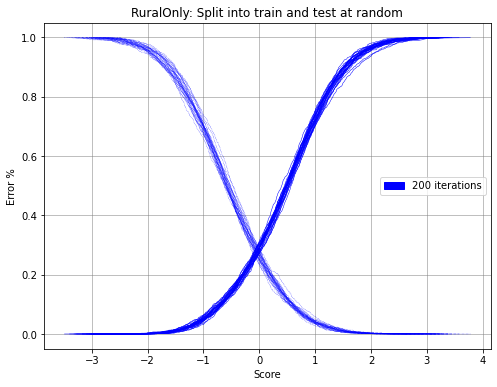

In [12]:
urban=False
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.3
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=200
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log200,
        'style':['b:','b-'],
        'label':'200 iterations',
        'label_color':'b'
    }
]


_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Checkpoint_{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))

